In [1]:
from pathlib import Path
from datasets import load_dataset, DownloadMode
import torch
import os
import glob
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from llama_wrapper import LlamaPromptLens, run_logit_lens_batched, run_logit_lens_autoregressive_batched

In [2]:
from enum import Enum

class Models(Enum):
    LAIN8B = "Models/LLaMA3Instruct"
    HF100B = "Models/HF1BitLLM100Btokens"


class Names(Enum):
    LAIN8B = "Meta-Llama-3-8B-Instruct-fp"
    HF100B = "Llama3-8B-1.58-100B-tokens"

In [3]:
def load_model_and_tok(
    model_name: str,
    low_cpu_mem_usage: bool = True,
    local_files_only: bool = True,
    device_map: str = "cpu",
    dtype: torch.dtype = torch.float32,
):
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        output_hidden_states=True,
        return_dict_in_generate=True,
        return_dict=True,
        output_attentions=True,
        low_cpu_mem_usage=low_cpu_mem_usage,
        local_files_only=local_files_only,
        device_map=device_map,
        torch_dtype=dtype,
        attn_implementation="eager",
    )
    return model, tok

In [4]:
model_orig, orig_tokenizer = load_model_and_tok(Models.LAIN8B.value) 

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
model_quant, quant_tokenizer = load_model_and_tok(Models.HF100B.value) 

In [5]:
model_quant.model.embed_tokens.num_embeddings

128256

In [11]:
model_quant

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): BitLinear()
          (k_proj): BitLinear()
          (v_proj): BitLinear()
          (o_proj): BitLinear()
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): BitLinear()
          (up_proj): BitLinear()
          (down_proj): BitLinear()
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=4096, out_features=128256, bias=False)
)

In [5]:
filepath = r'D:\LogitLensData\nq'

destination_path = str(Path(filepath))
nq_dataset = load_dataset(
    'sentence-transformers/natural-questions',
    split={
        'train': 'train[:200]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [6]:
nq_queries = nq_dataset['train']['query']
nq_answers = nq_dataset['train']['answer']

In [7]:
nq_queries_200 = nq_queries[:200]
nq_queries_400 = nq_queries[200:400]
nq_queries_600 = nq_queries[400:600]
nq_queries_800 = nq_queries[600:800]
nq_queries_1000 = nq_queries[800:1000]

In [9]:
nq_queries_200_1 = nq_queries[:1]

# LOGIT LENS:

In [9]:
import torch
from torch.nn.utils.rnn import pad_sequence

# --------------------------
# Faithful/Raw + heuristic normalization
# --------------------------
def apply_normalization(x, model, normalize_mode="model", block=None, layer_index=None):
    if normalize_mode == "none":
        return x

    elif normalize_mode == "model":
        if block is not None:
            return block.post_attention_layernorm(x)
        elif layer_index == -1:
            first_block = model.model.layers[0]
            return first_block.input_layernorm(x)
        else:
            return x

    elif normalize_mode == "unit_l2":
        if layer_index == -1:
            return x
        else:
            return x / (x.norm(dim=-1, keepdim=True) + 1e-6)

    elif normalize_mode == "unit_rms":
        if layer_index == -1:
            return x
        else:
            return model.model.norm(x)

    elif normalize_mode == "non_param_rms":
        if layer_index == -1:
            return x
        else:
            eps = 1e-5
            return x / (x.pow(2).mean(dim=-1, keepdim=True).add(eps).sqrt())

    else:
        raise ValueError(f"Unknown normalization_mode: {normalize_mode}")


# --------------------------
# Main logit-lens collector 
# --------------------------
def collect_logit_lens_full(
    model,
    tokenizer,
    prompts,
    batch_index=0,
    max_len=17,
    device=None,
    normalize_mode="model",
    clamp_logits=True,
    drop_degenerate_embed_logits=True,
    save_path=None,
):
    """
    Full logit-lens collector that:
      • Captures embeddings and all intermediate hidden states
      • Applies normalization faithfully or heuristically
      • Projects through lm_head for logits
      • Checks and handles untied embeddings
      • Always applies model.model.norm at the final output
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    # ---------------- Tokenize ----------------
    encoded = [
        torch.tensor(
            tokenizer.encode(
                p, add_special_tokens=True, truncation=True, max_length=max_len
            )
        )
        for p in prompts
    ]
    pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id or 0
    input_ids = pad_sequence(encoded, batch_first=True, padding_value=pad_id).to(device)
    batch_size, seq_len = input_ids.shape
    position_ids = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
    vocab_size = model.lm_head.out_features

    # ---------------- Detect tied embeddings ----------------
    tied = (
        hasattr(model, "tie_word_embeddings") and model.tie_word_embeddings()
    ) or (model.lm_head.weight.data_ptr() == model.model.embed_tokens.weight.data_ptr())

    print(f"[info] Embeddings {'tied' if tied else 'untied'} detected")

    def project(x):
        logits = model.lm_head(x)
        if clamp_logits:
            logits = torch.nan_to_num(logits, nan=0.0, posinf=80, neginf=-80)
        return logits

    hidden_dict, logits_dict, rows = {}, {}, []

    with torch.no_grad():
        # ---- Embedding layer ----
        x = model.model.embed_tokens(input_ids)
        h = apply_normalization(x, model, normalize_mode, block=None, layer_index=-1)

        if tied:
            l = project(h)
        else:
            l = project(h)
            mean_abs = l.abs().mean().item()
            if drop_degenerate_embed_logits and (torch.isnan(l).any() or mean_abs < 1e-5):
                print(f"[skip] Untied embeddings degenerate (mean|logit|={mean_abs:.2e}) → zeroing logits.")
                l = torch.zeros(*h.shape[:-1], model.lm_head.out_features, device=h.device)
            else:
                print(f"[keep] Untied embeddings show signal (mean|logit|={mean_abs:.2e}) → keeping logits.")

        l, h = l[:, :-1, :], h[:, :-1, :]
        hidden_dict["embed_tokens"] = h.cpu()
        logits_dict["embed_tokens"] = l.cpu()

        for i in range(batch_size):
            rows.append({
                "prompt_id": i,
                "prompt_text": prompts[i],
                "batch_index": batch_index,
                "vocab_size": vocab_size,
                "layer_index": -1,
                "layer_name": "embed_tokens",
                "input_ids": input_ids[i].detach().cpu(),
                "target_ids": input_ids[i, 1:].detach().cpu(),
                "hidden": h[i].detach().cpu(),
                "logits": l[i].detach().cpu(),
            })

        # ---- Transformer layers ----
        for li, block in enumerate(model.model.layers):
            x = block(x, position_ids=position_ids)[0]  # internally applies input/post norms as per model
            h = apply_normalization(x, model, normalize_mode, block=block, layer_index=li)
            l = project(h)
            l, h = l[:, :-1, :], h[:, :-1, :]
            hidden_dict[f"layer.{li}"] = h.cpu()
            logits_dict[f"layer.{li}"] = l.cpu()

            for i in range(batch_size):
                rows.append({
                    "prompt_id": i,
                    "prompt_text": prompts[i],
                    "batch_index": batch_index,
                    "vocab_size": vocab_size,
                    "layer_index": li,
                    "layer_name": f"layer.{li}",
                    "input_ids": input_ids[i].detach().cpu(),
                    "target_ids": input_ids[i, 1:].detach().cpu(),
                    "hidden": h[i].detach().cpu(),
                    "logits": l[i].detach().cpu(),
                })

        # ---- Final output norm ----
        x = model.model.norm(x)  # faithful final RMSNorm
        h = x
        l = project(x)
        l, h = l[:, :-1, :], h[:, :-1, :]
        hidden_dict["output"] = h.cpu()
        logits_dict["output"] = l.cpu()

        for i in range(batch_size):
            rows.append({
                "prompt_id": i,
                "prompt_text": prompts[i],
                "batch_index": batch_index,
                "vocab_size": vocab_size,
                "layer_index": len(model.model.layers),
                "layer_name": "output",
                "input_ids": input_ids[i].detach().cpu(),
                "target_ids": input_ids[i, 1:].detach().cpu(),
                "hidden": h[i].detach().cpu(),
                "logits": l[i].detach().cpu(),
            })

    if save_path:
        torch.save(rows, save_path)
        print(f"[saved] Logit-lens data → {save_path}")

    print(f"[ok] Collected {len(rows)} layer entries, logits shape {l.shape}")
    return rows, hidden_dict, logits_dict



In [10]:
import torch
import gc
from tqdm import tqdm

def run_logit_lens_in_batches(
    model,
    tokenizer,
    all_prompts,
    batch_size=20,
    save_prefix="logitlens_batch",
    max_len=17,
    normalize_mode="model",
    device=None,
):
    """
    Runs collect_logit_lens_full() in batches to avoid OOM.
    Each batch is saved as a separate .pt file.

    Arguments:
        model, tokenizer : your loaded model + tokenizer
        all_prompts      : list[str] of all input prompts
        batch_size       : number of prompts per batch
        save_prefix      : filename prefix for batch outputs
        max_len          : max token length
        normalize_mode   : normalization mode ('model', 'unit_rms', etc.)
        device           : 'cuda' / 'cpu' override
    """

    num_batches = (len(all_prompts) + batch_size - 1) // batch_size
    print(f"[run] Processing {len(all_prompts)} prompts in {num_batches} batches of {batch_size}")

    for batch_idx in tqdm(range(num_batches), desc="Running logit lens batches"):
        start = batch_idx * batch_size
        end = min((batch_idx + 1) * batch_size, len(all_prompts))
        batch_prompts = all_prompts[start:end]

        save_path = f"{save_prefix}_batch{batch_idx:03d}.pt"

        print(f"\n[batch {batch_idx+1}/{num_batches}] {len(batch_prompts)} prompts → {save_path}")

        try:
            rows, hidden_dict, logits_dict = collect_logit_lens_full(
                model=model,
                tokenizer=tokenizer,
                prompts=batch_prompts,
                max_len=max_len,
                device=device,
                normalize_mode=normalize_mode,
                save_path=save_path,
            )

        except RuntimeError as e:
            print(f"[error] Batch {batch_idx} failed: {e}")
            continue

        # -------------------------------
        # Free GPU + CPU memory
        # -------------------------------
        del rows, hidden_dict, logits_dict, batch_prompts
        torch.cuda.empty_cache()
        gc.collect()

    print("\n[done] All batches processed and saved.")


In [10]:
run_logit_lens_in_batches(
    model=model_orig,
    tokenizer=orig_tokenizer,
    all_prompts=nq_queries_200,
    batch_size=20,
    max_len=12,
    normalize_mode="non_param_rms",
    save_prefix="logs/new_model_lens/non_param_rms/m_orig_non_param_rms",
    device="cpu",
) # "unit_rms", "unit_l2", "none"

[run] Processing 200 prompts in 10 batches of 20


Running logit lens batches:   0%|          | 0/10 [00:00<?, ?it/s]


[batch 1/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch000.pt
[info] Embeddings untied detected


The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


[keep] Untied embeddings show signal (mean|logit|=4.42e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch000.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  10%|█         | 1/10 [01:17<11:35, 77.29s/it]


[batch 2/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch001.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.49e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch001.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  20%|██        | 2/10 [02:32<10:09, 76.20s/it]


[batch 3/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch002.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.50e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch002.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  30%|███       | 3/10 [03:09<06:46, 58.05s/it]


[batch 4/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch003.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.53e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch003.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  40%|████      | 4/10 [03:41<04:47, 47.89s/it]


[batch 5/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch004.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.52e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch004.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  50%|█████     | 5/10 [04:38<04:16, 51.21s/it]


[batch 6/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch005.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.53e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch005.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  60%|██████    | 6/10 [05:10<02:58, 44.67s/it]


[batch 7/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch006.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.43e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch006.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  70%|███████   | 7/10 [06:10<02:28, 49.55s/it]


[batch 8/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch007.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.44e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch007.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  80%|████████  | 8/10 [07:06<01:43, 51.78s/it]


[batch 9/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch008.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.72e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch008.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  90%|█████████ | 9/10 [08:03<00:53, 53.21s/it]


[batch 10/10] 20 prompts → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch009.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.44e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_orig_non_param_rms_batch009.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches: 100%|██████████| 10/10 [08:36<00:00, 51.60s/it]


[done] All batches processed and saved.


In [2]:
import torch
# --- Load your collected batches ---
data = torch.load("logs/new_model_lens/raw/m_orig_raw_batch009.pt", weights_only=False)

In [48]:
print(type(data))
print(len(data))
print(data[0].keys())

<class 'list'>
680
dict_keys(['prompt_id', 'prompt_text', 'batch_index', 'vocab_size', 'layer_index', 'layer_name', 'input_ids', 'target_ids', 'hidden', 'logits'])


In [4]:
import pandas as pd
df = pd.DataFrame(data)

In [5]:
df.head()

prompt_id                                        prompt_text  batch_index  \
0          0               who plays ricky's dad on secret life            0   
1          1  who is the current head of the department of j...            0   
2          2              when does mark come in grey's anatomy            0   
3          3  who sang the original version of the lion slee...            0   
4          4              where did the bald eagle get its name            0   

   vocab_size  layer_index    layer_name  \
0      128256           -1  embed_tokens   
1      128256           -1  embed_tokens   
2      128256           -1  embed_tokens   
3      128256           -1  embed_tokens   
4      128256           -1  embed_tokens   

                                           input_ids  \
0  [tensor(128000), tensor(14965), tensor(11335),...   
1  [tensor(128000), tensor(14965), tensor(374), t...   
2  [tensor(128000), tensor(9493), tensor(1587), t...   
3  [tensor(128000), tensor(14965), tensor(29340),...   
4  [tensor(128000), tensor(2940), tensor(1550), t...   

                                          target_ids  \
0  [tensor(14965), tensor(11335), tensor(436), te...   
1  [tensor(14965), tensor(374), tensor(279), tens...   
2  [tensor(9493), tensor(1587), tensor(1906), ten...   
3  [tensor(14965), tensor(29340), tensor(279), te...   
4  [tensor(2940), tensor(1550), tensor(279), tens...   

                                              hidden  \
0  [[tensor(-8.2970e-05), tensor(0.0003), tensor(...   
1  [[tensor(-8.2970e-05), tensor(0.0003), tensor(...   
2  [[tensor(-8.2970e-05), tensor(0.0003), tensor(...   
3  [[tensor(-8.2970e-05), tensor(0.0003), tensor(...   
4  [[tensor(-8.2970e-05), tensor(0.0003), tensor(...   

                                              logits  
0  [[tensor(-0.0105), tensor(-0.0092), tensor(-0....  
1  [[tensor(-0.0105), tensor(-0.0092), tensor(-0....  
2  [[tensor(-0.0105), tensor(-0.0092), tensor(-0....  
3  [[tensor(-0.0105), tensor(-0.0092), tensor(-0....  
4  [[tensor(-0.0105), tensor(-0.0092), tensor(-0....

In [14]:
df.tail()

prompt_id                                        prompt_text  \
675         15                 what is the meaning of mbbs and md   
676         16      character sketch of hamlet in the play hamlet   
677         17             who made the song my achy breaky heart   
678         18  when do the assassination of gianni versace co...   
679         19        where was the movie paint your wagon filmed   

     batch_index  vocab_size  layer_index layer_name  \
675            0      128256           32     output   
676            0      128256           32     output   
677            0      128256           32     output   
678            0      128256           32     output   
679            0      128256           32     output   

                                             input_ids  \
675  [tensor(128000), tensor(12840), tensor(374), t...   
676  [tensor(128000), tensor(19740), tensor(26610),...   
677  [tensor(128000), tensor(14965), tensor(1903), ...   
678  [tensor(128000), tensor(9493), tensor(656), te...   
679  [tensor(128000), tensor(2940), tensor(574), te...   

                                            target_ids  \
675  [tensor(12840), tensor(374), tensor(279), tens...   
676  [tensor(19740), tensor(26610), tensor(315), te...   
677  [tensor(14965), tensor(1903), tensor(279), ten...   
678  [tensor(9493), tensor(656), tensor(279), tenso...   
679  [tensor(2940), tensor(574), tensor(279), tenso...   

                                                hidden  \
675  [[tensor(0.6379), tensor(0.8319), tensor(-0.79...   
676  [[tensor(0.5351), tensor(1.0714), tensor(-0.64...   
677  [[tensor(0.3241), tensor(0.8842), tensor(-0.86...   
678  [[tensor(0.6773), tensor(0.8068), tensor(-0.70...   
679  [[tensor(0.6057), tensor(0.8599), tensor(-0.95...   

                                                logits  
675  [[tensor(2.4485), tensor(3.2991), tensor(2.336...  
676  [[tensor(2.3287), tensor(2.9359), tensor(1.949...  
677  [[tensor(3.2354), tensor(5.1067), tensor(3.359...  
678  [[tensor(2.0803), tensor(2.7570), tensor(2.059...  
679  [[tensor(2.7771), tensor(4.0858), tensor(2.947...

In [15]:
df.columns

Index(['prompt_id', 'prompt_text', 'batch_index', 'vocab_size', 'layer_index',
       'layer_name', 'input_ids', 'target_ids', 'hidden', 'logits'],
      dtype='object')

In [16]:
df.isna().sum()

prompt_id      0
prompt_text    0
batch_index    0
vocab_size     0
layer_index    0
layer_name     0
input_ids      0
target_ids     0
hidden         0
logits         0
dtype: int64

In [ ]:
df["vocab_size"][0] # 128256

np.int64(128256)

In [11]:
run_logit_lens_in_batches(
    model=model_quant,
    tokenizer=quant_tokenizer,
    all_prompts=nq_queries_200,
    batch_size=20,
    max_len=12,
    normalize_mode="non_param_rms",
    save_prefix="logs/new_model_lens/non_param_rms/m_quant_non_param_rms",
    device="cpu",
) 

[run] Processing 200 prompts in 10 batches of 20


Running logit lens batches:   0%|          | 0/10 [00:00<?, ?it/s]


[batch 1/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch000.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.39e-03) → keeping logits.


The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch000.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  10%|█         | 1/10 [01:07<10:06, 67.42s/it]


[batch 2/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch001.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.45e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch001.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  20%|██        | 2/10 [02:18<09:17, 69.73s/it]


[batch 3/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch002.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.43e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch002.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  30%|███       | 3/10 [04:21<10:57, 93.91s/it]


[batch 4/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch003.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.51e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch003.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  40%|████      | 4/10 [05:16<07:51, 78.62s/it]


[batch 5/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch004.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.45e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch004.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  50%|█████     | 5/10 [06:05<05:38, 67.74s/it]


[batch 6/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch005.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.48e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch005.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  60%|██████    | 6/10 [07:21<04:42, 70.55s/it]


[batch 7/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch006.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.41e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch006.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  70%|███████   | 7/10 [08:35<03:35, 71.91s/it]


[batch 8/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch007.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.41e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch007.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  80%|████████  | 8/10 [09:51<02:26, 73.15s/it]


[batch 9/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch008.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.58e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch008.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches:  90%|█████████ | 9/10 [10:40<01:05, 65.53s/it]


[batch 10/10] 20 prompts → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch009.pt
[info] Embeddings untied detected
[keep] Untied embeddings show signal (mean|logit|=4.40e-03) → keeping logits.
[saved] Logit-lens data → logs/new_model_lens/non_param_rms/m_quant_non_param_rms_batch009.pt
[ok] Collected 680 layer entries, logits shape torch.Size([20, 11, 128256])


Running logit lens batches: 100%|██████████| 10/10 [11:40<00:00, 70.09s/it]


[done] All batches processed and saved.


# SOFTMAX AND TOPK:

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon, jaccard
from scipy.stats import entropy
import pandas as pd
import os


def full_jaccard_over_positions(tkA, tkB, eps=1e-9, device="cpu"):
    """
    Compute Jaccard similarity across *all positions* for each sequence.
    Treats all top-k tokens across positions as one set per model.
    Returns tensor of shape [batch_size].
    """
    batch_scores = []
    for i in range(tkA.size(0)):
        setA = set(tkA[i].flatten().tolist())
        setB = set(tkB[i].flatten().tolist())
        if len(setA) == 0 and len(setB) == 0:
            score = torch.tensor(1.0, device=device)
        else:
            inter = len(setA & setB)
            union = len(setA | setB)
            score = torch.tensor(inter / (union + eps), device=device)
        batch_scores.append(score)
    return torch.stack(batch_scores)


def safe_mean(x):
    """Robust mean: always returns a finite float (never NaN or None)."""
    if x is None:
        return 0.0
    if torch.is_tensor(x):
        if x.numel() == 0:
            return 0.0
        x = torch.nan_to_num(x.detach().float(), nan=0.0, posinf=0.0, neginf=0.0).flatten()
        if x.numel() == 0:
            return 0.0
        return float(x.mean().item())
    if isinstance(x, (list, tuple, np.ndarray)):
        arr = np.asarray(x, dtype=np.float64).ravel()
        if arr.size == 0:
            return 0.0
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        return float(np.mean(arr))
    try:
        val = float(x)
        if not np.isfinite(val):
            return 0.0
        return val
    except Exception:
        return 0.0



def compute_final_perplexity(final_logits, labels, ignore_index=-100, eps=1e-9):
    """
    Compute overall model perplexity = exp(mean cross-entropy loss)
    using the model's final logits.
    """
    # Align for causal models (predict next token)
    if final_logits.size(1) == labels.size(1) + 1:
        final_logits = final_logits[:, :-1, :]
    elif final_logits.size(1) + 1 == labels.size(1):
        labels = labels[:, 1:]

    logits_flat = final_logits.reshape(-1, final_logits.size(-1))
    labels_flat = labels.reshape(-1)

    # Cross-entropy
    ce_loss = F.cross_entropy(logits_flat, labels_flat, ignore_index=ignore_index, reduction="mean")

    # Safe exponential
    ppl = float(torch.exp(torch.clamp(ce_loss, min=0.0, max=30.0)))
    return ppl, float(ce_loss)


@torch.no_grad()
def compare_metrics_with_softmax(
    metrics_A,
    metrics_B,
    topk=(1, 5, 10, 20),
    eps=1e-9,
    mode="aligned",
    mask_ids=[128000, 128009],
    batch_num=0,
    lens_type="raw",
    device=None,
    tokenizer=None,
    debug_checks=False,
):
    """
    Compare metrics between two model outputs with full numerical safety.
    Masked probabilities are renormalized; NaNs/Infs are handled everywhere.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    topk = sorted(set([1] + list(topk)))
    max_k = max(topk)

    def safe(x, default=0.0):
        return torch.nan_to_num(x, nan=default, posinf=default, neginf=default)

    def pad_vocab_dim(logits, target_vocab):
        pad = target_vocab - logits.size(-1)
        if pad > 0:
            logits = F.pad(logits, (0, pad))
        return logits

    # Pair rows depending on mode
    if mode == "aligned":
        pairs = list(zip(metrics_A, metrics_B))
    elif mode == "position_final":
        def last_by_prompt(rows):
            best = {}
            for r in rows:
                pid = r["prompt_id"]
                if pid not in best or r["layer_index"] > best[pid]["layer_index"]:
                    best[pid] = r
            return best
        last_A = last_by_prompt(metrics_A)
        last_B = last_by_prompt(metrics_B)
        common_pids = sorted(set(last_A) & set(last_B))
        pairs = [(last_A[p], last_B[p]) for p in common_pids]
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # Prepare mask ids
    if tokenizer is not None:
        tok_specials = [
            getattr(tokenizer, "bos_token_id", None),
            getattr(tokenizer, "eos_token_id", None),
            getattr(tokenizer, "pad_token_id", None),
        ]
        mask_ids = [t for t in tok_specials if t is not None] + (mask_ids or [])
    mask_ids = sorted(set([m for m in (mask_ids or []) if m is not None]))
    mask_ids_tensor = torch.tensor(mask_ids, device=device, dtype=torch.long) if mask_ids else None

    detailed = []

    # ============================================================
    # === MAIN LOOP ==============================================
    # ============================================================
    for row_A, row_B in pairs:
        assert row_A["prompt_id"] == row_B["prompt_id"]
        if mode == "aligned":
            assert row_A["layer_index"] == row_B["layer_index"]

        logits_A = safe(row_A["logits"].clone().float().to(device))
        logits_B = safe(row_B["logits"].clone().float().to(device))
        if logits_A.ndim == 2: logits_A = logits_A.unsqueeze(0)
        if logits_B.ndim == 2: logits_B = logits_B.unsqueeze(0)
        vocab_target = max(logits_A.size(-1), logits_B.size(-1))
        logits_A, logits_B = pad_vocab_dim(logits_A, vocab_target), pad_vocab_dim(logits_B, vocab_target)

        # --- Stable log-softmax ---
        logp_A_clean = safe(F.log_softmax(logits_A, dim=-1), -30.0)
        logp_B_clean = safe(F.log_softmax(logits_B, dim=-1), -30.0)
        probs_A_clean, probs_B_clean = logp_A_clean.exp(), logp_B_clean.exp()

        # --- Mask setup ---
        valid_vocab_mask = torch.ones(vocab_target, dtype=torch.bool, device=device)
        if mask_ids_tensor is not None and mask_ids_tensor.numel() > 0:
            valid_vocab_mask[mask_ids_tensor] = False

        # --- Mask + renormalize ---
        probs_A_masked, probs_B_masked = probs_A_clean.clone(), probs_B_clean.clone()
        probs_A_masked[..., ~valid_vocab_mask] = 0.0
        probs_B_masked[..., ~valid_vocab_mask] = 0.0
        denom_A = probs_A_masked.sum(dim=-1, keepdim=True).clamp_min(eps)
        denom_B = probs_B_masked.sum(dim=-1, keepdim=True).clamp_min(eps)
        probs_A_masked, probs_B_masked = probs_A_masked / denom_A, probs_B_masked / denom_B
        logp_A_masked = safe(torch.log(probs_A_masked + eps), -30.0)
        logp_B_masked = safe(torch.log(probs_B_masked + eps), -30.0)

        # --- Dispersion + quantiles ---
        valid_probs_A, valid_probs_B = probs_A_masked[..., valid_vocab_mask], probs_B_masked[..., valid_vocab_mask]
        mean_prob_A, mean_prob_B = valid_probs_A.mean(dim=-1), valid_probs_B.mean(dim=-1)
        max_prob_A, max_prob_B = valid_probs_A.max(dim=-1).values, valid_probs_B.max(dim=-1).values
        min_prob_A, min_prob_B = valid_probs_A.min(dim=-1).values, valid_probs_B.min(dim=-1).values
        sorted_A, _ = torch.sort(valid_probs_A, dim=-1)
        sorted_B, _ = torch.sort(valid_probs_B, dim=-1)
        q25_A, q75_A = torch.quantile(sorted_A, 0.25, dim=-1), torch.quantile(sorted_A, 0.75, dim=-1)
        q25_B, q75_B = torch.quantile(sorted_B, 0.25, dim=-1), torch.quantile(sorted_B, 0.75, dim=-1)
        iqr_A, iqr_B = q75_A - q25_A, q75_B - q25_B

        # --- Divergences ---
        kl_ab = safe(torch.sum(probs_A_masked * (logp_A_masked - logp_B_masked), dim=-1))
        kl_ba = safe(torch.sum(probs_B_masked * (logp_B_masked - logp_A_masked), dim=-1))
        kl_ab_token, kl_ba_token = float(kl_ab.mean()), float(kl_ba.mean())
        try:
            jsd_dist = torch.tensor(
                jensenshannon(probs_A_masked.cpu().numpy(), probs_B_masked.cpu().numpy(), axis=-1),
                device=device,
            )
        except Exception:
            jsd_dist = torch.zeros_like(kl_ab)
        jsd_div = safe(jsd_dist.pow(2))
        vocab_tvd = safe(0.5 * torch.sum(torch.abs(probs_A_masked - probs_B_masked), dim=-1))
        heat_A = safe(-torch.sum(probs_A_masked * logp_A_masked, dim=-1))
        heat_B = safe(-torch.sum(probs_B_masked * logp_B_masked, dim=-1))

        # --- Hidden metrics + Perplexity ---
        hidden_l2 = hidden_cosine = hidden_ppl_A = hidden_ppl_B = hidden_ppl_diff = hidden_ppl_absdiff = float("nan")

        if "hidden" in row_A and "hidden" in row_B:
            hA = safe(row_A["hidden"].to(device).float())
            hB = safe(row_B["hidden"].to(device).float())
            hA_flat, hB_flat = hA.reshape(-1, hA.size(-1)), hB.reshape(-1, hB.size(-1))
            hidden_l2 = float(torch.norm(hA_flat - hB_flat, dim=-1).mean().item())
            hidden_cosine = float(F.cosine_similarity(hA_flat, hB_flat, dim=-1).mean().item())

        targets = row_A.get("target_ids")
        if targets is not None:
            targets = targets.to(device)

            # --- Shape-safe gather for NLL ---
            if targets.ndim == 1:
                gather_idx = targets.unsqueeze(0).unsqueeze(-1)
            elif targets.ndim == 2:
                gather_idx = targets.unsqueeze(-1)
            else:
                raise ValueError(f"Unexpected target_ids shape: {targets.shape}")

            gather_idx = gather_idx.clamp(max=logp_A_masked.size(-1) - 1)

            # --- Negative log-likelihoods ---
            nll_A = safe(-logp_A_masked.gather(dim=-1, index=gather_idx).squeeze(-1))
            nll_B = safe(-logp_B_masked.gather(dim=-1, index=gather_idx).squeeze(-1))
            nll_A, nll_B = nll_A[torch.isfinite(nll_A)], nll_B[torch.isfinite(nll_B)]

            # --- Perplexity + Differences ---
            if nll_A.numel() and nll_B.numel():
                mean_A = nll_A.mean().clamp_min(0.0)
                mean_B = nll_B.mean().clamp_min(0.0)
                hidden_ppl_A = float(torch.exp(mean_A))
                hidden_ppl_B = float(torch.exp(mean_B))
                hidden_ppl_diff = float(hidden_ppl_A - hidden_ppl_B)
                hidden_ppl_absdiff = abs(hidden_ppl_diff)

        # --- Top-k metrics ---
        top_vals_A, top_idx_A = torch.topk(probs_A_masked, max_k, dim=-1)
        top_vals_B, top_idx_B = torch.topk(probs_B_masked, max_k, dim=-1)
        acc_A_topk, acc_B_topk, agree_topk, jaccard_topk = {}, {}, {}, {}
        full_jaccard_topk, prob_mass_A_topk, prob_mass_B_topk = {}, {}, {}
        shared_mass_topk, tail_mass_A_topk, tail_mass_B_topk = {}, {}, {}
        prob_overlap_topk, prob_mass_overlap_topk = {}, {}

        mask_pattern = None
        if targets is not None:
            mask_pattern = ~torch.isin(targets, mask_ids_tensor) if mask_ids_tensor is not None else torch.ones_like(targets, dtype=torch.bool)

        for k in topk:
            tkA, tkB = top_idx_A[:, :, :k], top_idx_B[:, :, :k]
            tvA, tvB = top_vals_A[:, :, :k], top_vals_B[:, :, :k]
            prob_mass_A_topk[k], prob_mass_B_topk[k] = tvA.sum(dim=-1), tvB.sum(dim=-1)
            tail_mass_A_topk[k], tail_mass_B_topk[k] = 1 - prob_mass_A_topk[k], 1 - prob_mass_B_topk[k]
            inter_mask = (tkA.unsqueeze(-1) == tkB.unsqueeze(-2))
            inter_counts = inter_mask.any(dim=-1).sum(dim=2).float()
            jaccard_topk[k] = inter_counts / (2 * k - inter_counts + eps)
            agree_topk[k] = (inter_counts == k).float()
            full_jaccard_topk[k] = full_jaccard_over_positions(tkA, tkB, eps, device)

            shared_mass = torch.zeros_like(prob_mass_A_topk[k])
            for i in range(tkA.size(0)):
                shared_tokens = set(tkA[i].reshape(-1).tolist()) & set(tkB[i].reshape(-1).tolist())
                if shared_tokens:
                    st = torch.tensor(list(shared_tokens), device=device)
                    shared_mass[i] = 0.5 * (probs_A_masked[i, :, st].sum() + probs_B_masked[i, :, st].sum())
            shared_mass_topk[k] = shared_mass
            prob_mass_overlap_topk[k] = prob_mass_A_topk[k] * prob_mass_B_topk[k]
            prob_overlap_topk[k] = shared_mass / (0.5 * (prob_mass_A_topk[k] + prob_mass_B_topk[k]) + eps)

            if targets is not None:
                tgt_expand = targets.unsqueeze(0) if targets.ndim == 1 else targets
                acc_A = (tkA == tgt_expand.unsqueeze(-1)).any(dim=-1).float()
                acc_B = (tkB == tgt_expand.unsqueeze(-1)).any(dim=-1).float()
                if mask_pattern is not None:
                    mp = mask_pattern.unsqueeze(0) if mask_pattern.ndim == 1 else mask_pattern
                    acc_A, acc_B = acc_A * mp, acc_B * mp
                acc_A_topk[k], acc_B_topk[k] = acc_A, acc_B
            else:
                acc_A_topk[k] = acc_B_topk[k] = None

        # Build single detailed row
        detailed_row = {
            "prompt_id": row_A["prompt_id"],
            "prompt_text": row_A.get("prompt_text"),
            "layer_index": row_A["layer_index"],
            "layer_name": row_A["layer_name"],
            "vocab_size": vocab_target,
            "input_ids": row_A.get("input_ids"),
            "targets": row_A.get("target_ids"),
            "mask": mask_ids,
            "mask_pattern": mask_pattern.cpu() if (mask_pattern is not None and isinstance(mask_pattern, torch.Tensor)) else mask_pattern,
            "kl_ab": kl_ab.cpu(),
            "kl_ba": kl_ba.cpu(),
            "kl_ab_token": kl_ab_token,
            "kl_ba_token": kl_ba_token,
            "jsd_div": jsd_div.cpu(),
            "jsd_dist": jsd_dist.cpu(),
            "vocab_tvd": vocab_tvd.cpu(),
            "heat_A": heat_A.cpu(),
            "heat_B": heat_B.cpu(),
            "iqr_A": iqr_A.cpu(),
            "iqr_B": iqr_B.cpu(),
            "mean_prob_A": mean_prob_A.cpu(),
            "mean_prob_B": mean_prob_B.cpu(),
            "max_prob_A": max_prob_A.cpu(),
            "max_prob_B": max_prob_B.cpu(),
            "min_prob_A": min_prob_A.cpu(),
            "min_prob_B": min_prob_B.cpu(),
            "hidden_l2": hidden_l2,
            "hidden_cosine": hidden_cosine,
            "hidden_ppl_A": hidden_ppl_A,
            "hidden_ppl_B": hidden_ppl_B,
            "hidden_ppl_diff": hidden_ppl_diff,
            "hidden_ppl_absdiff": hidden_ppl_absdiff,
            "acc_A_topk": acc_A_topk,
            "acc_B_topk": acc_B_topk,
            "agree_topk": agree_topk,
            "jaccard_topk": jaccard_topk,
            "full_jaccard_topk": full_jaccard_topk,
            "prob_mass_A_topk": prob_mass_A_topk,
            "prob_mass_B_topk": prob_mass_B_topk,
            "tail_mass_A_topk": tail_mass_A_topk,
            "tail_mass_B_topk": tail_mass_B_topk,
            "shared_mass_topk": shared_mass_topk,
            "prob_overlap_topk": prob_overlap_topk,
            "prob_mass_overlap_topk": prob_mass_overlap_topk,
        }
        detailed.append(detailed_row)

    # ============================================================
    # === FINAL MODEL PERPLEXITY =================================
    # ============================================================
    # ============================================================
    # === FINAL MODEL PERPLEXITY =================================
    # ============================================================
    def compute_final_perplexity(final_logits, labels, ignore_index=-100, eps=1e-9):
        """Compute overall model perplexity = exp(mean cross-entropy loss)"""
        # Ensure 3D logits [batch, seq, vocab]
        if final_logits.ndim == 2:
            final_logits = final_logits.unsqueeze(0)
        if labels.ndim == 1:
            labels = labels.unsqueeze(0)

        # Align for causal LM (predict next token)
        if final_logits.size(1) == labels.size(1) + 1:
            final_logits = final_logits[:, :-1, :]
        elif final_logits.size(1) + 1 == labels.size(1):
            labels = labels[:, 1:]

        # Flatten
        logits_flat = final_logits.reshape(-1, final_logits.size(-1))
        labels_flat = labels.reshape(-1)

        # Compute CE + PPL
        ce_loss = F.cross_entropy(logits_flat, labels_flat, ignore_index=ignore_index, reduction="mean")
        ppl = float(torch.exp(torch.clamp(ce_loss, min=0.0, max=30.0)))
        return ppl, float(ce_loss)

    if len(pairs) > 0 and pairs[-1][0].get("target_ids") is not None:
        labels = pairs[-1][0]["target_ids"].to(device)
        final_logits_A = pairs[-1][0]["logits"].to(device)
        final_logits_B = pairs[-1][1]["logits"].to(device)
        final_ppl_A, ce_A = compute_final_perplexity(final_logits_A, labels)
        final_ppl_B, ce_B = compute_final_perplexity(final_logits_B, labels)
        final_ppl_diff = abs(final_ppl_A - final_ppl_B)
    else:
        final_ppl_A = final_ppl_B = final_ppl_diff = float("nan")
        ce_A = ce_B = float("nan")


    # ============================================================
    # === BUILD SUMMARY ==========================================
    # ============================================================
    def build_summary(detailed_list, topk_list):
        rows = []
        for r in detailed_list:
            s = {
                "prompt_id": r["prompt_id"],
                "layer_index": r["layer_index"],
                "layer_name": r["layer_name"],
                "kl_ab": safe_mean(r.get("kl_ab")),
                "kl_ba": safe_mean(r.get("kl_ba")),
                "jsd_div": safe_mean(r.get("jsd_div")),
                "jsd_dist": safe_mean(r.get("jsd_dist")),
                "vocab_tvd": safe_mean(r.get("vocab_tvd")),
                "heat_A": safe_mean(r.get("heat_A")),
                "heat_B": safe_mean(r.get("heat_B")),
                "iqr_A": safe_mean(r.get("iqr_A")),
                "iqr_B": safe_mean(r.get("iqr_B")),
                "mean_prob_A": safe_mean(r.get("mean_prob_A")),
                "mean_prob_B": safe_mean(r.get("mean_prob_B")),
                "max_prob_A": safe_mean(r.get("max_prob_A")),
                "max_prob_B": safe_mean(r.get("max_prob_B")),
                "min_prob_A": safe_mean(r.get("min_prob_A")),
                "min_prob_B": safe_mean(r.get("min_prob_B")),
                "hidden_l2": safe_mean(r.get("hidden_l2")),
                "hidden_cosine": safe_mean(r.get("hidden_cosine")),
                "hidden_ppl_A": safe_mean(r.get("hidden_ppl_A")),
                "hidden_ppl_B": safe_mean(r.get("hidden_ppl_B")),
                "hidden_ppl_diff": safe_mean(r.get("hidden_ppl_diff")),
                "hidden_ppl_absdiff": safe_mean(r.get("hidden_ppl_absdiff")),
            }
            for k in topk_list:
                s[f"acc_A@{k}"] = safe_mean(r["acc_A_topk"].get(k) if r.get("acc_A_topk") else None)
                s[f"acc_B@{k}"] = safe_mean(r["acc_B_topk"].get(k) if r.get("acc_B_topk") else None)
                s[f"agree@{k}"] = safe_mean(r["agree_topk"].get(k))
                s[f"jaccard@{k}"] = safe_mean(r["jaccard_topk"].get(k))
                s[f"full_jaccard@{k}"] = safe_mean(r["full_jaccard_topk"].get(k))
                s[f"prob_overlap@{k}"] = safe_mean(r["prob_overlap_topk"].get(k))
                s[f"prob_mass_overlap@{k}"] = safe_mean(r["prob_mass_overlap_topk"].get(k))
                s[f"tail_A@{k}"] = safe_mean(r["tail_mass_A_topk"].get(k))
                s[f"tail_B@{k}"] = safe_mean(r["tail_mass_B_topk"].get(k))
            rows.append(s)

        summary_df = pd.DataFrame(rows)
        summary_df = summary_df.replace([np.inf, -np.inf], np.nan)

        # Merge final perplexity into summary
        summary_df["final_ce_A"] = ce_A
        summary_df["final_ce_B"] = ce_B
        summary_df["final_ppl_A"] = final_ppl_A
        summary_df["final_ppl_B"] = final_ppl_B
        summary_df["final_ppl_diff"] = final_ppl_diff

        layer_summary_df = (
            summary_df.drop(columns=["prompt_id"], errors="ignore")
            .groupby("layer_name")
            .mean(numeric_only=True)
            .reset_index()
            .sort_values("layer_name")
        )
        return summary_df, layer_summary_df



    # --- Save combined summaries for BOTH models ---
    summary, layer_summary = build_summary(detailed, topk)

    # consistent names for this dataset and run
    out_dir = f"logs/new_summary/{lens_type}"
    os.makedirs(out_dir, exist_ok=True)

    summary_path = f"{out_dir}/summary_{lens_type}_{batch_num}.parquet"
    layer_path  = f"{out_dir}/layerwise_{lens_type}_{batch_num}.parquet"

    summary.to_parquet(summary_path, index=False)
    layer_summary.to_parquet(layer_path, index=False)

    print(f"[saved] summary → {summary_path}")
    print(f"[saved] layer-wise summary → {layer_path}")
    print(f"[ok] Compared {len(detailed)} pairs (vocab padded safely).")

    return detailed, summary, layer_summary

In [101]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("Models/LLaMA3Instruct")

In [102]:
import torch

lens_type = "unit_rms"
batch_num = "001"

# --- Load collected metrics ---
metrics_A = torch.load(f"logs/new_model_lens/{lens_type}/m_orig_{lens_type}_batch{batch_num}.pt", weights_only=False)
metrics_B = torch.load(f"logs/new_model_lens/{lens_type}/m_quant_{lens_type}_batch{batch_num}.pt", weights_only=False)

# --- Sanity check alignment ---
assert len(metrics_A) == len(metrics_B), f"Length mismatch: {len(metrics_A)} vs {len(metrics_B)}"

for i, (a, b) in enumerate(zip(metrics_A, metrics_B)):
    if a["prompt_id"] != b["prompt_id"]:
        raise ValueError(f"Prompt ID mismatch at {i}: {a['prompt_id']} vs {b['prompt_id']}")
    if a["layer_index"] != b["layer_index"]:
        raise ValueError(f"Layer mismatch at {i}: {a['layer_index']} vs {b['layer_index']}")

print(f"[check] Matched {len(metrics_A)} layers across both models.")

def ensure_tensor(x, device="cpu"):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, np.ndarray)):
        return torch.tensor(x, device=device, dtype=torch.float32)
    return x

for row in metrics_A:
    row["logits"] = ensure_tensor(row["logits"])
    if "target_ids" in row:
        row["ta0get_ids"] = ensure_tensor(row["target_ids"])

for row in metrics_B:
    row["logits"] = ensure_tensor(row["logits"])
    if "target_ids" in row:
        row["target_ids"] = ensure_tensor(row["target_ids"])
        
# --- Run metric comparison ---
detailed, summary, layer_summary = compare_metrics_with_softmax(
    metrics_A=metrics_A,
    metrics_B=metrics_B,
    batch_num=batch_num,
    lens_type=lens_type,
    tokenizer=tok,  # must be the same tokenizer used in collection
    device="cpu"
)

# Save your results
save_path = f"logs/new_model_lens/topks/{lens_type}/{lens_type}_{batch_num}.pt"
torch.save(detailed, save_path)


[check] Matched 680 layers across both models.


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [79]:
layer_summary["jsd_dist"][:5]

0    0.001192
1    0.572762
2    0.602683
3    0.660553
4    0.658853
Name: jsd_dist, dtype: float64

In [80]:
layer_summary["min_prob_A"].min()

np.float64(3.4398367035099084e-12)

In [81]:
layer_summary["hidden_ppl_diff"][:20]

0     1.390914e+03
1     1.540432e+06
2     1.841782e+06
3     1.780161e+06
4     1.449684e+06
5     1.502986e+06
6     2.756115e+05
7     3.757430e+05
8    -2.815493e+05
9    -3.289392e+05
10   -3.263003e+05
11   -2.483946e+05
12   -2.774051e+05
13    1.053615e+06
14   -2.625609e+05
15   -2.495521e+05
16   -1.396909e+05
17   -1.058286e+05
18   -9.131459e+04
19   -8.127432e+04
Name: hidden_ppl_diff, dtype: float64

In [82]:
layer_summary["hidden_ppl_absdiff"][:20]

0     1.390914e+03
1     1.540432e+06
2     1.930808e+06
3     1.780161e+06
4     1.559504e+06
5     1.516962e+06
6     7.098080e+05
7     5.954137e+05
8     3.299663e+05
9     3.361942e+05
10    3.263003e+05
11    2.483946e+05
12    2.774051e+05
13    1.107889e+06
14    2.625609e+05
15    2.495521e+05
16    1.396909e+05
17    1.058286e+05
18    9.131459e+04
19    8.127432e+04
Name: hidden_ppl_absdiff, dtype: float64

In [83]:
print("Min nonzero prob across all layers:", layer_summary["min_prob_A"].replace(0, np.nan).min())


Min nonzero prob across all layers: 3.4398367035099084e-12


In [91]:
layer_summary["hidden_ppl_ratio"] = (
    layer_summary["hidden_ppl_A"] / layer_summary["hidden_ppl_B"]
)


In [92]:
(layer_summary["hidden_ppl_ratio"] - 1).sub(layer_summary["hidden_ppl_diff"]).abs().max()


np.float64(6452833.0076777665)

In [93]:
detailed

[{'prompt_id': 0,
  'prompt_text': 'who played the emperor in the return of the jedi',
  'layer_index': -1,
  'layer_name': 'embed_tokens',
  'vocab_size': 128256,
  'input_ids': tensor([128000,  14965,   6476,    279,  57883,    304,    279,    471,    315,
             279,  18806,     72]),
  'targets': tensor([14965,  6476,   279, 57883,   304,   279,   471,   315,   279, 18806,
             72]),
  'mask': [128000, 128009],
  'mask_pattern': tensor([True, True, True, True, True, True, True, True, True, True, True]),
  'kl_ab': tensor([[1.5977e-06, 1.1185e-05, 1.2729e-05, 4.2103e-06, 1.0749e-05, 3.1096e-06,
           4.2103e-06, 6.9582e-06, 3.3228e-06, 4.2103e-06, 1.2710e-05]]),
  'kl_ba': tensor([[1.4828e-06, 1.1148e-05, 1.2644e-05, 4.2153e-06, 1.0898e-05, 2.8908e-06,
           4.2153e-06, 6.9984e-06, 3.1451e-06, 4.2153e-06, 1.2783e-05]]),
  'kl_ab_token': 6.817375378886936e-06,
  'kl_ba_token': 6.785106961615384e-06,
  'jsd_div': tensor([[3.8505e-07, 2.7919e-06, 3.1719e-06, 1.0

In [40]:
df = pd.DataFrame(detailed)

In [41]:
df.isna().sum()

prompt_id                 0
prompt_text               0
layer_index               0
layer_name                0
vocab_size                0
input_ids                 0
targets                   0
mask                      0
mask_pattern              0
kl_ab                     0
kl_ba                     0
kl_ab_token               0
kl_ba_token               0
jsd_div                   0
jsd_dist                  0
vocab_tvd                 0
heat_A                    0
heat_B                    0
iqr_A                     0
iqr_B                     0
mean_prob_A               0
mean_prob_B               0
max_prob_A                0
max_prob_B                0
min_prob_A                0
min_prob_B                0
hidden_l2                 0
hidden_cosine             0
hidden_ppl_A              0
hidden_ppl_B              0
hidden_ppl_diff           0
acc_A_topk                0
acc_B_topk                0
agree_topk                0
jaccard_topk              0
full_jaccard_topk   

In [22]:
df.head()

prompt_id                                        prompt_text  layer_index  \
0          0  when did richmond last play in a preliminary f...           -1   
1          1         who sang what in the world's come over you           -1   
2          2            who produces the most wool in the world           -1   
3          3     where does alaska the last frontier take place           -1   
4          4                a day to remember all i want cameos           -1   

     layer_name  vocab_size  \
0  embed_tokens      128256   
1  embed_tokens      128256   
2  embed_tokens      128256   
3  embed_tokens      128256   
4  embed_tokens      128256   

                                           input_ids  \
0  [tensor(128000), tensor(9493), tensor(1550), t...   
1  [tensor(128000), tensor(14965), tensor(29340),...   
2  [tensor(128000), tensor(14965), tensor(19159),...   
3  [tensor(128000), tensor(2940), tensor(1587), t...   
4  [tensor(128000), tensor(64), tensor(1938), ten...   

                                             targets              mask  \
0  [tensor(9493), tensor(1550), tensor(9257), ten...  [128000, 128009]   
1  [tensor(14965), tensor(29340), tensor(1148), t...  [128000, 128009]   
2  [tensor(14965), tensor(19159), tensor(279), te...  [128000, 128009]   
3  [tensor(2940), tensor(1587), tensor(453), tens...  [128000, 128009]   
4  [tensor(64), tensor(1938), tensor(311), tensor...  [128000, 128009]   

                                        mask_pattern  \
0  [tensor(True), tensor(True), tensor(True), ten...   
1  [tensor(True), tensor(True), tensor(True), ten...   
2  [tensor(True), tensor(True), tensor(True), ten...   
3  [tensor(True), tensor(True), tensor(True), ten...   
4  [tensor(True), tensor(True), tensor(True), ten...   

                                               kl_ab  ...  \
0  [[tensor(2.3441e-06), tensor(6.6665e-06), tens...  ...   
1  [[tensor(2.3441e-06), tensor(1.0691e-05), tens...  ...   
2  [[tensor(2.3441e-06), tensor(1.0691e-05), tens...  ...   
3  [[tensor(2.3441e-06), tensor(1.0872e-05), tens...  ...   
4  [[tensor(2.3441e-06), tensor(4.2423e-06), tens...  ...   

                                          agree_topk  \
0  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
1  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
2  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
3  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
4  {1: [[tensor(0.), tensor(0.), tensor(1.), tens...   

                                        jaccard_topk  \
0  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
1  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
2  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
3  {1: [[tensor(0.), tensor(0.), tensor(0.), tens...   
4  {1: [[tensor(0.), tensor(0.), tensor(1.), tens...   

                                   full_jaccard_topk  \
0  {1: [tensor(0.0476)], 5: [tensor(0.1000)], 10:...   
1  {1: [tensor(0.1000)], 5: [tensor(0.1474)], 10:...   
2  {1: [tensor(0.)], 5: [tensor(0.1111)], 10: [te...   
3  {1: [tensor(0.0476)], 5: [tensor(0.1000)], 10:...   
4  {1: [tensor(0.1000)], 5: [tensor(0.1224)], 10:...   

                                    prob_mass_A_topk  \
0  {1: [[tensor(8.0284e-06), tensor(8.0485e-06), ...   
1  {1: [[tensor(8.0284e-06), tensor(8.0547e-06), ...   
2  {1: [[tensor(8.0284e-06), tensor(8.0547e-06), ...   
3  {1: [[tensor(8.0284e-06), tensor(8.0435e-06), ...   
4  {1: [[tensor(8.0284e-06), tensor(7.9649e-06), ...   

                                    prob_mass_B_topk  \
0  {1: [[tensor(8.0082e-06), tensor(8.0303e-06), ...   
1  {1: [[tensor(8.0082e-06), tensor(8.0209e-06), ...   
2  {1: [[tensor(8.0082e-06), tensor(8.0209e-06), ...   
3  {1: [[tensor(8.0082e-06), tensor(8.0422e-06), ...   
4  {1: [[tensor(8.0082e-06), tensor(8.0063e-06), ...   

                                    tail_mass_A_topk  \
0  {1: [[tensor(1.0000), tensor(1.0000), tensor(1...   
1  {1: [[tensor(1.0000), tensor(1.0000), tensor(1...

In [23]:
df["hidden_cosine"][:5]

0    0.865720
1    0.879439
2    0.899754
3    0.874803
4    0.881942
Name: hidden_cosine, dtype: float64

# ============ END SOFTMAX ============

# ========= HIDDEN ==========

In [ ]:
import torch
import torch.nn.functional as F
import math
import pandas as pd

@torch.no_grad()
def compute_hidden_metrics(
    rows_A, rows_B, 
    model_A, model_B,
    lens_type,
    batch_num, 
    device="cpu"
):
    """
    Computes layerwise metrics from saved hidden states for two models:
      - Lens-based perplexity
      - L2 distance
      - Cosine similarity
      - Perplexity difference (ΔPPL)
    """

    results = []
    for rA, rB in zip(rows_A, rows_B):
        assert rA["prompt_id"] == rB["prompt_id"]
        assert rA["layer_name"] == rB["layer_name"]

        hA = rA["hidden"].to(device).float()
        hB = rB["hidden"].to(device).float()
        targets = rA["target_ids"].to(device)

        # --- Projection through lm_head ---
        logits_A = model_A.lm_head(hA)
        logits_B = model_B.lm_head(hB)

        log_probs_A = F.log_softmax(logits_A, dim=-1)
        log_probs_B = F.log_softmax(logits_B, dim=-1)

        # --- NLL and Perplexity ---
        gather_idx = targets.unsqueeze(-1)
        target_logprobs_A = log_probs_A.gather(2, gather_idx).squeeze(-1)
        target_logprobs_B = log_probs_B.gather(2, gather_idx).squeeze(-1)

        nll_A = -target_logprobs_A.mean()
        nll_B = -target_logprobs_B.mean()

        ppl_A = math.exp(nll_A.item())
        ppl_B = math.exp(nll_B.item())
        ppl_diff = ppl_A - ppl_B
        nll_diff = (nll_A - nll_B).item()

        # --- L2 distance and cosine similarity ---
        # Flatten across sequence dimension
        hA_flat = hA.reshape(-1, hA.size(-1))
        hB_flat = hB.reshape(-1, hB.size(-1))

        l2_dist = torch.norm(hA_flat - hB_flat, dim=-1).mean().item()
        cosine_sim = F.cosine_similarity(hA_flat, hB_flat, dim=-1).mean().item()

        results.append({
            "prompt_id": rA["prompt_id"],
            "layer_index": rA["layer_index"],
            "layer_name": rA["layer_name"],
            "ppl_A": ppl_A,
            "ppl_B": ppl_B,
            "ppl_diff": ppl_diff,
            "nll_A": nll_A.item(),
            "nll_B": nll_B.item(),
            "nll_diff": nll_diff,
            "l2_dist": l2_dist,
            "cosine_sim": cosine_sim,
        })

    df = pd.DataFrame(results)
    layerwise = (
        df.groupby("layer_name")
        .mean(numeric_only=True)
        .reset_index()
        .sort_values("layer_index")
    )

    save_path = f"logs/hidden/summary/{lens_type}/{lens_type}_{batch_num}.pt"
    layerwise.to_parquet(save_path, index=False)
    return df, layerwise


In [ ]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("Models/LLaMA3Instruct")

In [ ]:
import torch

lens_type = "non_param_rms"
batch_num = "009"

# --- Load collected metrics ---
metrics_A = torch.load(f"logs/new_model_lens/{lens_type}/m_orig_{lens_type}_batch{batch_num}.pt", weights_only=False)
metrics_B = torch.load(f"logs/new_model_lens/{lens_type}/m_quant_{lens_type}_batch{batch_num}.pt", weights_only=False)

# --- Sanity check alignment ---
assert len(metrics_A) == len(metrics_B), f"Length mismatch: {len(metrics_A)} vs {len(metrics_B)}"

for i, (a, b) in enumerate(zip(metrics_A, metrics_B)):
    if a["prompt_id"] != b["prompt_id"]:
        raise ValueError(f"Prompt ID mismatch at {i}: {a['prompt_id']} vs {b['prompt_id']}")
    if a["layer_index"] != b["layer_index"]:
        raise ValueError(f"Layer mismatch at {i}: {a['layer_index']} vs {b['layer_index']}")

print(f"[check] Matched {len(metrics_A)} layers across both models.")

def ensure_tensor(x, device="cpu"):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, np.ndarray)):
        return torch.tensor(x, device=device, dtype=torch.float32)
    return x

for row in metrics_A:
    row["logits"] = ensure_tensor(row["logits"])
    if "target_ids" in row:
        row["target_ids"] = ensure_tensor(row["target_ids"])

for row in metrics_B:
    row["logits"] = ensure_tensor(row["logits"])
    if "target_ids" in row:
        row["target_ids"] = ensure_tensor(row["target_ids"])
        
# --- Run metric comparison ---
df_full, layer_summary = compute_hidden_metrics(
    rows_A=metrics_A,
    rows_B=metrics_B,
    batch_num=batch_num,
    lens_type=lens_type,
    tokenizer=tok,  # must be the same tokenizer used in collection
    device="cpu"
)

# Save your results
save_path = f"logs/hidden/data/{lens_type}/{lens_type}_{batch_num}.pt"
torch.save(detailed, save_path)


# DECODED REPRESENTATIONS

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd

@torch.no_grad()
def cross_decode_analysis(orig_rows, quant_rows, orig_model, quant_model, tokenizer, topk=5, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    orig_model, quant_model = orig_model.to(device), quant_model.to(device)
    results = []

    def project(hidden, head, clamp=True):
        logits = head(hidden.to(device))
        if clamp:
            logits = torch.nan_to_num(logits, nan=0.0, posinf=80, neginf=-80)
        return logits

    for row_A, row_B in zip(orig_rows, quant_rows):
        assert row_A["layer_name"] == row_B["layer_name"]
        layer = row_A["layer_name"]

        # Hidden states
        hA = row_A["hidden"].to(device).float()  # original hidden
        hB = row_B["hidden"].to(device).float()  # quantized hidden

        # 4-way projections
        logits_AA = project(hA, orig_model.lm_head)
        logits_BB = project(hB, quant_model.lm_head)
        logits_AB = project(hA, quant_model.lm_head)
        logits_BA = project(hB, orig_model.lm_head)

        # Compute top-1 token predictions
        def top1_decode(logits):
            top_idx = torch.argmax(logits, dim=-1)
            return [tokenizer.decode([int(i)]) for i in top_idx]

        preds_AA = top1_decode(logits_AA)
        preds_BB = top1_decode(logits_BB)
        preds_AB = top1_decode(logits_AB)
        preds_BA = top1_decode(logits_BA)

        # Cosine & L2 hidden similarity
        cos_sim = F.cosine_similarity(hA, hB, dim=-1).mean().item()
        l2_diff = torch.norm(hA - hB, dim=-1).mean().item()

        # KL divergence (orig vs quant true outputs)
        logp_AA = F.log_softmax(logits_AA, dim=-1)
        logp_BB = F.log_softmax(logits_BB, dim=-1)
        p_AA = logp_AA.exp()
        kl = torch.sum(p_AA * (logp_AA - logp_BB), dim=-1).mean().item()

        # Track prediction agreement
        agreement_true = sum(a == b for a, b in zip(preds_AA, preds_BB)) / len(preds_AA)
        agreement_cross = sum(a == b for a, b in zip(preds_AB, preds_BA)) / len(preds_AB)

        results.append({
            "layer": layer,
            "cosine_sim": cos_sim,
            "l2_diff": l2_diff,
            "kl_div": kl,
            "agree_true": agreement_true,
            "agree_cross": agreement_cross,
            "changed_tokens": sum(a != b for a, b in zip(preds_AA, preds_BB)),
            "pred_orig_head": preds_AA[:10],   # sample few
            "pred_quant_head": preds_BB[:10],
            "pred_cross_orig_hidden→quant_head": preds_AB[:10],
            "pred_cross_quant_hidden→orig_head": preds_BA[:10],
        })

    df = pd.DataFrame(results)
    return df


In [ ]:
orig_rows = torch.load("lens_data/orig.pt")
quant_rows = torch.load("lens_data/quant.pt")

df = cross_decode_analysis(
    orig_rows,
    quant_rows,
    orig_model,
    quant_model,
    tokenizer,
    topk=5
)

df.to_parquet("logs/cross_decode_analysis.parquet")
print(df.head(3))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(df["layer"], df["cosine_sim"], label="Cosine Similarity")
plt.plot(df["layer"], df["agree_true"], label="Token Agreement")
plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
plt.show()


### DECODED WITH PERPLEXITY

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd

@torch.no_grad()
def cross_decode_analysis(
    orig_rows,
    quant_rows,
    orig_model,
    quant_model,
    tokenizer,
    topk=5,
    device=None,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    orig_model, quant_model = orig_model.to(device), quant_model.to(device)
    results = []

    def project(hidden, head, clamp=True):
        logits = head(hidden.to(device))
        if clamp:
            logits = torch.nan_to_num(logits, nan=0.0, posinf=80, neginf=-80)
        return logits

    def compute_ppl(logits, targets, mask=None):
        log_probs = F.log_softmax(logits, dim=-1)
        gather = torch.gather(log_probs, 2, targets.unsqueeze(-1)).squeeze(-1)
        nll = -gather
        if mask is not None:
            nll = nll[mask]
        mean_nll = torch.nanmean(nll)
        return float(torch.exp(mean_nll)), float(mean_nll)

    for row_A, row_B in zip(orig_rows, quant_rows):
        assert row_A["layer_name"] == row_B["layer_name"]
        layer = row_A["layer_name"]

        # --- Hidden states ---
        hA = row_A["hidden"].to(device).float()
        hB = row_B["hidden"].to(device).float()
        targets = row_A.get("target_ids").to(device)

        # --- Four projections ---
        logits_AA = project(hA, orig_model.lm_head)
        logits_BB = project(hB, quant_model.lm_head)
        logits_AB = project(hA, quant_model.lm_head)
        logits_BA = project(hB, orig_model.lm_head)

        # --- Top-1 decode for inspection ---
        def top1_decode(logits):
            top_idx = torch.argmax(logits, dim=-1)
            return [tokenizer.decode([int(i)]) for i in top_idx]

        preds_AA = top1_decode(logits_AA)
        preds_BB = top1_decode(logits_BB)
        preds_AB = top1_decode(logits_AB)
        preds_BA = top1_decode(logits_BA)

        # --- Similarity metrics ---
        cos_sim = F.cosine_similarity(hA, hB, dim=-1).mean().item()
        l2_diff = torch.norm(hA - hB, dim=-1).mean().item()

        logp_AA, logp_BB = F.log_softmax(logits_AA, dim=-1), F.log_softmax(logits_BB, dim=-1)
        p_AA = logp_AA.exp()
        kl_div = torch.sum(p_AA * (logp_AA - logp_BB), dim=-1).mean().item()

        # --- Agreement counts ---
        agree_true = sum(a == b for a, b in zip(preds_AA, preds_BB)) / len(preds_AA)
        agree_cross = sum(a == b for a, b in zip(preds_AB, preds_BA)) / len(preds_AB)

        # --- Perplexities ---
        ppl_AA, nll_AA = compute_ppl(logits_AA, targets)
        ppl_BB, nll_BB = compute_ppl(logits_BB, targets)
        ppl_AB, nll_AB = compute_ppl(logits_AB, targets)
        ppl_BA, nll_BA = compute_ppl(logits_BA, targets)

        results.append({
            "layer": layer,
            "cosine_sim": cos_sim,
            "l2_diff": l2_diff,
            "kl_div": kl_div,
            "agree_true": agree_true,
            "agree_cross": agree_cross,
            "ppl_AA": ppl_AA,
            "ppl_BB": ppl_BB,
            "ppl_AB": ppl_AB,
            "ppl_BA": ppl_BA,
            "delta_ppl_true": ppl_BB - ppl_AA,
            "delta_ppl_cross": ppl_BA - ppl_AB,
            "nll_AA": nll_AA,
            "nll_BB": nll_BB,
            "nll_AB": nll_AB,
            "nll_BA": nll_BA,
            "changed_tokens": sum(a != b for a, b in zip(preds_AA, preds_BB)),
            "sample_pred_orig_head": preds_AA[:10],
            "sample_pred_quant_head": preds_BB[:10],
            "sample_cross_orig_hidden→quant_head": preds_AB[:10],
            "sample_cross_quant_hidden→orig_head": preds_BA[:10],
        })

    df = pd.DataFrame(results)
    return df


In [ ]:
orig_rows = torch.load("lens/orig.pt")
quant_rows = torch.load("lens/quant.pt")

df = cross_decode_analysis(orig_rows, quant_rows, orig_model, quant_model, tokenizer)
df.to_parquet("logs/cross_decode_with_ppl.parquet")
print(df[["layer","cosine_sim","ppl_AA","ppl_BB","delta_ppl_true"]].head())


1. Layerwise degradation curve

Shows where quantization starts to hurt.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df["layer"], df["delta_ppl_true"], label="ΔPerplexity (quant - orig)")
plt.plot(df["layer"], 1 - df["cosine_sim"], label="1 - Cosine similarity", linestyle="--")
plt.xlabel("Layer")
plt.ylabel("Value")
plt.legend()
plt.title("Layerwise degradation: drift vs perplexity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. Scatter correlation: drift ↔ perplexity

In [ ]:
import seaborn as sns
from scipy.stats import pearsonr

corr, _ = pearsonr(1 - df["cosine_sim"], df["delta_ppl_true"])
sns.regplot(x=1 - df["cosine_sim"], y=df["delta_ppl_true"])
plt.xlabel("1 - Cosine Similarity (representational drift)")
plt.ylabel("ΔPerplexity (semantic loss)")
plt.title(f"Correlation between drift and semantic degradation (r = {corr:.3f})")
plt.show()


3. “Cross-decoding map” (optional advanced)

To visualize the head/hidden swap effects as a 2D map:

In [ ]:
import numpy as np
import seaborn as sns

m = df[["ppl_AA", "ppl_AB", "ppl_BA", "ppl_BB"]].values
sns.heatmap(m, annot=True, fmt=".2f",
            xticklabels=["orig→orig", "orig→quant", "quant→orig", "quant→quant"],
            yticklabels=df["layer"])
plt.title("Cross-decoding perplexity matrix per layer")
plt.show()


# LAYER-WISE SUMMARY LOADING

In [25]:
import pandas as pd
import glob
import os

def load_all_layerwise(base_dir="logs/new_summary", lens_type="raw", pattern="layerwise_{lens_type}_*.parquet"):
    """Load and concatenate all layerwise summaries for a given lens type (all batch_num files)."""
    path = os.path.join(base_dir, lens_type, pattern.format(lens_type=lens_type))
    files = sorted(glob.glob(path))
    if not files:
        raise FileNotFoundError(f"No parquet files found for pattern: {path}")

    dfs = [pd.read_parquet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    print(f"[ok] Loaded {len(files)} layerwise summaries for '{lens_type}' → {len(df)} rows total.")
    return df


In [3]:
base_dir = "logs/new_summary"
summary_model  = load_all_layerwise(base_dir, "raw")

[ok] Loaded 10 layerwise summaries for 'raw' → 340 rows total.


In [10]:
base_dir = "logs/new_summary"
summary_non_params  = load_all_layerwise(base_dir, "non_param_rms")

[ok] Loaded 10 layerwise summaries for 'non_param_rms' → 340 rows total.


In [26]:
base_dir = "logs/new_summary"
summary_rms = load_all_layerwise(base_dir, "unit_rms")

[ok] Loaded 10 layerwise summaries for 'unit_rms' → 340 rows total.


In [7]:
summary_model.columns

Index(['layer_name', 'layer_index', 'kl_ab', 'kl_ba', 'jsd_div', 'jsd_dist',
       'vocab_tvd', 'heat_A', 'heat_B', 'iqr_A', 'iqr_B', 'mean_prob_A',
       'mean_prob_B', 'max_prob_A', 'max_prob_B', 'min_prob_A', 'min_prob_B',
       'target_prob_diff', 'target_prob_tvd', 'target_logprob_diff',
       'nll_diff', 'acc_A@1', 'acc_B@1', 'agree@1', 'jaccard@1',
       'full_jaccard@1', 'prob_overlap@1', 'prob_mass_overlap@1', 'tail_A@1',
       'tail_B@1', 'acc_A@5', 'acc_B@5', 'agree@5', 'jaccard@5',
       'full_jaccard@5', 'prob_overlap@5', 'prob_mass_overlap@5', 'tail_A@5',
       'tail_B@5', 'acc_A@10', 'acc_B@10', 'agree@10', 'jaccard@10',
       'full_jaccard@10', 'prob_overlap@10', 'prob_mass_overlap@10',
       'tail_A@10', 'tail_B@10', 'acc_A@20', 'acc_B@20', 'agree@20',
       'jaccard@20', 'full_jaccard@20', 'prob_overlap@20',
       'prob_mass_overlap@20', 'tail_A@20', 'tail_B@20'],
      dtype='object')

[saved] → figs/unit_rms/ll_summary/ll_summary_unit_rms.png


<Figure size 640x480 with 0 Axes>

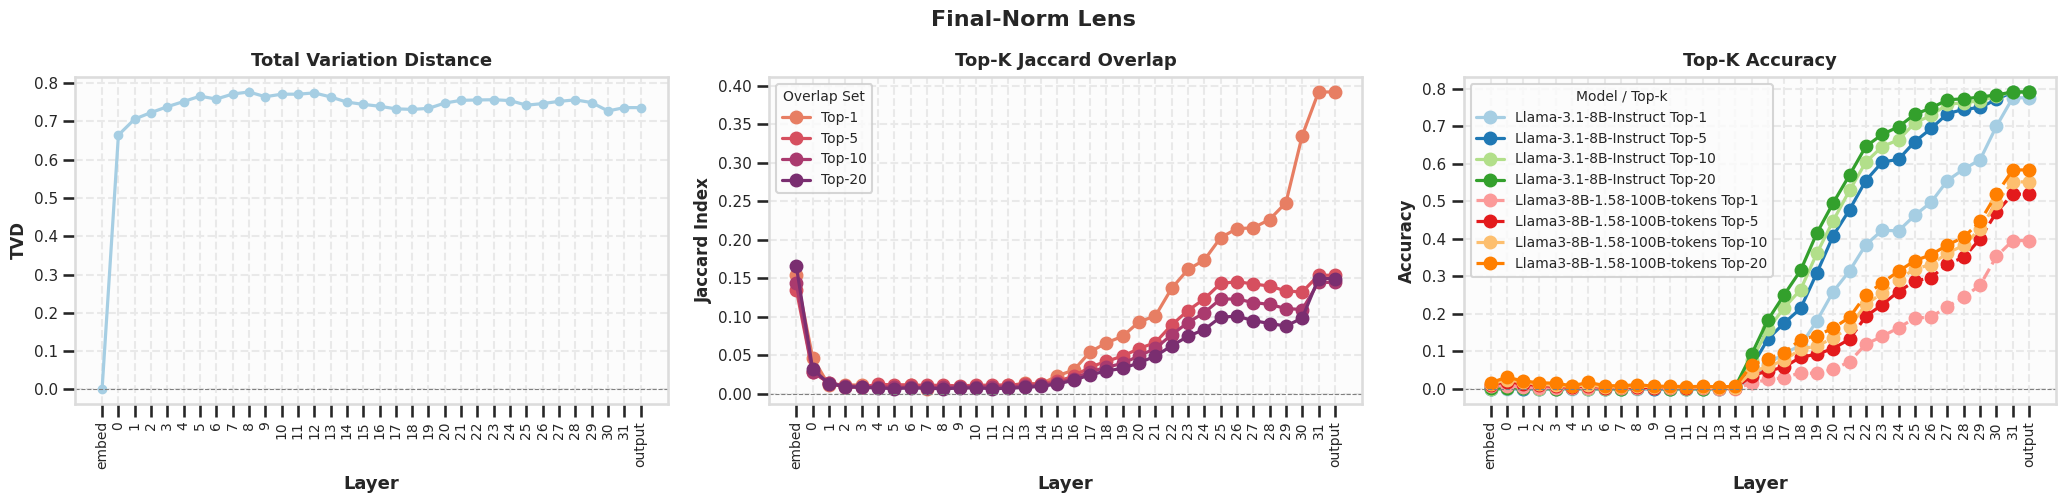

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

MODEL_NAME_A = "Llama-3.1-8B-Instruct"
MODEL_NAME_B = "Llama3-8B-1.58-100B-tokens"

METRIC_TITLES = {
    "vocab_tvd": "Total Variation Distance",
    "jaccard_topk": "Top-K Jaccard Overlap",
    "accuracy": "Top-K Accuracy",
}


def plot_summary_metrics(
    df,
    palette="Paired",
    save_path=None,
):
    """
    Plots vocab TVD, Jaccard overlaps, and both model accuracies (top-1, 5, 10, 20)
    across transformer layers for both models.
    """
    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    df = df.copy()

    # --- Layer labels and sort order ---
    def layer_label(x):
        x = x.lower()
        if "embed" in x:
            return "embed"
        elif "output" in x:
            return "output"
        elif "." in x:
            return x.split(".")[-1]
        else:
            return x

    def layer_sort_key(x):
        if x == "embed": return -1
        if x == "output": return 999
        try:
            return int(x)
        except ValueError:
            return 0

    df["layer_plot"] = df["layer_name"].apply(layer_label)
    df["layer_order"] = df["layer_plot"].map(layer_sort_key)
    df = df.groupby(["layer_plot", "layer_order"], as_index=False).mean(numeric_only=True)
    df = df.sort_values("layer_order")

    # --- Prepare subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    colors = sns.color_palette(palette, 8)

    # ----------------------------------------------------------
    # 1️⃣  Vocab TVD
    # ----------------------------------------------------------
    ax = axes[0]
    ax.plot(df["layer_plot"], df["vocab_tvd"], marker="o", markersize=6,
            linewidth=2.3, color=colors[0])
    ax.set_title(METRIC_TITLES["vocab_tvd"], fontsize=13, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax.set_ylabel("TVD", weight="semibold", fontsize=12)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=11)

    # ----------------------------------------------------------
    # 2️⃣  Jaccard overlaps (Top-k variants)
    # ----------------------------------------------------------
    ax = axes[1]
    topk_cols = [c for c in df.columns if c.startswith("jaccard@")]
    topk_cols = sorted(topk_cols, key=lambda c: int(c.split("@")[-1]))
    palette_jaccard = sns.color_palette("flare", len(topk_cols))

    for col, color in zip(topk_cols, palette_jaccard):
        k = col.split("@")[-1]
        label = f"Top-{k}"
        ax.plot(df["layer_plot"], df[col], marker="o", linewidth=2.3, color=color, label=label)

    ax.set_title(METRIC_TITLES["jaccard_topk"], fontsize=13, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax.set_ylabel("Jaccard Index", weight="semibold", fontsize=12)
    ax.legend(title="Overlap Set", fontsize=10, title_fontsize=10)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=11)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)

    # ----------------------------------------------------------
    # 3️⃣  Model accuracies (Top-1/5/10/20)
    # ----------------------------------------------------------
    ax = axes[2]
    acc_cols_A = sorted([c for c in df.columns if c.startswith("acc_A@")], key=lambda x: int(x.split("@")[-1]))
    acc_cols_B = sorted([c for c in df.columns if c.startswith("acc_B@")], key=lambda x: int(x.split("@")[-1]))

    for col in acc_cols_A:
        label = f"{MODEL_NAME_A} Top-{col.split('@')[-1]}"
        ax.plot(df["layer_plot"], df[col], marker="o", linewidth=2.3, label=label)

    for col in acc_cols_B:
        label = f"{MODEL_NAME_B} Top-{col.split('@')[-1]}"
        ax.plot(df["layer_plot"], df[col], marker="o", linewidth=2.3, linestyle="--", label=label)

    ax.set_title(METRIC_TITLES["accuracy"], fontsize=13, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax.set_ylabel("Accuracy", weight="semibold", fontsize=12)
    ax.legend(title="Model / Top-k", fontsize=10, title_fontsize=10, loc="upper left")
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=11)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    fig.suptitle("Final-Norm Lens", weight="bold", fontsize=16, y=1.02)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] → {save_path}")

    plt.show()

plot_summary_metrics(summary_rms, save_path="figs/unit_rms/ll_summary/ll_summary_unit_rms.png")

Final-norm Lens
Unit-RMS Lens

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

def compute_final_layer_correlations(df, acc_col="acc_B@1"):
    """
    Compute Spearman correlations between drift metrics (vs. base model)
    and Model B's Top-1 accuracy in the final layer only.
    """
    #warnings.filterwarnings("ignore", category=ConstantInputWarning)

    df = df.copy()
    df.columns = df.columns.astype(str)

    # --- Focus on final layer ---
    if "layer_name" not in df.columns:
        raise ValueError("DataFrame must include 'layer_name'.")
    final_layer = df["layer_name"].iloc[-1]
    df_final = df[df["layer_name"] == final_layer]

    if acc_col not in df_final.columns:
        raise ValueError(f"{acc_col} not found in DataFrame")

    # --- Identify metric columns (exclude metadata and accuracies) ---
    ignore_cols = {"prompt_id", "layer_index", "layer_name"}
    metric_cols = [c for c in df_final.columns
                   if c not in ignore_cols and not c.startswith("acc_")]

    results = []
    for metric in metric_cols:
        x = df_final[metric].dropna()
        y = df_final.loc[x.index, acc_col].dropna()
        aligned = pd.concat([x, y], axis=1, join="inner").dropna()

        if aligned.shape[0] <= 1 or aligned.iloc[:, 0].nunique() <= 1 or aligned.iloc[:, 1].nunique() <= 1:
            corr = np.nan
        else:
            corr, _ = spearmanr(aligned.iloc[:, 0], aligned.iloc[:, 1])

        results.append({
            "metric": metric,
            "corr": corr,
            "mean_acc": df_final[acc_col].mean()
        })

    df_corr = pd.DataFrame(results).sort_values("corr", ascending=False).reset_index(drop=True)
    df_corr["layer_name"] = final_layer
    return df_corr


In [29]:
raw_corr_df = compute_final_layer_correlations(summary_rms)

In [28]:
final_layer = summary_model["layer_name"].iloc[-1]
sub = summary_model[summary_model["layer_name"] == final_layer]

for col in ["min_prob_A", "min_prob_B", "agree@20"]:
    print(col, "unique values:", sub[col].nunique(), "min:", sub[col].min(), "max:", sub[col].max())


min_prob_A unique values: 1 min: 0.0 max: 0.0
min_prob_B unique values: 1 min: 0.0 max: 0.0
agree@20 unique values: 1 min: 0.0 max: 0.0


In [30]:
raw_corr_df

metric      corr  mean_acc layer_name
0   prob_mass_overlap@20  0.894187  0.395455     output
1               nll_diff  0.887934  0.395455     output
2              jaccard@1  0.846732  0.395455     output
3                agree@1  0.846732  0.395455     output
4    prob_mass_overlap@5  0.844162  0.395455     output
5    prob_mass_overlap@1  0.844162  0.395455     output
6             max_prob_B  0.844162  0.395455     output
7   prob_mass_overlap@10  0.831656  0.395455     output
8            mean_prob_B  0.800391  0.395455     output
9               ppl_diff  0.712848  0.395455     output
10       full_jaccard@20  0.531510  0.395455     output
11            jaccard@20  0.487738  0.395455     output
12                 iqr_B  0.431461  0.395455     output
13             jaccard@5  0.406449  0.395455     output
14        full_jaccard@1  0.375183  0.395455     output
15        full_jaccard@5  0.331412  0.395455     output
16                 ppl_A  0.325159  0.395455     output
17            max_prob_A  0.306400  0.395455     output
18            min_prob_A  0.287640  0.395455     output
19                 iqr_A  0.218857  0.395455     output
20       full_jaccard@10  0.212604  0.395455     output
21            jaccard@10  0.118808  0.395455     output
22       prob_overlap@20  0.093796  0.395455     output
23        prob_overlap@1  0.012506  0.395455     output
24        prob_overlap@5 -0.031265  0.395455     output
25       prob_overlap@10 -0.062531  0.395455     output
26               agree@5 -0.093326  0.395455     output
27              tail_A@1 -0.306400  0.395455     output
28            min_prob_B -0.325159  0.395455     output
29           mean_prob_A -0.331412  0.395455     output
30                heat_A -0.406449  0.395455     output
31              tail_A@5 -0.406449  0.395455     output
32             tail_A@20 -0.406449  0.395455     output
33             tail_A@10 -0.406449  0.395455     output
34              agree@10 -0.419079  0.395455     output
35                 kl_ba -0.675330  0.395455     output
36                 kl_ab -0.681583  0.395455     output
37                 ppl_B -0.712848  0.395455     output
38       target_prob_tvd -0.719101  0.395455     output
39      target_prob_diff -0.725354  0.395455     output
40               jsd_div -0.762873  0.395455     output
41             vocab_tvd -0.769126  0.395455     output
42              jsd_dist -0.844162  0.395455     output
43              tail_B@1 -0.844162  0.395455     output
44                heat_B -0.862921  0.395455     output
45   target_logprob_diff -0.887934  0.395455     output
46              tail_B@5 -0.894187  0.395455     output
47             tail_B@10 -0.894187  0.395455     output
48             tail_B@20 -0.894187  0.395455     output
49              agree@20       NaN  0.395455     output

In [27]:
summary_model.isna().sum()

layer_name              0
layer_index             0
kl_ab                   0
kl_ba                   0
jsd_div                 0
jsd_dist                0
vocab_tvd               0
heat_A                  0
heat_B                  0
iqr_A                   0
iqr_B                   0
mean_prob_A             0
mean_prob_B             0
max_prob_A              0
max_prob_B              0
min_prob_A              0
min_prob_B              0
target_prob_diff        0
target_prob_tvd         0
target_logprob_diff     0
nll_diff                0
ppl_A                   0
ppl_B                   0
ppl_diff                0
acc_A@1                 0
acc_B@1                 0
agree@1                 0
jaccard@1               0
full_jaccard@1          0
prob_overlap@1          0
prob_mass_overlap@1     0
tail_A@1                0
tail_B@1                0
acc_A@5                 0
acc_B@5                 0
agree@5                 0
jaccard@5               0
full_jaccard@5          0
prob_overlap

/tmp/ipykernel_11009/2994916025.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Top-{k}" for k in topks], y=rho_vals, palette="flare", ax=ax)


[saved] → figs/model/model_lw_correlation.png


<Figure size 640x480 with 0 Axes>

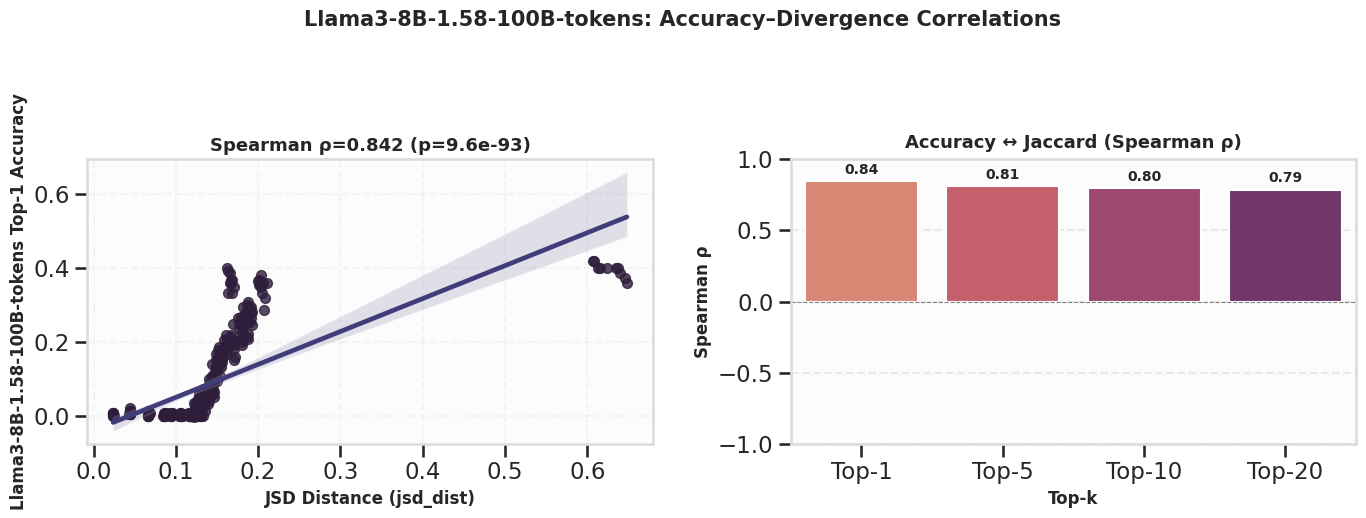

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
def plot_spearman_correlations(df, model_name_b="Llama3-8B-1.58-100B-tokens", palette="mako", save_path=None):
    """
    Plot two subplots showing Spearman correlations for model B:
    1️⃣ acc_B@1 vs jsd_dist
    2️⃣ acc_B@{1,5,10,20} vs jaccard@{1,5,10,20}
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    # Copy and prepare data
    df = df.copy()

    # Sort layers numerically for consistent x-axis order
    def layer_label(x):
        x = x.lower()
        if "embed" in x:
            return "e"
        elif "output" in x:
            return "o"
        elif "." in x:
            return x.split(".")[-1]
        else:
            return x

    def layer_sort_key(x):
        if x == "e": return -1
        if x == "o": return 999
        try:
            return int(x)
        except ValueError:
            return 0

    df["layer_plot"] = df["layer_name"].apply(layer_label)
    df["layer_order"] = df["layer_plot"].map(layer_sort_key)
    df = df.sort_values("layer_order")

    # --- Compute Spearman correlations per layer ---
    # (optional if you wanted per-layer correlations)
    # but for this we compute overall correlations

    # ------------------------------------------------------------
    #  Create subplots
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = sns.color_palette(palette, 6)

    # ------------------------------------------------------------
    # 1️⃣ Correlation: acc_B@1 vs jsd_dist
    # ------------------------------------------------------------
    ax = axes[0]
    x = df["jsd_dist"]
    y = df["acc_B@1"]
    rho, pval = spearmanr(x, y, nan_policy="omit")

    sns.regplot(x=x, y=y, scatter_kws={"s": 50, "alpha": 0.8}, line_kws={"color": colors[1]}, ax=ax)
    ax.set_title(f"Spearman ρ={rho:.3f} (p={pval:.2g})", fontsize=13, weight="semibold")
    ax.set_xlabel("JSD Distance (jsd_dist)", fontsize=12, weight="semibold")
    ax.set_ylabel(f"{model_name_b} Top-1 Accuracy", fontsize=12, weight="semibold")
    ax.grid(True, linestyle="--", alpha=0.4)

    # ------------------------------------------------------------
    # 2️⃣ Correlation: acc_B@k vs jaccard@k
    # ------------------------------------------------------------
    ax = axes[1]
    topks = [1, 5, 10, 20]
    rho_vals, p_vals = [], []

    for k in topks:
        acc_col = f"acc_B@{k}"
        jac_col = f"jaccard@{k}"
        if acc_col not in df.columns or jac_col not in df.columns:
            continue
        rho, pval = spearmanr(df[acc_col], df[jac_col], nan_policy="omit")
        rho_vals.append(rho)
        p_vals.append(pval)

    sns.barplot(x=[f"Top-{k}" for k in topks], y=rho_vals, palette="flare", ax=ax)
    ax.set_title(f"Accuracy ↔ Jaccard (Spearman ρ)", fontsize=13, weight="semibold", pad=8)
    ax.set_xlabel("Top-k", fontsize=12, weight="semibold")
    ax.set_ylabel("Spearman ρ", fontsize=12, weight="semibold")
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_ylim(-1, 1)
    for i, rho in enumerate(rho_vals):
        ax.text(i, rho + 0.05*np.sign(rho), f"{rho:.2f}", ha="center", fontsize=10, weight="semibold")

    plt.suptitle(f"{model_name_b}: Accuracy–Divergence Correlations", fontsize=15, weight="bold", y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] → {save_path}")

    plt.show()
plot_spearman_correlations(summary_model, save_path="figs/model/model_lw_correlation.png")

<Figure size 640x480 with 0 Axes>

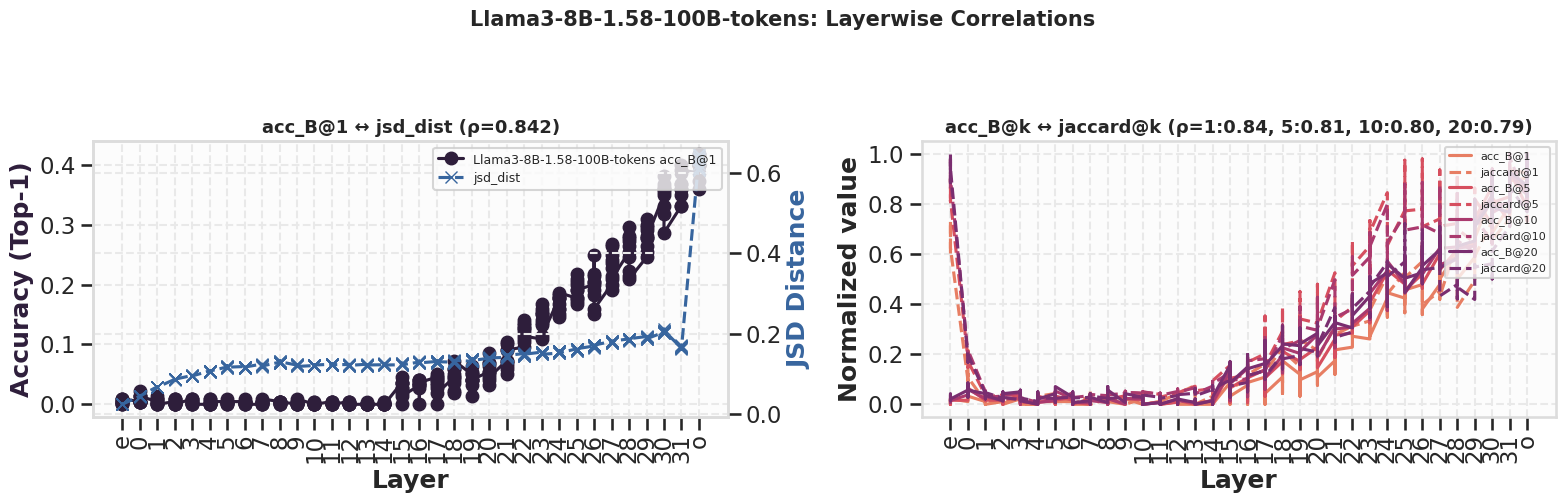

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr


def plot_layerwise_spearman(
    df,
    model_name_b="Llama3-8B-1.58-100B-tokens",
    palette="mako",
    save_path=None,
):
    """
    Creates two layerwise Spearman correlation plots:
    1️⃣ acc_B@1 vs jsd_dist
    2️⃣ acc_B@{1,5,10,20} vs jaccard@{1,5,10,20}
    Each plot shows per-layer correlation and the overall ρ in the title.
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    df = df.copy()

    # --- Layer sort logic (reuse same as your other plots) ---
    def layer_label(x):
        x = x.lower()
        if "embed" in x:
            return "e"
        elif "output" in x:
            return "o"
        elif "." in x:
            return x.split(".")[-1]
        else:
            return x

    def layer_sort_key(x):
        if x == "e": return -1
        if x == "o": return 999
        try:
            return int(x)
        except ValueError:
            return 0

    df["layer_plot"] = df["layer_name"].apply(layer_label)
    df["layer_order"] = df["layer_plot"].map(layer_sort_key)
    df = df.sort_values("layer_order").reset_index(drop=True)

    # --- Compute per-layer Spearman correlations ---
    layerwise = []

    for _, row in df.iterrows():
        layerwise.append({
            "layer_name": row["layer_name"],
            "layer_plot": row["layer_plot"],
            "layer_order": row["layer_order"],
            "acc_B@1": row["acc_B@1"],
            "jsd_dist": row["jsd_dist"],
            "acc_B@5": row.get("acc_B@5"),
            "acc_B@10": row.get("acc_B@10"),
            "acc_B@20": row.get("acc_B@20"),
            "jaccard@1": row.get("jaccard@1"),
            "jaccard@5": row.get("jaccard@5"),
            "jaccard@10": row.get("jaccard@10"),
            "jaccard@20": row.get("jaccard@20"),
        })

    df_lw = pd.DataFrame(layerwise)

    # --- Overall correlations (for annotation) ---
    overall_rho_jsd, _ = spearmanr(df_lw["acc_B@1"], df_lw["jsd_dist"], nan_policy="omit")

    rho_by_k = {}
    for k in [1, 5, 10, 20]:
        a = df_lw.get(f"acc_B@{k}")
        j = df_lw.get(f"jaccard@{k}")
        if a is not None and j is not None:
            rho, _ = spearmanr(a, j, nan_policy="omit")
            rho_by_k[k] = rho

    # --- Create subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    colors = sns.color_palette(palette, 6)

    # ------------------------------------------------------------
    # 1️⃣ acc_B@1 vs jsd_dist per layer
    # ------------------------------------------------------------
    ax = axes[0]
    ax.plot(df_lw["layer_plot"], df_lw["acc_B@1"], color=colors[0], label=f"{model_name_b} acc_B@1", marker="o")
    ax2 = ax.twinx()
    ax2.plot(df_lw["layer_plot"], df_lw["jsd_dist"], color=colors[2], linestyle="--", label="jsd_dist", marker="x")

    ax.set_xlabel("Layer", weight="semibold")
    ax.set_ylabel("Accuracy (Top-1)", color=colors[0], weight="semibold")
    ax2.set_ylabel("JSD Distance", color=colors[2], weight="semibold")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title(f"acc_B@1 ↔ jsd_dist (ρ={overall_rho_jsd:.3f})", fontsize=13, weight="semibold")

    # Legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=9)

    # ------------------------------------------------------------
    # 2️⃣ acc_B@k vs jaccard@k per layer
    # ------------------------------------------------------------
    ax = axes[1]
    palette_k = sns.color_palette("flare", 4)
    for k, c in zip([1, 5, 10, 20], palette_k):
        if f"acc_B@{k}" not in df_lw.columns or f"jaccard@{k}" not in df_lw.columns:
            continue
        # normalize both for visual comparison
        acc_norm = df_lw[f"acc_B@{k}"] / df_lw[f"acc_B@{k}"].max()
        jac_norm = df_lw[f"jaccard@{k}"] / df_lw[f"jaccard@{k}"].max()
        ax.plot(df_lw["layer_plot"], acc_norm, color=c, linestyle="-", label=f"acc_B@{k}")
        ax.plot(df_lw["layer_plot"], jac_norm, color=c, linestyle="--", label=f"jaccard@{k}")

    ax.set_xlabel("Layer", weight="semibold")
    ax.set_ylabel("Normalized value", weight="semibold")
    ax.tick_params(axis="x", rotation=90)
    rho_text = ", ".join([f"{k}:{rho_by_k[k]:.2f}" for k in rho_by_k])
    ax.set_title(f"acc_B@k ↔ jaccard@k (ρ={rho_text})", fontsize=13, weight="semibold")
    ax.legend(loc="upper right", fontsize=8)

    plt.suptitle(f"{model_name_b}: Layerwise Correlations", fontsize=15, weight="bold", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] → {save_path}")

    plt.show()
plot_layerwise_spearman(summary_model)

<Figure size 640x480 with 0 Axes>

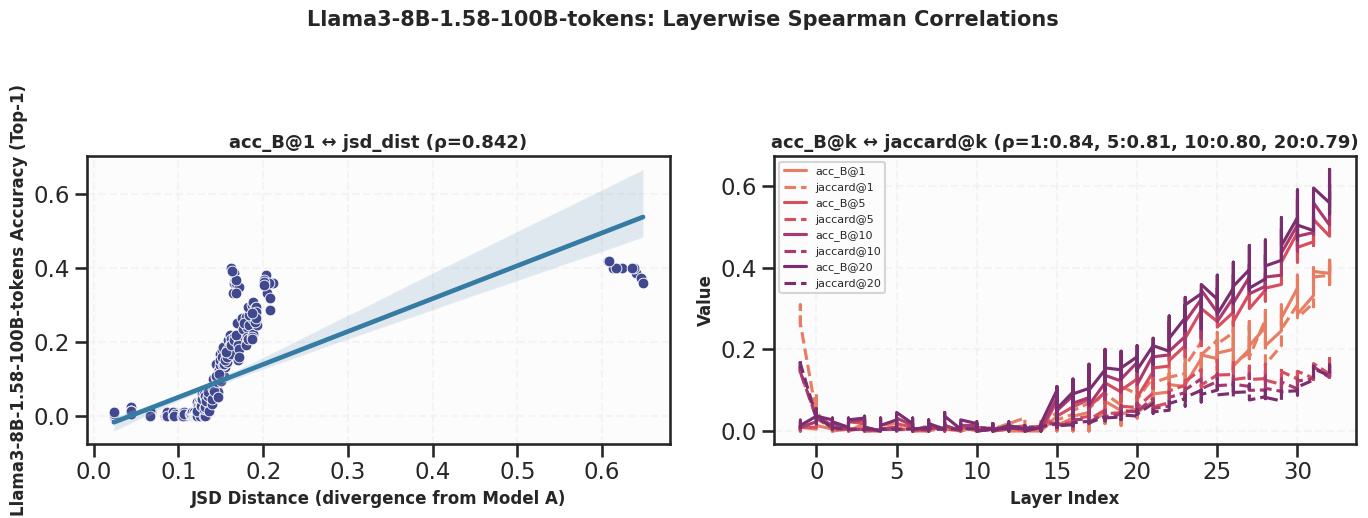

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def plot_layerwise_spearman_fixed(df, model_name_b="Llama3-8B-1.58-100B-tokens", palette="mako", save_path=None):
    """
    Plot layerwise scatter and correlation for:
      1️⃣ acc_B@1 vs jsd_dist
      2️⃣ acc_B@k vs jaccard@k (k = 1,5,10,20)
    Annotate each with Spearman ρ and correct visual alignment.
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={"axes.facecolor": "#fcfcfc", "grid.linestyle": "--", "grid.color": "#e9e9e9"},
    )
    sns.despine()

    df = df.copy().sort_values("layer_index")

    # compute correlations
    rho_jsd, p_jsd = spearmanr(df["acc_B@1"], df["jsd_dist"], nan_policy="omit")

    topks = [1, 5, 10, 20]
    rho_by_k = {}
    for k in topks:
        acc_col = f"acc_B@{k}"
        jac_col = f"jaccard@{k}"
        if acc_col in df.columns and jac_col in df.columns:
            rho, _ = spearmanr(df[acc_col], df[jac_col], nan_policy="omit")
            rho_by_k[k] = rho

    # ---------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = sns.color_palette(palette, 5)

    # ---------------------------------------------------
    # 1️⃣ acc_B@1 vs jsd_dist (scatter)
    # ---------------------------------------------------
    ax = axes[0]
    sns.scatterplot(x="jsd_dist", y="acc_B@1", data=df, s=60, color=colors[1], ax=ax)
    sns.regplot(x="jsd_dist", y="acc_B@1", data=df, scatter=False, color=colors[2], ax=ax)
    ax.set_title(f"acc_B@1 ↔ jsd_dist (ρ={rho_jsd:.3f})", fontsize=13, weight="semibold")
    ax.set_xlabel("JSD Distance (divergence from Model A)", fontsize=12, weight="semibold")
    ax.set_ylabel(f"{model_name_b} Accuracy (Top-1)", fontsize=12, weight="semibold")
    ax.grid(True, linestyle="--", alpha=0.4)

    # ---------------------------------------------------
    # 2️⃣ acc_B@k vs jaccard@k (layerwise lines)
    # ---------------------------------------------------
    ax = axes[1]
    palette_k = sns.color_palette("flare", 4)
    for k, c in zip(topks, palette_k):
        acc_col = f"acc_B@{k}"
        jac_col = f"jaccard@{k}"
        if acc_col in df.columns and jac_col in df.columns:
            ax.plot(df["layer_index"], df[acc_col], color=c, linestyle="-", label=f"acc_B@{k}")
            ax.plot(df["layer_index"], df[jac_col], color=c, linestyle="--", label=f"jaccard@{k}")

    rho_text = ", ".join([f"{k}:{rho_by_k[k]:.2f}" for k in rho_by_k])
    ax.set_title(f"acc_B@k ↔ jaccard@k (ρ={rho_text})", fontsize=13, weight="semibold")
    ax.set_xlabel("Layer Index", fontsize=12, weight="semibold")
    ax.set_ylabel("Value", fontsize=12, weight="semibold")
    ax.legend(fontsize=8, loc="best")
    ax.grid(True, linestyle="--", alpha=0.4)

    plt.suptitle(f"{model_name_b}: Layerwise Spearman Correlations", fontsize=15, weight="bold", y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] → {save_path}")

    plt.show()
plot_layerwise_spearman_fixed(summary_model)

[saved] → figs/non_param_rms/jsd_and_jaccard_model_correlation.png


<Figure size 640x480 with 0 Axes>

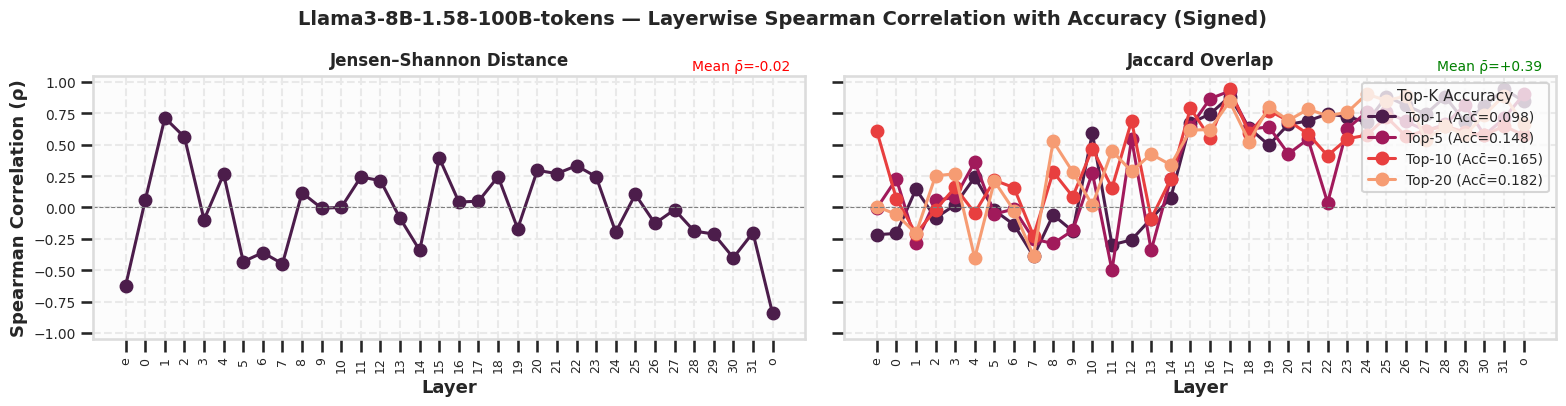

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# Model metadata
# -------------------------------
MODEL_NAME_A = "Llama-3.1-8B-Instruct"
MODEL_NAME_B = "Llama3-8B-1.58-100B-tokens"

METRIC_TITLES = {
    "jsd_dist": "Jensen–Shannon Distance (Model Divergence)",
    "jaccard": "Top-K Jaccard Overlap",
}

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, ConstantInputWarning
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# === Config ===
METRIC_TITLES = {
    "vocab_tvd": "Total Variation Distance",
    "jsd_div": "Jensen–Shannon Divergence",
    "jsd_dist": "Jensen–Shannon Distance",
    "iqr_B": "IQR",
    "target_logprob_diff": "Ground Truth Log-Likelihood Diff",
    "jaccard": "Jaccard Overlap",
    "full_jaccard": "Jaccard Similarity",
    "agree": "Top-K Agreement",
    "prob_overlap": "Probability Overlap",
    "prob_mass_overlap": "Probability Mass Overlap",
    "tail_B": "Llama3-8B-1.58-100B-tokens Tail Mass",
    # add more pretty names as needed
}

MODEL_NAME = "Llama3-8B-1.58-100B-tokens"

# -----------------------------
# Compute correlations function
# -----------------------------
def compute_layerwise_metric_correlations(df, acc_prefix="acc_B@1"):
    """
    Build per-layer Spearman correlations between metrics and accuracy.
    - If a metric has top-k variants (e.g. 'jaccard@5'), correlate each with acc_B@5.
    - If a metric does NOT have '@k' variants, correlate it with acc_B@1.
    Returns:
      df_corr: rows (layer_name, metric, topk, corr, mean_acc)
      mean_corr: rows (metric, topk, mean_corr) -> mean across layers
      mean_acc_by_topk: dict topk->mean accuracy (for legend)
    """
    warnings.filterwarnings("ignore", category=ConstantInputWarning)

    # Normalize column names as strings
    df = df.copy()
    df.columns = df.columns.astype(str)

    # Identify available topk levels (integers) from acc_B@*
    topk_cols = sorted([c for c in df.columns if c.startswith("acc_B@")])
    topks = sorted({int(c.split("@")[-1]) for c in topk_cols})  # e.g. [1,5,10,20]

    # mean accuracy per topk for annotation/legend
    mean_acc_by_topk = {}
    for k in topks:
        col = f"acc_B@{k}"
        if col in df.columns:
            vals = df[col].dropna()
            mean_acc_by_topk[k] = float(vals.mean()) if not vals.empty else 0.0
        else:
            mean_acc_by_topk[k] = 0.0

    # Build mapping metric_base -> set(topks)
    metric_topk_map = {}
    for c in df.columns:
        if "@" in c:
            base, k = c.split("@", 1)
            if base not in metric_topk_map:
                metric_topk_map[base] = set()
            try:
                metric_topk_map[base].add(int(k))
            except Exception:
                # ignore non-numeric suffixes
                pass
        else:
            if c not in metric_topk_map:
                # ensure base present (non-topk metrics)
                metric_topk_map.setdefault(c, set())

    # exclude non-metrics
    ignore_cols = {"prompt_id", "layer_index", "layer_name"}
    for ic in list(ignore_cols):
        metric_topk_map.pop(ic, None)

    results = []
    layers = sorted(df["layer_name"].unique())

    for layer in layers:
        sub = df[df["layer_name"] == layer]
        if sub.shape[0] == 0:
            continue

        for metric_base, ks in metric_topk_map.items():
            if len(ks) > 0:
                # metric has top-k variants => compute per-k correlations with matching acc_B@k
                for k in sorted(ks):
                    mcol = f"{metric_base}@{k}"
                    acccol = f"acc_B@{k}"
                    if mcol not in sub.columns or acccol not in sub.columns:
                        continue
                    x = sub[mcol].dropna()
                    y = sub.loc[x.index, acccol].dropna()
                    # ensure same indices; if mismatch, align
                    if len(x) == 0 or len(y) == 0:
                        corr = float("nan")
                    else:
                        # align indices
                        aligned = pd.concat([x, y], axis=1, join="inner").dropna()
                        if aligned.shape[0] <= 1 or aligned.iloc[:,0].nunique() <= 1 or aligned.iloc[:,1].nunique() <= 1:
                            corr = float("nan")
                        else:
                            corr, _ = spearmanr(aligned.iloc[:,0], aligned.iloc[:,1])
                    results.append({
                        "layer_name": layer,
                        "metric": metric_base,
                        "topk": int(k),
                        "corr": float(corr) if not pd.isna(corr) else np.nan,
                        "mean_acc": mean_acc_by_topk.get(int(k), 0.0)
                    })
            else:
                # metric has no topk variants -> correlate with acc_B@1
                mcol = metric_base
                acccol = "acc_B@1"
                if mcol not in sub.columns or acccol not in sub.columns:
                    continue
                x = sub[mcol].dropna()
                y = sub.loc[x.index, acccol].dropna()
                if len(x) == 0 or len(y) == 0:
                    corr = float("nan")
                else:
                    aligned = pd.concat([x, y], axis=1, join="inner").dropna()
                    if aligned.shape[0] <= 1 or aligned.iloc[:,0].nunique() <= 1 or aligned.iloc[:,1].nunique() <= 1:
                        corr = float("nan")
                    else:
                        corr, _ = spearmanr(aligned.iloc[:,0], aligned.iloc[:,1])
                results.append({
                    "layer_name": layer,
                    "metric": metric_base,
                    "topk": 1,
                    "corr": float(corr) if not pd.isna(corr) else np.nan,
                    "mean_acc": mean_acc_by_topk.get(1, 0.0)
                })

    df_corr = pd.DataFrame(results)

    # produce mean_corr aggregated by metric+topk (no family aggregation)
    mean_corr = (
        df_corr.groupby(["metric", "topk"], dropna=False)["corr"]
        .mean(numeric_only=True)
        .reset_index()
        .rename(columns={"corr": "mean_corr"})
    )

    return df_corr, mean_corr, mean_acc_by_topk
# -------------------------------
# Plot function
# -------------------------------
def plot_topk_internal_correlations_signed(
    df_corr,
    mean_corr,
    metrics,
    model_name=MODEL_NAME_B,   # <–– display the model name in title
    mean_acc_by_topk=None,
    #palette="icefire",         # diverging palette highlights +/− correlations
    palette="rocket",  
    title_gap=0.92,
    save_path=None,
):
    """
    Plot layerwise Spearman correlations (ρ) for selected metrics vs. accuracy.
    - Preserves signed correlation
    - Color-codes positive/negative
    - Annotates each subplot with overall mean correlation
    """
    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    df_corr = df_corr.copy()
    df_corr["topk"] = df_corr["topk"].astype(int)

    if isinstance(metrics, str):
        metrics = [metrics]
    metrics = list(metrics)

    topks = sorted(df_corr["topk"].unique())
    n_metrics = len(metrics)
    #fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 5), sharey=True)
    fig, axes = plt.subplots(1, n_metrics, figsize=(8 * n_metrics, 4.5), sharey=True)
    if n_metrics == 1:
        axes = [axes]

    palette_list = sns.color_palette(palette, n_colors=max(4, len(topks)))

    for ax, metric in zip(axes, metrics):
        df_metric = df_corr[df_corr["metric"] == metric].copy()
        if df_metric.empty:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center")
            continue

        # --- Sort layers consistently
        df_metric["layer_plot"] = df_metric["layer_name"].apply(
            lambda x: "e" if "embed" in x.lower()
            else ("o" if "output" in x.lower()
                  else x.split(".")[-1] if "." in x else x)
        )
        def layer_sort_key(x):
            if x == "e": return -1
            if x == "o": return 999
            try: return int(x)
            except: return 0
        df_metric = df_metric.sort_values(by="layer_plot", key=lambda c: c.map(layer_sort_key))

        # --- Plot each Top-K correlation curve
        for i, k in enumerate(topks):
            sub = df_metric[df_metric["topk"] == k]
            if sub.empty:
                continue
            mean_acc = mean_acc_by_topk.get(k) if mean_acc_by_topk else None
            label = f"Top-{k}" + (f" (Acc̄={mean_acc:.3f})" if mean_acc else "")
            color = palette_list[i % len(palette_list)]

            ax.plot(
                sub["layer_plot"],
                sub["corr"],
                marker="o",
                label=label,
                linewidth=2.2,
                color=color,
            )

        # --- Titles & axes
        pretty = METRIC_TITLES.get(metric, metric.replace("_", " ").title())
        ax.set_title(pretty, fontsize=12, weight="semibold", pad=8)
        ax.set_xlabel("Layer", weight="semibold", fontsize=13)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_ylim(-1.05, 1.05)
        ax.set_xticks(range(len(df_metric["layer_plot"].unique())))
        ax.set_xticklabels(df_metric["layer_plot"].unique(), rotation=90, fontsize=9)
        ax.tick_params(axis='y', labelsize=10)
        if ax == axes[0]:
            ax.set_ylabel("Spearman Correlation (ρ)", weight="semibold", fontsize=13)

        # --- Annotate mean correlation (colored by sign)
        g_spearman = mean_corr.loc[mean_corr["metric"] == metric, "mean_corr"].mean()
        if not pd.isna(g_spearman):
            color = "red" if g_spearman < 0 else "green"
            ax.text(
                0.98, 1.02,
                f"Mean ρ̄={g_spearman:+.2f}",
                transform=ax.transAxes,
                ha="right",
                fontsize=10,
                color=color,
                weight="medium",
            )

    # --- Legend + global title
    axes[-1].legend(title="Top-K Accuracy", loc="upper right", fontsize=10, title_fontsize=11)
    fig.suptitle(
        f"{model_name} — Layerwise Spearman Correlation with Accuracy (Signed)",
        fontsize=14,
        weight="bold",
        y=title_gap,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] → {save_path}")
    plt.show()

df_corr_all, mean_corr, mean_acc_by_topk = compute_layerwise_metric_correlations(summary_model)

plot_topk_internal_correlations_signed(
    df_corr_all,
    mean_corr,
    metrics=["jsd_dist", "jaccard"],
    model_name=MODEL_NAME_B,
    mean_acc_by_topk=mean_acc_by_topk,
    save_path="figs/non_param_rms/jsd_and_jaccard_model_correlation.png"
)



In [ ]:
from transformers import AutoTokenizer

tok_a = AutoTokenizer.from_pretrained(Models.LAIN8B.value)
tok_b = AutoTokenizer.from_pretrained(Models.HF100B.value)

print("Tokenizer A vocab size:", len(tok_a))
print("Tokenizer B vocab size:", len(tok_b))

shared = set(tok_a.get_vocab().keys()) & set(tok_b.get_vocab().keys())
unique_a = set(tok_a.get_vocab().keys()) - set(tok_b.get_vocab().keys())
unique_b = set(tok_b.get_vocab().keys()) - set(tok_a.get_vocab().keys())

print(f"Shared tokens: {len(shared)}")
print(f"Unique to A: {len(unique_a)} | Unique to B: {len(unique_b)}")

mismatches = []
for token, id_a in tok_a.get_vocab().items():
    id_b = tok_b.get_vocab().get(token, None)
    if id_b is not None and id_a != id_b:
        mismatches.append((token, id_a, id_b))
    if len(mismatches) > 10:
        break

if not mismatches:
    print("Token IDs aligned between tokenizers!")
else:
    print("Some token ID mismatches found:")
    for token, id_a, id_b in mismatches[:5]:
        print(f"  '{token}': A={id_a}, B={id_b}")

# Comparison Results Analysis

## Heatmap Plotter

In [1]:
import torch
from transformers import AutoTokenizer

raw = "raw"
norm = "norm"
unit_rms = "unit_rms"
batch_num = "000"
model = "non_param_rms"
# Load normalized lens comparison data:
topk_data = torch.load(
    f"logs/new_model_lens/topks/{model}/{model}_{batch_num}.pt",
    weights_only=False 
)

In [ ]:
# NOTE: BOS (beginning-of-sequence) token handling
#
# We retain the BOS token in the logit lens analysis because it encodes the model's
# initial internal state before any contextual input is processed.
# Divergence patterns at this position often reveal how quantization or fine-tuning
# affects early-layer activations and scaling, even before text content appears.
#
# However, the BOS token is excluded (masked) from all predictive metrics such as
# accuracy, NLL, or top-k agreement, since no token is predicted *before* BOS.
#
# In short:
# - BOS is kept for representational and divergence analysis.
# - BOS is masked out for predictive or target-based comparisons.
#
# This distinction allows us to observe early activation drift without contaminating
# metrics that depend on next-token predictions.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def pretty_layer_name(raw_name: str) -> str:
    """
    Convert raw layer names like:
        "layer_12", "layer.12.mlp", "layer_7.self_attn"
    into pretty printable labels like:
        "Layer 13", "Layer 13 · MLP", "Layer 8 · Attention"
    """
    # Embedding and output special cases
    if raw_name in {"embed_tokens", "embedding"}:
        return "Embedding"
    if raw_name in {"output", "lm_head"}:
        return "Output"

    # Normalize separators for consistent parsing
    name = raw_name.replace("_", ".")  

    # Split and detect indices + subcomponents
    parts = name.split(".")
    if len(parts) == 1:
        return raw_name  # fallback for unknown patterns

    layer_idx = None
    sub_name = None

    # Find the numeric layer index and optional subcomponent
    for p in parts:
        if p.isdigit():
            layer_idx = int(p)
        elif any(s in p for s in ["attn", "mlp", "block"]):
            sub_name = p

    if layer_idx is None:
        return raw_name

    # Construct readable name
    base = f"Layer {layer_idx + 1}"  # +1 for human-friendly indexing
    if sub_name is None:
        return base
    elif "attn" in sub_name:
        return f"{base} · Attention"
    elif "mlp" in sub_name:
        return f"{base} · MLP"
    elif "block" in sub_name:
        return f"{base} · Block"
    else:
        return f"{base} · {sub_name}"



def plot_heatmap(data, tokenizer, prompt_id=0, mask_ids=[128000, 128009],
                     token_maxlen=20, x_per_col=0.9, y_per_row=0.35,
                     metric="jsd_div", color_map="coolwarm", title="Jensen-Shannon divergence",
                     save_path=None):

    rows = [r for r in data if r["prompt_id"] == prompt_id]
    rows = sorted(rows, key=lambda r: r["layer_index"])

    input_ids = torch.tensor(rows[0]["input_ids"], device="cpu")
    target_ids = torch.tensor(rows[0]["targets"], device="cpu")

    min_len = min(len(input_ids), len(target_ids))
    input_ids = input_ids[:min_len]
    target_ids = target_ids[:min_len]

    mask_ids = [tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id]
    mask_ids = [mid for mid in mask_ids if mid is not None]

    for r in data:
        if "targets" in r and r["targets"] is not None and torch.is_tensor(r["targets"]):
            device = r["targets"].device
            mask = ~torch.isin(r["targets"], torch.tensor(mask_ids, device=device))
            for m in ["kl_ab", "kl_ba", "jsd_div", "jsd_dist", "vocab_tvd"]:
                if m in r and isinstance(r[m], torch.Tensor):
                    val = r[m]
                    # Handle 2D vs 1D tensors safely
                    if val.ndim == 2 and val.size(0) == 1:
                        val = val.squeeze(0)
                    if val.shape[-1] == mask.shape[0]:
                        val[~mask] = float("nan")
                    r[m] = val



    keep_mask = torch.ones_like(target_ids, dtype=torch.bool)
    for mid in mask_ids:
        keep_mask &= (target_ids != mid)

    input_ids = input_ids[keep_mask].tolist()
    target_ids = target_ids[keep_mask].tolist()


    def dec(tid):
        s = tokenizer.decode([tid]).replace("\n", " ")
        return (s[:token_maxlen] + "…") if len(s) > token_maxlen else s

    input_tokens  = [dec(tid) for tid in input_ids]
    target_tokens = [dec(tid) for tid in target_ids]

    matrix = torch.stack([r[metric][keep_mask] for r in rows]).cpu().numpy()
    n_rows, n_cols = matrix.shape

    # Opt for resacling for including subblocks: y_per_row = 0.25 if any("·" in pretty_layer_name(r["layer_name"]) for r in rows) else 0.35

    fig, ax = plt.subplots(figsize=(max(6, n_cols * x_per_col), max(3, n_rows * y_per_row)),
                           constrained_layout=True)

    im = sns.heatmap(
        matrix,
        cmap=color_map,
        cbar=True,
        annot=True,          
        xticklabels=False,   
        yticklabels=[pretty_layer_name(r["layer_name"]) for r in rows]
    )

    centers = np.arange(n_cols) + 0.5
    ax.set_xlim(0, n_cols)              
    ax.set_xticks(centers)
    ax.set_xticklabels(input_tokens, rotation=90, ha="center", fontsize=9)

    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(centers)
    ax_top.set_xticklabels(target_tokens, rotation=90, ha="center", fontsize=8)
    ax_top.set_xlabel("Target tokens")

    ax.invert_yaxis()               
    ax.set_aspect("auto")      
    ax.set_xlabel("Input tokens")
    ax.set_ylabel("Layers")
    #ax.set_title(f"{title} prompt {prompt_id}" if title is not None  else "")
    ax.set_title(f"{title}" if title is not None  else "")

    plt.subplots_adjust(bottom=0.25, top=0.85)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

In [3]:
from enum import Enum

class Metric(Enum):
    KLDIV_PQ = "kl_ab"
    KLDIV_QP = "kl_ba"
    PROB_DIFF = "target_prob_diff"
    LOG_DIFF = "target_logprob_diff"
    NLL_DIFF = "nll_diff"
    V_TVD = "vocab_tvd"
    V_NWD = "vocab_nwd"
    JSD_DIV = "jsd_div"
    JSD_DIST = "jsd_dist"

class Color(Enum):
    KL_DIV = "icefire"
    LOG_NLL_DIFF = "vlag"
    VIR = "viridis"
    V_TVD = "magma"
    JSD = "rocket_r"
    V_NWD = "mako"
    FLARE = "flare"

class TitlesNorm(Enum):
    KLDIV_PQ = "Model Lens Kullback–Leibler Divergence (P∥Q)"
    KLDIV_QP = "Model Lens Kullback–Leibler Divergence (Q∥P)"
    PROB_DIFF = "Model Lens Ground Truth Probability Diff"
    LOG_DIFF = "Model Lens Ground Truth Log-Likelihood Diff"
    NLL_DIFF = "Model Lens Ground Truth NLL Diff"
    V_TVD = "Model Lens Total Variation Distance"
    V_NWD = "Model Lens Normalized Wasserstein Distance"
    JSD_DIV = "Model Lens Jensen–Shannon Divergence"
    JSD_DIST = "Model Lens Jensen–Shannon Distance"

class TitlesRMS(Enum):
    KLDIV_PQ = "Unit-RMS Lens Kullback–Leibler Divergence (P∥Q)"
    KLDIV_QP = "Unit-RMS Lens Kullback–Leibler Divergence (Q∥P)"
    PROB_DIFF = "Unit-RMS Lens Ground Truth Probability Diff"
    LOG_DIFF = "Unit-RMS Lens Ground Truth Log-Likelihood Diff"
    NLL_DIFF = "Unit-RMS Lens Ground Truth NLL Diff"
    V_TVD = "Unit-RMS Lens Total Variation Distance"
    V_NWD = "Unit-RMS Lens Normalized Wasserstein Distance"
    JSD_DIV = "Unit-RMS Lens Jensen–Shannon Divergence"
    JSD_DIST = "Unit-RMS Lens Jensen–Shannon Distance"

class TitlesRaw(Enum):
    KLDIV_PQ = "Final-Norm Lens Kullback–Leibler Divergence (P∥Q)"
    KLDIV_QP = "Final-Norm Lens Kullback–Leibler Divergence (Q∥P)"
    PROB_DIFF = "Final-Norm Lens Ground Truth Probability Diff"
    LOG_DIFF = "Final-Norm Lens Ground Truth Log-Likelihood Diff"
    NLL_DIFF = "Final-Norm Lens Ground Truth NLL Diff"
    V_TVD = "Final-Norm Lens Total Variation Distance"
    V_NWD = "Final-Norm Lens Normalized Wasserstein Distance"
    JSD_DIV = "Final-Norm Lens Jensen–Shannon Divergence"
    JSD_DIST = "Final-Norm Lens Jensen–Shannon Distance"

tokenizer = AutoTokenizer.from_pretrained("Models/LLaMA3Instruct")

/tmp/ipykernel_12930/2286302324.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(rows[0]["input_ids"], device="cpu")
/tmp/ipykernel_12930/2286302324.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(rows[0]["targets"], device="cpu")
/tmp/ipykernel_12930/2286302324.py:139: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.25, top=0.85)


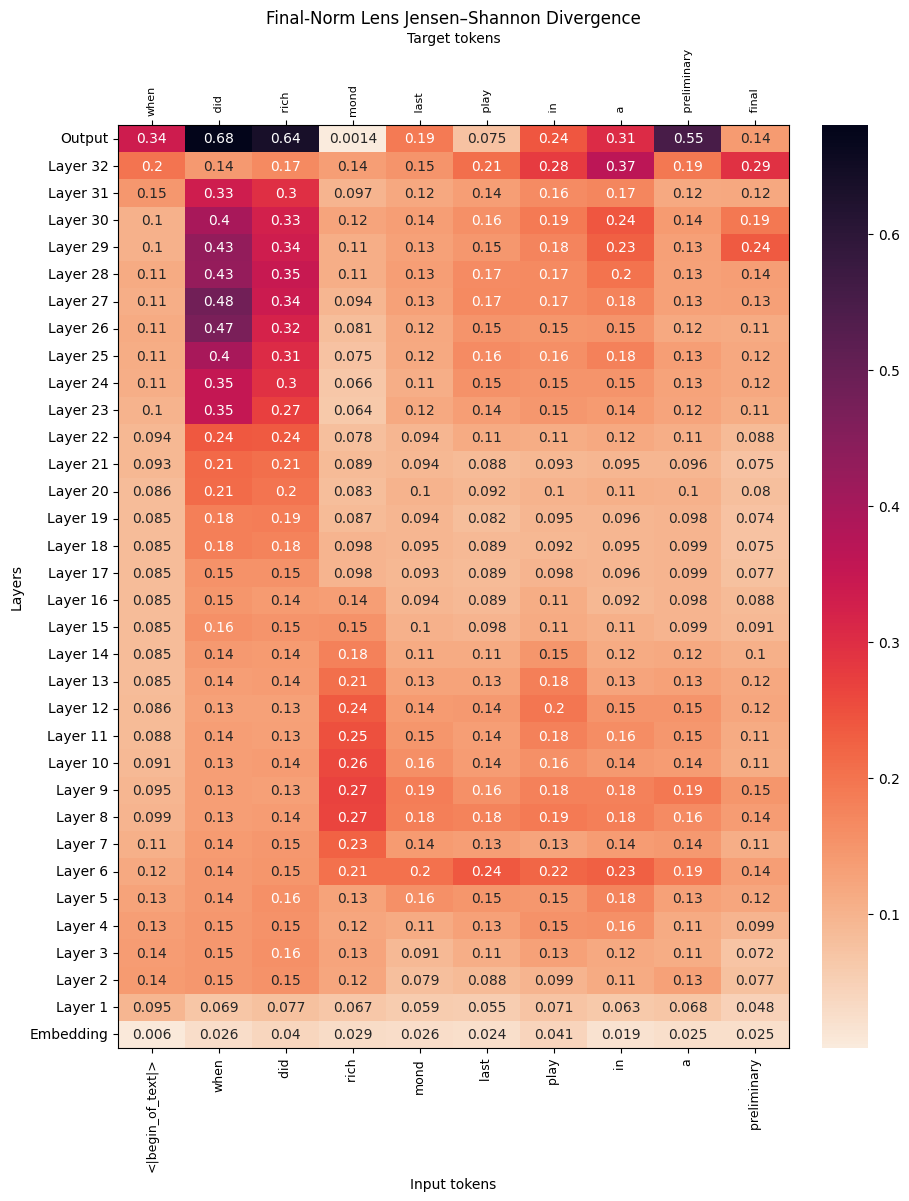

In [6]:
metric = Metric.JSD_DIV.value
lens_type = "non_param_rms" # unit_rms, raw
data = topk_data
fig_path = f"figs/{lens_type}/heatmaps/{metric}_{lens_type}.png"
plot_heatmap(
    data, tokenizer, prompt_id=0,
    metric=metric, color_map=Color.JSD.value,
    title=TitlesRaw.JSD_DIV.value,
    save_path=fig_path
)

In [ ]:
topk_data

## Normalized Lens Analysis

In [ ]:
import pandas as pd
import glob
import os

def load_all_summaries(base_dir, lens_type, pattern="summary_nq_200_batch*.parquet"):
    """Load and concatenate all batch summaries for a given lens type."""
    path = os.path.join(base_dir, f"batch_{lens_type}", pattern)
    files = sorted(glob.glob(path))
    if not files:
        raise FileNotFoundError(f"No parquet files found for pattern: {path}")

    dfs = [pd.read_parquet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(files)} files for {lens_type} ({len(df)} rows total).")
    return df


In [ ]:
base_dir = "logs/results_summary"
summary_raw  = load_all_summaries(base_dir, "raw")
#summary_norm = load_all_summaries(base_dir, "norm")
#summary_rms = load_all_summaries(base_dir, "unit_rms")

In [ ]:
summary_raw

In [ ]:
summary_raw.tail(20)

In [ ]:
summary_raw.columns

In [ ]:
from scipy.stats import spearmanr, ConstantInputWarning
import warnings
import pandas as pd

def compute_layerwise_metric_correlations(df):
    """
    Correlate each metric with the correct Top-K accuracy.

    - Metrics like vocab_tvd, kl_ab, iqr_B -> acc_B@1
    - Metrics like jaccard@5, prob_overlap@10 -> acc_B@5 or acc_B@10
    Keeps mean accuracy per top-k for plot annotations.
    """

    warnings.filterwarnings("ignore", category=ConstantInputWarning)
    results = []

    # Identify available top-k levels numerically
    topks = sorted({int(c.split("@")[-1]) for c in df.columns if c.startswith("acc_B@")})
    layers = df["layer_name"].unique()

    # Compute mean accuracy per top-k (for later legend annotations)
    mean_acc_by_topk = {}
    for k in topks:
        acc_col = f"acc_B@{k}"
        if acc_col in df.columns:
            vals = df[acc_col].dropna()
            mean_acc_by_topk[k] = vals.mean() if not vals.empty else 0.0
        else:
            mean_acc_by_topk[k] = 0.0

    # Identify all metric base names (both top-k and non top-k)
    all_metrics = set()
    for col in df.columns:
        if col.startswith(("acc_A@", "acc_B@", "agree@", "jaccard@", "full_jaccard@", "prob_overlap@", "prob_mass_overlap@", "tail_A@")):
            continue
        if "@" in col:
            all_metrics.add(col.split("@")[0])
        elif col not in ["prompt_id", "layer_index", "layer_name"]:
            all_metrics.add(col)
    all_metrics = sorted(all_metrics)

    # ---- compute layerwise correlations ----
    for layer in layers:
        sub = df[df["layer_name"] == layer]
        for metric in all_metrics:
            # if metric has top-k versions → correlate with acc_B@k
            has_topk = any(f"{metric}@{k}" in df.columns for k in topks)
            if has_topk:
                for k in topks:
                    m_col = f"{metric}@{k}"
                    acc_col = f"acc_B@{k}"
                    if m_col not in sub.columns or acc_col not in sub.columns:
                        continue
                    if sub[m_col].nunique() <= 1 or sub[acc_col].nunique() <= 1:
                        corr = float("nan")
                    else:
                        corr, _ = spearmanr(sub[m_col], sub[acc_col])
                    results.append({
                        "layer_name": layer,
                        "metric": metric,
                        "topk": k,
                        "corr": corr,
                        "mean_acc": mean_acc_by_topk.get(k, 0.0)
                    })
            else:
                acc_col = "acc_B@1"
                if metric not in sub.columns or acc_col not in sub.columns:
                    continue
                if sub[metric].nunique() <= 1 or sub[acc_col].nunique() <= 1:
                    corr = float("nan")
                else:
                    corr, _ = spearmanr(sub[metric], sub[acc_col])
                results.append({
                    "layer_name": layer,
                    "metric": metric,
                    "topk": 1,
                    "corr": corr,
                    "mean_acc": mean_acc_by_topk.get(1, 0.0)
                })

    df_corr = pd.DataFrame(results)

    mean_corr = (
        df_corr.groupby(["metric", "topk"], dropna=False)["corr"]
        .mean(numeric_only=True)
        .reset_index()
        .rename(columns={"corr": "mean_corr"})
    )

    return df_corr, mean_corr



df_corr_all, mean_corr = compute_layerwise_metric_correlations(summary_norm)

In [ ]:
import warnings
import pandas as pd
from scipy.stats import spearmanr, ConstantInputWarning

warnings.filterwarnings("ignore", category=ConstantInputWarning)


def compute_layerwise_metric_correlations(df):
    """
    Compute layerwise Spearman correlations between each metric and the matching Top-K accuracy.

    Rules:
      - If metric has top-k versions (e.g. `jaccard@5`, `prob_overlap@10`), correlate each `metric@k`
        with `acc_B@k`.
      - If metric does NOT have top-k versions (e.g. `vocab_tvd`, `jsd_div`), correlate with `acc_B@1`.
    Returns:
      df_corr: rows with columns ['layer_name', 'metric', 'topk', 'corr', 'mean_acc']
      mean_corr: aggregated mean correlation by ['metric', 'topk'] with column 'mean_corr'
      mean_acc_by_topk: dict mapping topk -> mean acc_B@k (float)
    """
    df = df.copy()

    # find available top-k levels from acc_B@* columns (as ints)
    topk_cols = [c for c in df.columns if c.startswith("acc_B@")]
    topks = sorted({int(c.split("@")[-1]) for c in topk_cols})

    # compute mean accuracy per top-k for legend/annotation
    mean_acc_by_topk = {}
    for k in topks:
        col = f"acc_B@{k}"
        if col in df.columns:
            vals = df[col].dropna()
            mean_acc_by_topk[k] = float(vals.mean()) if not vals.empty else 0.0
        else:
            mean_acc_by_topk[k] = 0.0

    # identify metrics to correlate (exclude prompt/layer and acc columns)
    ignore_prefixes = ("acc_A@", "acc_B@",)
    ignore_cols = {"prompt_id", "layer_index", "layer_name"}
    candidate_metrics = []
    for c in df.columns:
        if c in ignore_cols:
            continue
        if any(c.startswith(p) for p in ignore_prefixes):
            continue
        candidate_metrics.append(c)
    candidate_metrics = sorted(candidate_metrics)

    # Build set of metric base names (e.g. "jaccard" from "jaccard@5")
    metric_bases = set()
    for c in candidate_metrics:
        if "@" in c:
            metric_bases.add(c.split("@")[0])
        else:
            metric_bases.add(c)
    metric_bases = sorted(metric_bases)

    rows = []
    layers = df["layer_name"].unique()

    for layer in layers:
        sub = df[df["layer_name"] == layer]
        if sub.empty:
            continue
        for metric in metric_bases:
            # does this metric have top-k variants?
            has_topk_variants = any(f"{metric}@{k}" in df.columns for k in topks)

            if has_topk_variants:
                for k in topks:
                    m_col = f"{metric}@{k}"
                    acc_col = f"acc_B@{k}"
                    if m_col not in sub.columns or acc_col not in sub.columns:
                        continue
                    x = sub[m_col].dropna()
                    y = sub.loc[x.index, acc_col]  # align indices
                    # require >1 unique value to compute spearman
                    if x.nunique() <= 1 or y.nunique() <= 1 or len(x) < 2:
                        corr = float("nan")
                    else:
                        try:
                            corr, _ = spearmanr(x, y)
                        except Exception:
                            corr = float("nan")
                    rows.append({
                        "layer_name": layer,
                        "metric": metric,
                        "topk": int(k),
                        "corr": float(corr) if not pd.isna(corr) else float("nan"),
                        "mean_acc": mean_acc_by_topk.get(int(k), float("nan")),
                    })
            else:
                # correlate metric (no @k) with acc_B@1
                acc_col = "acc_B@1"
                m_col = metric
                if m_col not in sub.columns or acc_col not in sub.columns:
                    continue
                x = sub[m_col].dropna()
                y = sub.loc[x.index, acc_col]
                if x.nunique() <= 1 or y.nunique() <= 1 or len(x) < 2:
                    corr = float("nan")
                else:
                    try:
                        corr, _ = spearmanr(x, y)
                    except Exception:
                        corr = float("nan")
                rows.append({
                    "layer_name": layer,
                    "metric": metric,
                    "topk": 1,
                    "corr": float(corr) if not pd.isna(corr) else float("nan"),
                    "mean_acc": mean_acc_by_topk.get(1, float("nan")),
                })

    df_corr = pd.DataFrame(rows)

    # Mean correlation per metric & topk (metric-level mean across layers)
    mean_corr = (
        df_corr
        .groupby(["metric", "topk"], dropna=False)["corr"]
        .mean(numeric_only=True)
        .reset_index()
        .rename(columns={"corr": "mean_corr"})
    )

    return df_corr, mean_corr, mean_acc_by_topk
df_corr_all, mean_corr,mean_acc_by_topk = compute_layerwise_metric_correlations(summary_norm)

In [ ]:
from scipy.stats import spearmanr, ConstantInputWarning
import warnings
import pandas as pd
import numpy as np

def compute_layerwise_metric_correlations(df):
    """
    Correlate each metric with the matching Top-K accuracy.
    - Metrics that conceptually depend on top-k (e.g. jaccard, agree, prob_overlap, etc.)
      are correlated with acc_B@k for each available top-k.
    - Metrics without top-k variants (e.g. vocab_tvd, kl_ab, iqr_B) use acc_B@1.
    Keeps mean accuracy per top-k for plotting.
    """

    warnings.filterwarnings("ignore", category=ConstantInputWarning)
    results = []

    # Identify top-k levels from accuracy columns
    topks = sorted({int(c.split("@")[-1]) for c in df.columns if c.startswith("acc_B@")})
    layers = df["layer_name"].unique()

    # --- Mean accuracy for legend annotation ---
    mean_acc_by_topk = {}
    for k in topks:
        acc_col = f"acc_B@{k}"
        vals = df[acc_col].dropna() if acc_col in df.columns else pd.Series(dtype=float)
        mean_acc_by_topk[k] = vals.mean() if not vals.empty else 0.0

    # --- Identify metrics (excluding accuracy and identifiers)
    metrics = [
        c for c in df.columns
        if not c.startswith(("acc_A@", "acc_B@", "agree@", "tail_A@"))
        and c not in ["prompt_id", "layer_index", "layer_name"]
    ]

    # --- Define which metrics should be correlated by top-k level ---
    topk_metrics = {
        "agree", "jaccard", "full_jaccard",
        "prob_overlap", "prob_mass_overlap", "tail_B"
    }

    # --- Compute correlations per layer ---
    for layer in layers:
        sub = df[df["layer_name"] == layer]

        for metric in metrics:
            if metric in topk_metrics:
                # correlate with all available top-k accuracies
                for k in topks:
                    acc_col = f"acc_B@{k}"
                    if acc_col not in sub.columns:
                        continue
                    if sub[metric].nunique() <= 1 or sub[acc_col].nunique() <= 1:
                        corr = np.nan
                    else:
                        corr, _ = spearmanr(sub[metric], sub[acc_col])
                    results.append({
                        "layer_name": layer,
                        "metric": metric,
                        "topk": k,
                        "corr": corr,
                        "mean_acc": mean_acc_by_topk.get(k, 0.0),
                    })
            else:
                # non-topk metrics correlate with Top-1 accuracy
                acc_col = "acc_B@1"
                if acc_col not in sub.columns:
                    continue
                if sub[metric].nunique() <= 1 or sub[acc_col].nunique() <= 1:
                    corr = np.nan
                else:
                    corr, _ = spearmanr(sub[metric], sub[acc_col])
                results.append({
                    "layer_name": layer,
                    "metric": metric,
                    "topk": 1,
                    "corr": corr,
                    "mean_acc": mean_acc_by_topk.get(1, 0.0),
                })

    df_corr = pd.DataFrame(results)

    # --- Mean correlation by metric + topk only ---
    mean_corr = (
        df_corr.groupby(["metric", "topk"], dropna=False)["corr"]
        .mean()
        .reset_index()
        .rename(columns={"corr": "mean_corr"})
    )

    return df_corr, mean_corr
df_corr_all, mean_corr= compute_layerwise_metric_correlations(summary_norm)

In [ ]:
df_corr_all["corr"] = df_corr_all["corr"].fillna(0)

In [ ]:
df_corr_all

In [ ]:
#df_corr_all = df_corr_all[~df_corr_all["layer_name"].str.contains("embed", case=False)]

In [ ]:
df_corr_all["metric"].unique()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

MODEL_NAME = "Llama3-8B-1.58-100B-tokens"

METRIC_TITLES = {
    "vocab_tvd": "Total Variation Distance",
    "iqr_B": "IQR (Model B)",
    "target_logprob_diff": "Ground Truth Log-Likelihood Diff",
    #"kl_ab": "Kullback–Leibler Divergence (P∥Q)",
    #"jaccard": "Jaccard Similarity",
    #"full_jaccard": "Full Jaccard",
    #"agree": "Top-k Agreement",
    #"prob_overlap": "Probability Overlap",
    #"prob_mass_overlap": "Probability Mass Overlap",
    #"tail_B": "Tail Mass (Model B)"
}


def plot_metric_correlations(
    df_corr_all,
    df_mean_all,
    metrics,
    title="Layerwise Correlation with Accuracy",
    summary_df=None,
    palette="rocket",
    title_gap=0.9,
    save_path=None,
):
    """
    Plot Spearman correlation per layer between accuracy and the given metrics.

    Works directly on df_corr_all / df_mean_all from compute_correlation_families().
    No family grouping — just per metric.
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    # --- Normalize topk ---
    df_corr_all["topk"] = df_corr_all["topk"].astype(str)

    # --- Select only the metrics of interest ---
    df_sub = df_corr_all[df_corr_all["metric"].isin(metrics)].copy()
    if df_sub.empty:
        print("No matching metrics found in df_corr_all.")
        print("Available metrics:", df_corr_all["metric"].unique())
        return

    topks = sorted(df_sub["topk"].unique(), key=lambda x: int(x))
    n_metrics = len(metrics)

    fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 5), sharey=True)

    if n_metrics == 1:
        axes = [axes]

    # --- Mean accuracies for legend labels ---
    mean_acc_by_topk = {}
    if summary_df is not None:
        for k in topks:
            acc_col = f"acc_B@{k}"
            if acc_col in summary_df.columns:
                mean_acc_by_topk[k] = summary_df[acc_col].mean(skipna=True)

    for ax, metric in zip(axes, metrics):
        df_metric = df_sub[df_sub["metric"] == metric].copy()
        if df_metric.empty:
            print(f"No data for metric: {metric}")
            continue

        # Compact layer labels
        df_metric["layer_plot"] = df_metric["layer_name"].apply(
            lambda x: "e" if "embed" in x.lower()
            else ("o" if "output" in x.lower()
                  else x.split(".")[-1] if "." in x else x)
        )

        # Sort numerically
        def layer_sort_key(x):
            if x == "e": return -1
            if x == "o": return 999
            try: return int(x)
            except: return 0

        df_metric = df_metric.sort_values(by="layer_plot", key=lambda c: c.map(layer_sort_key))

        # --- Plot per Top-k ---
        for k in topks:
            sub = df_metric[df_metric["topk"] == str(k)]
            if sub.empty:
                continue
            acc_mean = mean_acc_by_topk.get(k, float("nan"))
            label = f"Top-{k} (Acc̄={acc_mean:.2f})" if not pd.isna(acc_mean) else f"Top-{k}"
            ax.plot(
                sub["layer_plot"],
                sub["corr"],
                marker="o",
                label=label,
                linewidth=2.0,
            )

        # --- Axes and style ---
        ax.set_title(METRIC_TITLES.get(metric, metric), fontsize=12, weight="semibold", pad=10)
        ax.set_xlabel("Layer", weight="semibold", fontsize=14)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_ylim(-1.0, 1.0)
        ax.set_xticks(range(len(df_metric["layer_plot"].unique())))
        ax.set_xticklabels(df_metric["layer_plot"].unique(), rotation=90, fontsize=10)
        ax.tick_params(axis='y', labelsize=10)

        if ax == axes[0]:
            ax.set_ylabel("Spearman Correlation (ρ)", weight="semibold", fontsize=14)

        # --- Global correlation annotation (metric-specific only) ---
        g_spearman = (
            df_mean_all.loc[
                (df_mean_all["metric"] == metric), "mean_corr"
            ].mean(skipna=True)
        )
        ax.text(
            0.98, 1.05,
            f"Overall ρ̄={g_spearman:.2f}",
            transform=ax.transAxes,
            ha="right", fontsize=10, color="dimgray", weight="medium"
        )

    axes[-1].legend(title="Top-K Accuracy", loc="upper right", fontsize=11, title_fontsize=12)
    fig.suptitle(
        f"{MODEL_NAME} — {title}",
        fontsize=14, weight="bold", y=title_gap,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



In [ ]:
df_corr_all["metric"].unique()

In [ ]:
plot_metric_correlations(
    df_corr_all,
    mean_corr,
    metrics=["iqr_B", "vocab_tvd", "target_logprob_diff"],
    summary_df=summary_norm,
    palette="rocket",
    title_gap=0.90,
    #save_path="figs/correlations/norm_lens/tvd_iqr_logdiff_acc_corr.png"
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

METRIC_TITLES = {
    "jaccard": "Jaccard Overlap",
    "full_jaccard": "Full Jaccard Similarity",
    "agree": "Top-K Agreement",
    "prob_overlap": "Probability Overlap",
    "prob_mass_overlap": "Probability Mass Overlap",
    "tail_B": "Tail Mass (Model B)",
}

MODEL_NAME = "Llama3-8B-1.58-100B-tokens"

def plot_topk_internal_correlations(
    lw_correlations,
    mean_corr,
    summary_df=None,
    metrics=None,
    palette="rocket",
    title_gap=0.90,
    save_path=None,
):
    """
    Plot Spearman correlation per layer for Top-K level metrics.
    - Each metric has multiple Top-K curves (Top-1, Top-5, Top-10, etc.)
    - Legend shows mean Top-K accuracy for context.
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    # Normalize topk type
    lw_correlations = lw_correlations.copy()
    lw_correlations["topk"] = lw_correlations["topk"].astype(str)

    # Select metrics to plot
    if metrics is None:
        # Only top-k level metrics
        metrics = [m for m in lw_correlations["metric"].unique()
                   if any(k != "1" for k in lw_correlations.query("metric == @m")["topk"].unique())]

    topks = sorted(lw_correlations["topk"].unique(), key=lambda x: int(x))
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 5), sharey=True)
    if n_metrics == 1:
        axes = [axes]

    # --- Mean Top-K accuracies for legend labels ---
    mean_acc_by_topk = {}
    if summary_df is not None:
        for k in topks:
            acc_col = f"acc_B@{k}"
            if acc_col in summary_df.columns:
                mean_acc_by_topk[k] = summary_df[acc_col].mean(skipna=True)
            else:
                mean_acc_by_topk[k] = 0.0
    else:
        mean_acc_by_topk = {k: 0.0 for k in topks}

    # --- Plot ---
    for ax, metric in zip(axes, metrics):
        df_metric = lw_correlations[lw_correlations["metric"] == metric].copy()
        if df_metric.empty:
            print(f"No data for metric: {metric}")
            continue

        # Create simple layer index
        df_metric["layer_plot"] = df_metric["layer_name"].apply(
            lambda x: "e" if "embed" in x.lower()
            else ("o" if "output" in x.lower()
                  else x.split(".")[-1] if "." in x else x)
        )

        def layer_sort_key(x):
            if x == "e": return -1
            if x == "o": return 999
            try: return int(x)
            except: return 0

        df_metric = df_metric.sort_values(by="layer_plot", key=lambda c: c.map(layer_sort_key))

        # --- Plot correlation curves per Top-K ---
        for k in topks:
            sub = df_metric[df_metric["topk"] == str(k)]
            if sub.empty:
                continue
            acc_mean = mean_acc_by_topk.get(k, 0.0)
            label = f"Top-{k} (Acc̄={acc_mean:.2f})"
            ax.plot(
                sub["layer_plot"],
                sub["corr"],
                marker="o",
                label=label,
                linewidth=2.0,
            )

        # --- Style ---
        ax.set_title(METRIC_TITLES.get(metric, metric), fontsize=12, weight="semibold", pad=8)
        ax.set_xlabel("Layer", weight="semibold", fontsize=14)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_ylim(-1.0, 1.0)
        ax.set_xticks(range(len(df_metric["layer_plot"].unique())))
        ax.set_xticklabels(df_metric["layer_plot"].unique(), rotation=90, fontsize=10)
        ax.tick_params(axis="y", labelsize=10)
        if ax == axes[0]:
            ax.set_ylabel("Spearman Correlation (ρ)", weight="semibold", fontsize=14)

        # --- Global correlation (metric-specific) ---
        g_spearman = (
            mean_corr.loc[(mean_corr["metric"] == metric), "mean_corr"].mean(skipna=True)
        )
        if not pd.isna(g_spearman):
            ax.text(
                0.98, 1.05,
                f"Overall ρ̄={g_spearman:.2f}",
                transform=ax.transAxes,
                ha="right", fontsize=10, color="dimgray", weight="medium",
            )

    # --- Legend & Layout ---
    axes[-1].legend(title="Top-K Accuracy", loc="upper right", fontsize=11, title_fontsize=12)
    fig.suptitle(
        f"{MODEL_NAME} — Layerwise Correlation (Top-K Metrics)",
        fontsize=14, weight="bold", y=title_gap,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
topk_metrics = ["jaccard", "prob_overlap", "prob_mass_overlap"]
plot_topk_internal_correlations(
    df_corr_all,
    mean_corr,
    summary_df=summary_norm,
    metrics=topk_metrics,
    palette="rocket",
    title_gap=0.90,
    save_path="figs/correlations/norm_lens/topk_metrics_correlations.png"
)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, ConstantInputWarning
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# === Config ===
METRIC_TITLES = {
    "vocab_tvd": "Total Variation Distance",
    "jsd_div": "Jensen–Shannon Divergence",
    "jsd_dist": "Jensen–Shannon Distance",
    "iqr_B": "IQR",
    "target_logprob_diff": "Ground Truth Log-Likelihood Diff",
    "jaccard": "Jaccard Overlap",
    "full_jaccard": "Jaccard Similarity",
    "agree": "Top-K Agreement",
    "prob_overlap": "Probability Overlap",
    "prob_mass_overlap": "Probability Mass Overlap",
    "tail_B": "Llama3-8B-1.58-100B-tokens Tail Mass",
    # add more pretty names as needed
}

MODEL_NAME = "Llama3-8B-1.58-100B-tokens"

# -----------------------------
# Compute correlations function
# -----------------------------
def compute_layerwise_metric_correlations(df, acc_prefix="acc_B@1"):
    """
    Build per-layer Spearman correlations between metrics and accuracy.
    - If a metric has top-k variants (e.g. 'jaccard@5'), correlate each with acc_B@5.
    - If a metric does NOT have '@k' variants, correlate it with acc_B@1.
    Returns:
      df_corr: rows (layer_name, metric, topk, corr, mean_acc)
      mean_corr: rows (metric, topk, mean_corr) -> mean across layers
      mean_acc_by_topk: dict topk->mean accuracy (for legend)
    """
    warnings.filterwarnings("ignore", category=ConstantInputWarning)

    # Normalize column names as strings
    df = df.copy()
    df.columns = df.columns.astype(str)

    # Identify available topk levels (integers) from acc_B@*
    topk_cols = sorted([c for c in df.columns if c.startswith("acc_B@")])
    topks = sorted({int(c.split("@")[-1]) for c in topk_cols})  # e.g. [1,5,10,20]

    # mean accuracy per topk for annotation/legend
    mean_acc_by_topk = {}
    for k in topks:
        col = f"acc_B@{k}"
        if col in df.columns:
            vals = df[col].dropna()
            mean_acc_by_topk[k] = float(vals.mean()) if not vals.empty else 0.0
        else:
            mean_acc_by_topk[k] = 0.0

    # Build mapping metric_base -> set(topks)
    metric_topk_map = {}
    for c in df.columns:
        if "@" in c:
            base, k = c.split("@", 1)
            if base not in metric_topk_map:
                metric_topk_map[base] = set()
            try:
                metric_topk_map[base].add(int(k))
            except Exception:
                # ignore non-numeric suffixes
                pass
        else:
            if c not in metric_topk_map:
                # ensure base present (non-topk metrics)
                metric_topk_map.setdefault(c, set())

    # exclude non-metrics
    ignore_cols = {"prompt_id", "layer_index", "layer_name"}
    for ic in list(ignore_cols):
        metric_topk_map.pop(ic, None)

    results = []
    layers = sorted(df["layer_name"].unique())

    for layer in layers:
        sub = df[df["layer_name"] == layer]
        if sub.shape[0] == 0:
            continue

        for metric_base, ks in metric_topk_map.items():
            if len(ks) > 0:
                # metric has top-k variants => compute per-k correlations with matching acc_B@k
                for k in sorted(ks):
                    mcol = f"{metric_base}@{k}"
                    acccol = f"acc_B@{k}"
                    if mcol not in sub.columns or acccol not in sub.columns:
                        continue
                    x = sub[mcol].dropna()
                    y = sub.loc[x.index, acccol].dropna()
                    # ensure same indices; if mismatch, align
                    if len(x) == 0 or len(y) == 0:
                        corr = float("nan")
                    else:
                        # align indices
                        aligned = pd.concat([x, y], axis=1, join="inner").dropna()
                        if aligned.shape[0] <= 1 or aligned.iloc[:,0].nunique() <= 1 or aligned.iloc[:,1].nunique() <= 1:
                            corr = float("nan")
                        else:
                            corr, _ = spearmanr(aligned.iloc[:,0], aligned.iloc[:,1])
                    results.append({
                        "layer_name": layer,
                        "metric": metric_base,
                        "topk": int(k),
                        "corr": float(corr) if not pd.isna(corr) else np.nan,
                        "mean_acc": mean_acc_by_topk.get(int(k), 0.0)
                    })
            else:
                # metric has no topk variants -> correlate with acc_B@1
                mcol = metric_base
                acccol = "acc_B@1"
                if mcol not in sub.columns or acccol not in sub.columns:
                    continue
                x = sub[mcol].dropna()
                y = sub.loc[x.index, acccol].dropna()
                if len(x) == 0 or len(y) == 0:
                    corr = float("nan")
                else:
                    aligned = pd.concat([x, y], axis=1, join="inner").dropna()
                    if aligned.shape[0] <= 1 or aligned.iloc[:,0].nunique() <= 1 or aligned.iloc[:,1].nunique() <= 1:
                        corr = float("nan")
                    else:
                        corr, _ = spearmanr(aligned.iloc[:,0], aligned.iloc[:,1])
                results.append({
                    "layer_name": layer,
                    "metric": metric_base,
                    "topk": 1,
                    "corr": float(corr) if not pd.isna(corr) else np.nan,
                    "mean_acc": mean_acc_by_topk.get(1, 0.0)
                })

    df_corr = pd.DataFrame(results)

    # produce mean_corr aggregated by metric+topk (no family aggregation)
    mean_corr = (
        df_corr.groupby(["metric", "topk"], dropna=False)["corr"]
        .mean(numeric_only=True)
        .reset_index()
        .rename(columns={"corr": "mean_corr"})
    )

    return df_corr, mean_corr, mean_acc_by_topk

# -----------------------------
# Plotting function (Top-K metrics)
# -----------------------------
def plot_topk_internal_correlations_fixed(
    df_corr,
    mean_corr,
    metrics,
    mean_acc_by_topk=None,
    palette="rocket",
    title_gap=0.92,
    save_path=None,
):
    """
    Fixed version:
    - Ensures lines stay within y-limits
    - Uses correct mean accuracies (same as summary_norm means)
    - Uses metric-specific pretty titles
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    df_corr = df_corr.copy()
    df_corr["topk"] = df_corr["topk"].astype(int)

    if isinstance(metrics, str):
        metrics = [metrics]
    metrics = list(metrics)

    topks = sorted(df_corr["topk"].unique())
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 5), sharey=True)
    if n_metrics == 1:
        axes = [axes]

    palette_list = sns.color_palette(palette, n_colors=max(4, len(topks)))

    for ax, metric in zip(axes, metrics):
        df_metric = df_corr[df_corr["metric"] == metric].copy()
        if df_metric.empty:
            ax.text(0.5, 0.5, f"No data for {metric}", ha="center")
            continue

        # Compact layer names
        df_metric["layer_plot"] = df_metric["layer_name"].apply(
            lambda x: "e" if "embed" in x.lower()
            else ("o" if "output" in x.lower()
                  else x.split(".")[-1] if "." in x else x)
        )

        def layer_sort_key(x):
            if x == "e": return -1
            if x == "o": return 999
            try: return int(x)
            except: return 0

        df_metric = df_metric.sort_values(by="layer_plot", key=lambda c: c.map(layer_sort_key))

        # Plot each top-k line
        for i, k in enumerate(topks):
            sub = df_metric[df_metric["topk"] == k]
            if sub.empty:
                continue

            mean_acc = None
            if mean_acc_by_topk is not None:
                mean_acc = mean_acc_by_topk.get(k)
            label = f"Top-{k}" + (f" (Acc̄={mean_acc:.3f})" if mean_acc is not None else "")

            # Plot line safely (stay in bounds)
            ax.plot(
                sub["layer_plot"],
                sub["corr"].clip(-1, 1),  # avoids overshoot outside [-1, 1]
                marker="o",
                label=label,
                linewidth=2.2,
                color=palette_list[i % len(palette_list)],
            )

        # Titles & axes
        pretty = METRIC_TITLES.get(metric, metric.replace("_", " ").title())
        ax.set_title(pretty, fontsize=12, weight="semibold", pad=8)
        ax.set_xlabel("Layer", weight="semibold", fontsize=13)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_ylim(-1.05, 1.05)
        ax.set_xticks(range(len(df_metric["layer_plot"].unique())))
        ax.set_xticklabels(df_metric["layer_plot"].unique(), rotation=90, fontsize=9)
        ax.tick_params(axis='y', labelsize=10)

        if ax == axes[0]:
            ax.set_ylabel("Spearman Correlation (ρ)", weight="semibold", fontsize=13)

        # Global correlation annotation (same scale)
        g_spearman = mean_corr.loc[mean_corr["metric"] == metric, "mean_corr"].mean()
        if not pd.isna(g_spearman):
            ax.text(
                0.98, 1.02,
                f"Overall ρ̄={g_spearman:.2f}",
                transform=ax.transAxes,
                ha="right",
                fontsize=10,
                color="dimgray",
                weight="medium",
            )

    # Legend + layout
    axes[-1].legend(title="Top-K Accuracy", loc="upper right", fontsize=10, title_fontsize=11)
    fig.suptitle(
        f"{MODEL_NAME} — Layerwise Correlation with Accuracy",
        fontsize=14,
        weight="bold",
        y=title_gap,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------------
# Example usage
# -----------------------------
df_corr_all, mean_corr, mean_acc_by_topk = compute_layerwise_metric_correlations(summary_raw)
df_corr_all["corr"] = df_corr_all["corr"].fillna(0)
#plot some specific metrics (topk-level ones like 'jaccard' will be plotted per topk)
plot_topk_internal_correlations_fixed(df_corr_all, mean_corr, metrics=["jsd_dist", "iqr_B", "jaccard"], mean_acc_by_topk=mean_acc_by_topk, save_path="figs/correlations/raw_lens/js_iqr_jcc.png")


In [ ]:
df_corr_all.isna().sum()

In [ ]:
df_corr_all["metric"].unique()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

MODEL_NAME_A = "Model A"
MODEL_NAME_B = "Model B"

def plot_layerwise_model_comparison(df, metrics=None, palette=("Reds", "Blues"), save_path=None):
    """
    Plot layerwise comparison of Model A vs Model B for key metrics.
    No correlations — just their direct metric curves.

    Expected columns: layer_name, kl_ab, vocab_tvd, acc_A@1, acc_B@1
    """

    if metrics is None:
        metrics = ["kl_ab", "acc@1", "vocab_tvd"]

    sns.set_theme(
        style="ticks",
        context="talk",
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    # ---- prepare ----
    df = df.copy()
    df["layer_plot"] = df["layer_name"].apply(
        lambda x: "e" if "embed" in x.lower()
        else ("o" if "output" in x.lower()
              else x.split(".")[-1] if "." in x else x)
    )

    def layer_sort_key(x):
        if x == "e": return -1
        if x == "o": return 999
        try: return int(x)
        except: return 0

    df = df.sort_values(by="layer_plot", key=lambda c: c.map(layer_sort_key))

    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5), sharey=False)

    if len(metrics) == 1:
        axes = [axes]

    # ---- 1. KL divergence ----
    if "kl_ab" in df.columns:
        ax = axes[0]
        sns.lineplot(data=df, x="layer_plot", y="kl_ab",
                     color=sns.color_palette(palette[0])[3], label="KL(P_A∥P_B)", ax=ax)
        ax.set_title("KL Divergence", fontsize=13, weight="semibold")
        ax.set_xlabel("Layer")
        ax.set_ylabel("KL Divergence")
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)

    # ---- 2. Top-1 accuracies ----
    ax = axes[1]
    sns.lineplot(data=df, x="layer_plot", y="acc_A@1",
                 color=sns.color_palette(palette[0])[4], label=f"{MODEL_NAME_A} acc@1", ax=ax)
    sns.lineplot(data=df, x="layer_plot", y="acc_B@1",
                 color=sns.color_palette(palette[1])[4], label=f"{MODEL_NAME_B} acc@1", ax=ax)
    ax.set_title("Top-1 Accuracy", fontsize=13, weight="semibold")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    ax.legend()

    # ---- 3. Distributional metric (TVD or similar) ----
    if "vocab_tvd" in df.columns:
        ax = axes[2]
        sns.lineplot(data=df, x="layer_plot", y="vocab_tvd",
                     color=sns.color_palette("mako")[4], label="Vocab TVD", ax=ax)
        ax.set_title("Vocab TVD", fontsize=13, weight="semibold")
        ax.set_xlabel("Layer")
        ax.set_ylabel("Distance")

    fig.suptitle("Layerwise Comparison — Model A vs Model B", fontsize=15, weight="bold", y=0.93)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
plot_layerwise_model_comparison(
    summary_norm,
    metrics=["kl_ab", "acc@1", "vocab_tvd"],
    #save_path="figs/layerwise_comparison.png"
    save_path=None
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


MODEL_NAME_A = "Llama-3.1-8B-Instruct"
MODEL_NAME_B = "Llama3-8B-1.58-100B-tokens"

METRIC_TITLES = {
    "kl_ab": "Llama-3.1-8B-Instruct∥Llama3-8B-1.58-100B-tokens",
    "vocab_tvd": "Total Variation Distance",
    "acc_A@1": "Llama-3.1-8B-Instruct Top-1 Accuracy",
    "acc_B@1": "Llama3-8B-1.58-100B-tokens Top-1 Accuracy"
}

def plot_ab_metrics(
    df,
    metrics=("kl_ab", "vocab_tvd", "acc@1"),
    palette="rocket",
    save_path=None,
    title_gap=0.92,
):
    """
    Plot selected metrics for Model A and Model B across layers.
    Designed to visually match the correlation plots.
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    # --- Format layer names ---
    df = df.copy()
    df["layer_plot"] = df["layer_name"].apply(
        lambda x: "e" if "embed" in x.lower()
        else ("o" if "output" in x.lower()
              else x.split(".")[-1] if "." in x else x)
    )

    def layer_sort_key(x):
        if x == "e": return -1
        if x == "o": return 999
        try: return int(x)
        except: return 0

    df = df.sort_values(by="layer_plot", key=lambda c: c.map(layer_sort_key))

    # --- Prepare subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    axes = axes.flatten()

    # --- KL Divergence ---
    ax = axes[0]
    sns.lineplot(data=df, x="layer_plot", y="kl_ab", ax=ax, linewidth=2.2, color="#D55E00")
    #ax.set_yscale("symlog", linthresh=1e-5)
    ax.set_title(METRIC_TITLES["kl_ab"], fontsize=12, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=14)
    ax.set_ylabel("KL Divergence", weight="semibold", fontsize=13)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    #ax.set_ylim(bottom=-1e-5)
    ax.tick_params(axis='y', labelsize=10)
    # --- Vocab TVD ---
    ax = axes[1]
    sns.lineplot(data=df, x="layer_plot", y="vocab_tvd", ax=ax, linewidth=2.2, color="#0072B2")
    ax.set_title(METRIC_TITLES["vocab_tvd"], fontsize=12, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=14)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel("")

    # --- Accuracy A & B ---
    ax = axes[2]
    sns.lineplot(data=df, x="layer_plot", y="acc_A@1", ax=ax, label=MODEL_NAME_A, linewidth=2.2, color="#009E73")
    sns.lineplot(data=df, x="layer_plot", y="acc_B@1", ax=ax, label=MODEL_NAME_B, linewidth=2.2, color="#E69F00")
    ax.set_title("Top-1 Accuracy", fontsize=12, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=14)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel("")
    ax.legend(title="Model", loc="upper left", fontsize=10, title_fontsize=11)

    # --- Layout and title ---
    """fig.suptitle(
        f"{MODEL_NAME} — Layerwise Metrics (A vs B)",
        fontsize=14,
        weight="bold",
        y=title_gap,
    )"""
    plt.tight_layout(rect=[0, 0, 1, 0.99])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

MODEL_NAME_A = "Llama-3.1-8B-Instruct"
MODEL_NAME_B = "Llama3-8B-1.58-100B-tokens"

METRIC_TITLES = {
    "kl_ab": "Llama-3.1-8B-Instruct∥Llama3-8B-1.58-100B-tokens",
    "vocab_tvd": "Total Variation Distance",
    "acc_A@1": "Llama-3.1-8B-Instruct Top-1 Accuracy",
    "acc_B@1": "Llama3-8B-1.58-100B-tokens Top-1 Accuracy"
}


def plot_ab_metrics(
    df,
    palette="rocket",
    save_path=None,
    title_gap=0.92,
):
    """
    Plot selected metrics for Model A and Model B across layers.
    Styled consistently with correlation plots, with correct layer ordering.
    """

    sns.set_theme(
        style="ticks",
        context="talk",
        palette=palette,
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    df = df.copy()

    # --- Create compact, sortable layer labels ---
    def layer_label(x):
        x = x.lower()
        if "embed" in x:
            return "e"
        elif "output" in x:
            return "o"
        elif "." in x:
            return x.split(".")[-1]
        else:
            return x

    df["layer_plot"] = df["layer_name"].apply(layer_label)

    # --- Compute numeric sorting index ---
    def layer_sort_key(x):
        if x == "e": return -1
        if x == "o": return 999
        try:
            return int(x)
        except ValueError:
            return 0

    df["layer_order"] = df["layer_plot"].map(layer_sort_key)
    df = df.sort_values("layer_order")

    # --- Average per layer (in case of multiple prompts) ---
    df = df.groupby(["layer_plot", "layer_order"], as_index=False).mean(numeric_only=True)
    df = df.sort_values("layer_order")

    # --- Prepare subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=False)
    axes = axes.flatten()

    colors = sns.color_palette(palette, 5)

    # --- KL Divergence ---
    ax = axes[0]
    ax.plot(df["layer_plot"], df["kl_ab"], marker="o", markersize=6,
            linewidth=2.3, color=colors[0])
    ax.set_title(METRIC_TITLES["kl_ab"], fontsize=12, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=14)
    ax.set_ylabel("KL Divergence", weight="semibold", fontsize=13)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=12)

    # --- Vocab TVD ---
    ax = axes[1]
    ax.plot(df["layer_plot"], df["vocab_tvd"], marker="o", markersize=6,
            linewidth=2.3, color=colors[2])
    ax.set_title(METRIC_TITLES["vocab_tvd"], fontsize=12, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=14)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_ylabel("")

    # --- Accuracy A & B ---
    ax = axes[2]
    ax.plot(df["layer_plot"], df["acc_A@1"], marker="o", markersize=6,
            linewidth=2.3, color=colors[1], label=MODEL_NAME_A)
    ax.plot(df["layer_plot"], df["acc_B@1"], marker="o", markersize=6,
            linewidth=2.3, color=colors[3], label=MODEL_NAME_B)
    ax.set_title("Top-1 Accuracy", fontsize=12, weight="semibold", pad=8)
    ax.set_xlabel("Layer", weight="semibold", fontsize=14)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_ylabel("")
    ax.legend(title="Model", loc="upper left", fontsize=10, title_fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.99])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



In [ ]:
plot_ab_metrics(
    summary_raw,
    #metrics=("kl_ab", "vocab_tvd", "acc@1"),
    save_path="figs/raw_lens/layerwise_A_B_metrics.png"
)


In [ ]:
# Mean Top-1 accuracy per model
summary_norm[["acc_A@1", "acc_B@1"]].mean()

# If you want to see per-layer averages:
summary_norm.groupby("layer_name")[["acc_A@1", "acc_B@1"]].mean().tail()


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

model_name_orig = Models.LAIN8B.value
model_name_quant = Models.HF100B.value

tokenizer = AutoTokenizer.from_pretrained(model_name_orig)
model_orig = AutoModelForCausalLM.from_pretrained(model_name_orig, output_hidden_states=True).to("cpu").eval()
model_quant = AutoModelForCausalLM.from_pretrained(model_name_quant, output_hidden_states=True).to("cpu").eval()

#text = "The capital of France is"
text = nq_queries_200_1
inputs = tokenizer(text, return_tensors="pt").to("cpu")

with torch.no_grad():
    out_orig = model_orig(**inputs)
    out_quant = model_quant(**inputs)

# Pick a middle layer (e.g., layer 15)
layer = 15
h_orig = out_orig.hidden_states[layer][0, -1, :]   # last token representation
h_quant = out_quant.hidden_states[layer][0, -1, :]

# Compute difference vectors
delta_oq = h_orig - h_quant
delta_qo = h_quant - h_orig


In [ ]:
def load_model_and_tok(
    model_name: str,
    low_cpu_mem_usage: bool = True,
    local_files_only: bool = True,
    device_map: str = "cpu",
    dtype: torch.dtype = torch.float32,
):
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        output_hidden_states=True,
        return_dict_in_generate=True,
        return_dict=True,
        output_attentions=True,
        low_cpu_mem_usage=low_cpu_mem_usage,
        local_files_only=local_files_only,
        device_map=device_map,
        torch_dtype=dtype,
        attn_implementation="eager",
    )
    return model, tok

In [ ]:
model_name_orig = Models.LAIN8B.value
model_name_quant = Models.HF100B.value

model_orig, tokenizer = load_model_and_tok(model_name_orig)
model_quant, quant_tokenizer = load_model_and_tok(model_name_quant)

In [ ]:
model_orig.to("cpu").eval()
model_quant.to("cpu").eval()

In [ ]:
delta_oq

In [ ]:
delta_qo

In [ ]:
# project back to vocab logits
vocab_logits_oq = model_orig.lm_head(delta_oq)
vocab_logits_qo = model_quant.lm_head(delta_qo)

# get top words for each
top_oq = vocab_logits_oq[0, -1].topk(1)
top_qo = vocab_logits_qo[0, -1].topk(1)


In [ ]:
top_oq = vocab_logits_oq.topk(10)
top_qo = vocab_logits_qo.topk(10)
print("Δ(orig - quant):", tokenizer.decode(top_oq.indices))
print("Δ(quant - orig):", tokenizer.decode(top_qo.indices))


In [ ]:
top_oq = vocab_logits_oq.topk(10)
top_qo = vocab_logits_qo.topk(10)

def decode_tokens(toks):
    return [tokenizer.decode([t]) for t in toks.indices.tolist()]

print("Δ(orig - quant):", decode_tokens(top_oq))
print("Δ(quant - orig):", decode_tokens(top_qo))


In [ ]:
vocab_logits_oq = model.lm_head(delta_oq)
top_oq = vocab_logits_oq[0, -1].topk(10)


In [ ]:
def collect_hidden_states(model, tokenizer, prompt, layers_of_interest):
    hidden = {}
    hooks = []
    def save_hook(name):
        def hook(module, inp, out):
            hidden[name] = out.detach().cpu().to(torch.float16)
        return hook

    for name, module in model.named_modules():
        if any(l in name for l in layers_of_interest):
            hooks.append(module.register_forward_hook(save_hook(name)))

    _ = model(**tokenizer(prompt, return_tensors="pt"))
    for h in hooks:
        h.remove()
    return hidden


In [ ]:
import torch
import pandas as pd

def compute_representation_drift(hidden_orig, hidden_quant, layer_names):
    """
    Compute L2 drift and cosine similarity per layer
    between original and quantized model activations.
    """
    results = []

    for i, name in enumerate(layer_names):
        hA = hidden_orig[i].reshape(-1)
        hB = hidden_quant[i].reshape(-1)

        # L2 distance (magnitude difference)
        l2 = torch.norm(hA - hB, p=2).item()

        # Cosine similarity (directional overlap)
        cos = torch.nn.functional.cosine_similarity(
            hA.unsqueeze(0), hB.unsqueeze(0)
        ).item()

        results.append({
            "layer": name,
            "l2_drift": l2,
            "cosine_similarity": cos,
        })

    return pd.DataFrame(results)


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path

def save_layerwise_activations(model, tokenizer, prompt, save_dir="activations"):
    """
    Runs inference for a single model and saves each layer's hidden states
    to disk as a separate .pt file.
    Works on CPU or GPU.
    """
    device = "cpu"  # You can change to "cuda" if you move to GPU later
    model.eval()

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states  # tuple (layer_0 ... layer_N)
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Save each layer separately
    for i, h in enumerate(hidden_states):
        layer_path = Path(save_dir) / f"layer_{i:02d}.pt"
        torch.save(h.cpu(), layer_path)
        print(f"Saved: {layer_path}")

    print(f"\nFinished saving {len(hidden_states)} layers for {model.config._name_or_path}")

# Example usage:
prompt = "Where is Mary going after she leaves the school?"
save_layerwise_activations(model_quant, tokenizer, prompt, save_dir="logs/hidden_acts/model_quant")



In [ ]:
import torch
import pandas as pd
from pathlib import Path


def compare_layers(dir_a, dir_b):
    diffs = []
    for f in sorted(Path(dir_a).glob("layer_*.pt")):
        g = Path(dir_b) / f.name
        if g.exists():
            ha, hb = torch.load(f), torch.load(g)
            diff = torch.norm(ha - hb, dim=-1).mean().item()
            diffs.append({"layer": f.stem, "l2_diff": diff})
    return pd.DataFrame(diffs)

df = compare_layers("logs/hidden_acts/model_orig", "logs/hidden_acts/model_quant")
print(df)


In [ ]:
import torch
import pandas as pd

def compute_layerwise_divergence(path_a, path_b):
    layers = sorted(Path(path_a).glob("layer_*.pt"))
    results = []
    for la in layers:
        lb = Path(path_b) / la.name
        if not lb.exists():
            continue
        ha = torch.load(la)
        hb = torch.load(lb)

        # KL or cosine, here: mean L2 distance
        diff = torch.norm(ha - hb, dim=-1).mean().item()
        results.append({"layer": la.stem, "l2_diff": diff})

    return pd.DataFrame(results)

df_drift = compute_layerwise_divergence("logs/hidden_acts/model_orig", "logs/hidden_acts/model_quant")
print(df_drift)


In [ ]:
import torch
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

def compute_layerwise_differences(dir_a, dir_b):
    """
    Compute cosine similarity and L2 distance between two models'
    layerwise hidden states.
    """
    diffs = []
    for f in sorted(Path(dir_a).glob("layer_*.pt")):
        g = Path(dir_b) / f.name
        if not g.exists():
            continue
        ha, hb = torch.load(f), torch.load(g)

        # Average over batch and sequence
        ha, hb = ha.mean(dim=1), hb.mean(dim=1)

        # Compute distances
        l2 = torch.norm(ha - hb, dim=-1).mean().item()
        cos = torch.nn.functional.cosine_similarity(ha, hb, dim=-1).mean().item()

        diffs.append({
            "layer": f.stem,
            "l2_distance": l2,
            "cosine_similarity": cos
        })

    df = pd.DataFrame(diffs)
    df["layer_index"] = df["layer"].str.extract(r"(\d+)").astype(int)
    return df.sort_values("layer_index")

# Example:
df_diffs = compute_layerwise_differences("logs/hidden_acts/model_orig", "logs/hidden_acts/model_quant")

sns.set_theme(style="ticks", context="talk", palette="rocket")
fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_diffs, x="layer_index", y="l2_distance", marker="o", ax=ax1, label="L2 Distance")
sns.lineplot(data=df_diffs, x="layer_index", y="cosine_similarity", marker="o", ax=ax1, label="Cosine Similarity")
ax1.set_title("Layer-wise Divergence between Original and BitNet Models")
ax1.set_xlabel("Layer")
ax1.set_ylabel("Distance / Similarity")
ax1.legend()
plt.tight_layout()
plt.show()


In [ ]:
def decode_difference(model, tokenizer, h_orig, h_quant, layer_idx=15, topk=10):
    """
    Decode the top tokens that correspond to the difference between
    original and quantized activations at a given layer.
    """
    with torch.no_grad():
        delta_oq = h_orig - h_quant
        delta_qo = h_quant - h_orig

        # Project both through model output head
        vocab_logits_oq = model.lm_head(delta_oq)
        vocab_logits_qo = model.lm_head(delta_qo)

        top_oq = torch.topk(vocab_logits_oq[0, -1], topk)
        top_qo = torch.topk(vocab_logits_qo[0, -1], topk)

        words_oq = [tokenizer.decode([i]) for i in top_oq.indices]
        words_qo = [tokenizer.decode([i]) for i in top_qo.indices]

    print(f"Δ(orig - quant): {words_oq}")
    print(f"Δ(quant - orig): {words_qo}")


# Example usage
h_orig = torch.load("logs/hidden_acts/model_orig/layer_15.pt")
h_quant = torch.load("logs/hidden_acts/model_quant/layer_15.pt")
decode_difference(model_orig, tokenizer, h_orig, h_quant, layer_idx=15)


In [ ]:
def get_top_divergent_layers(df_diffs, n=5, metric="l2_distance"):
    """
    Pick the n layers with the largest difference between models
    according to a distance metric.
    """
    return (
        df_diffs.nlargest(n, metric)
        .sort_values("layer_index")
        .layer_index
        .tolist()
    )

# Example: pick top 5 most divergent layers
interesting_layers = get_top_divergent_layers(df_diffs, n=5, metric="l2_distance")
print("Top divergent layers:", interesting_layers)


In [ ]:
from collections import defaultdict
import torch

def decode_layerwise_differences(model, tokenizer, dir_orig, dir_quant, layers, topk=10):
    """
    Decode semantic shifts (Δ vectors) between two models across given layers.
    """
    results = defaultdict(dict)

    for layer_idx in layers:
        h_orig = torch.load(Path(dir_orig) / f"layer_{layer_idx:02d}.pt")
        h_quant = torch.load(Path(dir_quant) / f"layer_{layer_idx:02d}.pt")

        delta_oq = h_orig - h_quant
        delta_qo = h_quant - h_orig

        with torch.no_grad():
            logits_oq = model.lm_head(delta_oq)
            logits_qo = model.lm_head(delta_qo)

            top_oq = torch.topk(logits_oq[0, -1], topk)
            top_qo = torch.topk(logits_qo[0, -1], topk)

        results[layer_idx]["Δ(orig - quant)"] = [tokenizer.decode([i]) for i in top_oq.indices]
        results[layer_idx]["Δ(quant - orig)"] = [tokenizer.decode([i]) for i in top_qo.indices]

    return results

# Example usage
decoded_diffs = decode_layerwise_differences(
    model_orig, tokenizer,
    "logs/hidden_acts/model_orig", "logs/hidden_acts/model_quant",
    layers=interesting_layers,
    topk=10
)


In [ ]:
for layer, tokens in decoded_diffs.items():
    print(f"\nLayer {layer}")
    print(f"Δ(orig - quant): {tokens['Δ(orig - quant)']}")
    print(f"Δ(quant - orig): {tokens['Δ(quant - orig)']}")


In [ ]:
sns.set_theme(style="ticks", context="talk", palette="rocket")
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_diffs, x="layer_index", y="l2_distance", marker="o", ax=ax, label="L2 Distance")
ax.set_title("Layer-wise Divergence with Δ-token highlights")
ax.set_xlabel("Layer")
ax.set_ylabel("L2 Distance")

for layer in interesting_layers:
    ax.axvline(layer, color="gray", linestyle="--", alpha=0.4)
    words = decoded_diffs[layer]["Δ(quant - orig)"][:3]
    ax.text(layer, df_diffs.loc[df_diffs.layer_index == layer, "l2_distance"].values[0],
            ", ".join(words),
            rotation=90, va="bottom", ha="center", fontsize=8, color="dimgray")

plt.tight_layout()
plt.show()


In [ ]:
sns.set_theme(style="ticks", context="talk", palette="rocket")
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_diffs, x="layer_index", y="l2_distance", marker="o", ax=ax, label="L2 Distance")
ax.set_title("Layer-wise Divergence with Δ-token highlights")
ax.set_xlabel("Layer")
ax.set_ylabel("L2 Distance")

for layer in interesting_layers:
    ax.axvline(layer, color="gray", linestyle="--", alpha=0.4)
    words = decoded_diffs[layer]["Δ(quant - orig)"][:3]
    ax.text(layer, df_diffs.loc[df_diffs.layer_index == layer, "l2_distance"].values[0],
            ", ".join(words),
            rotation=90, va="bottom", ha="center", fontsize=8, color="dimgray")

plt.tight_layout()
plt.show()


In [ ]:
decoded_diffs

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

layer = 15
tokens = decoded_diffs[layer]["Δ(quant - orig)"]
wc = WordCloud(width=600, height=400, background_color="white", colormap="rocket")
wc.generate(" ".join(tokens))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(f"Layer {layer} — Δ(quant - orig)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers):
    """
    Two-panel figure:
      left  – L2 distance / cosine similarity across layers
      right – top decoded Δ tokens for selected layers
    """

    sns.set_theme(style="ticks", context="talk", palette="rocket")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [2.2, 1]})
    ax1, ax2 = axes

    # --- left: quantitative drift ---
    sns.lineplot(data=df_diffs, x="layer_index", y="l2_distance",
                 marker="o", ax=ax1, label="L2 distance")
    sns.lineplot(data=df_diffs, x="layer_index", y="cosine_similarity",
                 marker="o", ax=ax1, label="Cosine similarity")

    for layer in interesting_layers:
        ax1.axvline(layer, color="gray", linestyle="--", alpha=0.3)

    ax1.set_xlabel("Layer", weight="semibold")
    ax1.set_ylabel("Distance / similarity")
    ax1.set_title("Layer-wise divergence", weight="semibold", pad=8)
    ax1.legend()

    # --- right: qualitative drift ---
    ax2.axis("off")
    text_lines = []
    for layer in interesting_layers:
        toks_oq = decoded_diffs[layer]["Δ(orig - quant)"][:5]
        toks_qo = decoded_diffs[layer]["Δ(quant - orig)"][:5]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )
    ax2.text(0, 1, "\n\n".join(text_lines), ha="left", va="top",
             fontsize=10, family="monospace")

    fig.suptitle("Quantization drift — quantitative & decoded views", weight="bold", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers)

In [ ]:
def plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers):
    """
    Two-panel figure:
      left  – L2 distance / cosine similarity across layers
      right – top decoded Δ tokens for selected layers
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="ticks", context="talk", palette="rocket")

    # --- Make it wider and give more room for labels ---
    fig, axes = plt.subplots(
        1, 2, figsize=(16, 6),
        gridspec_kw={"width_ratios": [2.5, 1.1]}
    )
    ax1, ax2 = axes

    # --- Left: quantitative drift ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.0, ax=ax1, label="L2 distance"
    )
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.0, ax=ax1, label="Cosine similarity"
    )

    # Highlight interesting layers
    for layer in interesting_layers:
        ax1.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    # Style tweaks
    ax1.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax1.set_ylabel("Distance / Similarity", weight="semibold", fontsize=13)
    ax1.set_title("Layer-wise Divergence", weight="semibold", fontsize=13, pad=8)
    ax1.legend(frameon=False, fontsize=11)
    ax1.tick_params(axis="x", labelrotation=45, labelsize=10)
    ax1.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax1)

    # --- Right: qualitative drift ---
    ax2.axis("off")
    text_lines = []
    for layer in interesting_layers:
        toks_oq = decoded_diffs[layer]["Δ(orig - quant)"][:5]
        toks_qo = decoded_diffs[layer]["Δ(quant - orig)"][:5]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax2.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Title & layout ---
    fig.suptitle(
        "Quantization Drift — Quantitative & Decoded Views",
        fontsize=15, weight="bold", y=0.98
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers)

In [ ]:
import torch
from torch.nn.functional import cosine_similarity

layer = 10  # or any layer index
h_orig = torch.load("logs/hidden_acts/model_orig/layer_10.pt")
h_quant = torch.load("logs/hidden_acts/model_quant/layer_10.pt")

print("Mean magnitude orig:", h_orig.abs().mean().item())
print("Mean magnitude quant:", h_quant.abs().mean().item())

cs = cosine_similarity(h_orig.flatten(), h_quant.flatten(), dim=0)
print("Cosine similarity:", cs.item())


In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path

def compute_layerwise_drift(path_orig, path_quant):
    """
    Computes L2 distance and cosine similarity between
    original and quantized model hidden states per layer.
    """
    layer_files = sorted(Path(path_orig).glob("layer_*.pt"))
    results = []

    for layer_file in layer_files:
        # Extract numeric index from filename
        layer_idx = int(layer_file.stem.split("_")[1])

        # Load both activations
        h_orig = torch.load(layer_file)
        h_quant = torch.load(Path(path_quant) / layer_file.name)

        # Flatten across batch/token for comparability
        h1 = h_orig.view(-1, h_orig.size(-1))
        h2 = h_quant.view(-1, h_quant.size(-1))

        # Compute metrics
        l2 = torch.norm(h1 - h2, dim=-1).mean().item()
        cos = F.cosine_similarity(h1, h2, dim=-1).mean().item()

        results.append({
            "layer_name": layer_file.stem,
            "layer_index": layer_idx,
            "l2_distance": l2,
            "cosine_similarity": cos,
        })

    df_drift = pd.DataFrame(results)

    # Sort explicitly now that layer_index exists
    df_drift = df_drift.sort_values("layer_index").reset_index(drop=True)
    print(df_drift.head())
    return df_drift

df_diffs = compute_layerwise_drift("logs/hidden_acts/acts_orig", "logs/hidden_acts/acts_quant")


In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
import re

def compute_layerwise_drift(path_orig, path_quant):
    """
    Compute per-layer L2 and cosine similarity between original and quantized activations.
    Robust to missing layers or naming variations.
    """

    path_orig = Path(path_orig)
    path_quant = Path(path_quant)
    results = []

    # Collect all layer files
    layer_files = sorted(path_orig.glob("layer_*.pt"))
    if not layer_files:
        raise FileNotFoundError(f"No layer files found in {path_orig}")

    for layer_file in layer_files:
        # Extract numeric index from filename safely
        match = re.search(r"(\d+)", layer_file.stem)
        layer_idx = int(match.group(1)) if match else len(results)

        quant_file = path_quant / layer_file.name
        if not quant_file.exists():
            print(f"Missing {quant_file.name}, skipping this layer.")
            continue

        # Load both hidden states
        h_orig = torch.load(layer_file)
        h_quant = torch.load(quant_file)

        # Sanity check: ensure same shape
        if h_orig.shape != h_quant.shape:
            print(f"Shape mismatch at {layer_file.name}: {h_orig.shape} vs {h_quant.shape}")
            continue

        # Flatten batch/token dimensions
        h1 = h_orig.view(-1, h_orig.size(-1))
        h2 = h_quant.view(-1, h_quant.size(-1))

        # Compute metrics
        l2 = torch.norm(h1 - h2, dim=-1).mean().item()
        cos = F.cosine_similarity(h1, h2, dim=-1).mean().item()

        results.append({
            "layer_name": layer_file.stem,
            "layer_index": layer_idx,
            "l2_distance": l2,
            "cosine_similarity": cos,
        })

    if not results:
        raise RuntimeError("No valid layers processed — check your input directories.")

    # Create and sort DataFrame
    df_drift = pd.DataFrame(results)
    if "layer_index" not in df_drift.columns:
        raise KeyError("No 'layer_index' column found — check filename parsing!")

    df_drift = df_drift.sort_values("layer_index").reset_index(drop=True)
    print(f"Processed {len(df_drift)} layers successfully.")
    print(df_drift.head())

    return df_drift
df_diffs = compute_layerwise_drift("logs/hidden_acts/acts_orig", "logs/hidden_acts/acts_quant")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers):
    """
    Three-panel figure:
      left  – L2 distance per layer
      middle – cosine similarity per layer
      right – decoded Δ tokens for selected layers
    """
    sns.set_theme(style="ticks", context="talk", palette="rocket")
    
    # --- Create layout: two vertical plots + text panel ---
    fig = plt.figure(figsize=(16, 9))
    grid = fig.add_gridspec(2, 2, width_ratios=[2.4, 1.2], height_ratios=[1, 1])
    ax_l2 = fig.add_subplot(grid[0, 0])
    ax_cos = fig.add_subplot(grid[1, 0], sharex=ax_l2)
    ax_text = fig.add_subplot(grid[:, 1])

    # ---------- L2 DISTANCE ----------
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.2, ax=ax_l2, label="L2 distance"
    )
    for layer in interesting_layers:
        ax_l2.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    ax_l2.set_title("‖Δh‖ (L2 Distance)", weight="semibold", fontsize=13, pad=8)
    ax_l2.set_xlabel("")
    ax_l2.set_title("Layer-wise L2 Divergence", weight="semibold", fontsize=13, pad=8)
    ax_l2.legend(frameon=False, fontsize=10)
    ax_l2.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax_l2)

    # ---------- COSINE SIMILARITY ----------
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.2, ax=ax_cos, label="Cosine similarity"
    )
    for layer in interesting_layers:
        ax_cos.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    ax_cos.set_ylabel("Cosine Similarity", weight="semibold", fontsize=13)
    ax_cos.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax_cos.set_title("cos(Δh) (Cosine Similarity)", weight="semibold", fontsize=13, pad=8)
    ax_cos.legend(frameon=False, fontsize=10)
    ax_cos.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax_cos)

    # ---------- DECODED TOKENS ----------
    ax_text.axis("off")
    text_lines = []
    for layer in interesting_layers:
        toks_oq = decoded_diffs[layer]["Δ(orig - quant)"][:5]
        toks_qo = decoded_diffs[layer]["Δ(quant - orig)"][:5]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax_text.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # ---------- STYLE & TITLE ----------
    fig.suptitle(
        "Quantization Drift — Δ Representation Magnitude & Alignment",
        fontsize=15, weight="bold", y=0.97
    )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.savefig("figs/orig_quant_acts_prompt", dpi=300, bbox_inches="tight")
    plt.show()
plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers):
    """
    Two-panel figure:
      left  – L2 distance / cosine similarity across layers
      right – top decoded Δ tokens for selected layers
    """

    # --- Font setup (better Unicode rendering) ---
    plt.rcParams["font.family"] = "Noto Sans Mono"

    sns.set_theme(style="ticks", context="talk", palette="rocket")

    # --- Function to clean hidden control chars ---
    def clean_token(t):
        return re.sub(r'[\r\n\x0b\x0c\x0e-\x1f\u200b\u200c\u200d]', '', str(t))

    # --- Make it wider and give more room for labels ---
    fig, axes = plt.subplots(
        1, 2, figsize=(16, 6),
        gridspec_kw={"width_ratios": [2.5, 1.1]}
    )
    ax1, ax2 = axes

    # --- Left: quantitative drift ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.0, ax=ax1, label="L2 distance"
    )
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.0, ax=ax1, label="Cosine similarity"
    )

    # Highlight interesting layers
    for layer in interesting_layers:
        ax1.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    # Style tweaks
    ax1.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax1.set_ylabel("Distance / Similarity", weight="semibold", fontsize=13)
    ax1.set_title("Layer-wise Δ Quantization Drift", weight="semibold", fontsize=13, pad=8)
    ax1.legend(frameon=False, fontsize=11)
    ax1.tick_params(axis="x", labelrotation=45, labelsize=10)
    ax1.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax1)

    # --- Right: qualitative drift ---
    ax2.axis("off")
    text_lines = []
    for layer in interesting_layers:
        toks_oq = [clean_token(t) for t in decoded_diffs[layer]["Δ(orig - quant)"][:5]]
        toks_qo = [clean_token(t) for t in decoded_diffs[layer]["Δ(quant - orig)"][:5]]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax2.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Title & layout ---
    fig.suptitle(
        "Quantization Drift — Quantitative & Decoded Views",
        fontsize=15, weight="bold", y=0.98
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers):
    """
    Three-panel figure:
      top-left    – L2 distance across layers
      bottom-left – cosine similarity across layers
      right       – top decoded Δ tokens for selected layers
    """

    # --- Font setup (better Unicode rendering) ---
    plt.rcParams["font.family"] = "Noto Sans Mono"

    sns.set_theme(style="ticks", context="talk", palette="rocket")

    # --- Function to clean hidden control chars ---
    def clean_token(t):
        return re.sub(r'[\r\n\x0b\x0c\x0e-\x1f\u200b\u200c\u200d]', '', str(t))

    # --- Layout: 2 rows (metrics) + 1 column for tokens ---
    fig = plt.figure(figsize=(16, 5))
    grid = fig.add_gridspec(2, 2, width_ratios=[2.4, 1.1], height_ratios=[1, 1])
    ax_l2 = fig.add_subplot(grid[0, 0])
    ax_cos = fig.add_subplot(grid[1, 0])
    ax_tokens = fig.add_subplot(grid[:, 1])  # spans both rows

    # --- L2 distance ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.0, ax=ax_l2
    )
    ax_l2.legend_.remove() if ax_l2.get_legend() else None

    for layer in interesting_layers:
        ax_l2.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    ax_l2.set_title("Layer-wise ΔL2 Distance", weight="semibold", fontsize=13)
    ax_l2.set_xlabel("")
    ax_l2.set_ylabel("L2 Distance", weight="semibold", fontsize=12)
    ax_l2.tick_params(axis="x", labelbottom=False)
    ax_l2.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax_l2)

    # --- Cosine similarity ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.0, ax=ax_cos, color=sns.color_palette("rocket")[2]
    )
    for layer in interesting_layers:
        ax_cos.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    ax_cos.set_title("Layer-wise Δ Cosine Similarity", weight="semibold", fontsize=13)
    ax_cos.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax_cos.set_ylabel("Cosine Similarity", weight="semibold", fontsize=12)
    ax_cos.tick_params(axis="x", labelrotation=45, labelsize=10)
    ax_cos.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax_cos)

    # --- Decoded tokens ---
    ax_tokens.axis("off")
    text_lines = []
    for layer in interesting_layers:
        toks_oq = [clean_token(t) for t in decoded_diffs[layer]["Δ(orig - quant)"][:5]]
        toks_qo = [clean_token(t) for t in decoded_diffs[layer]["Δ(quant - orig)"][:5]]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax_tokens.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Title & layout ---
    """fig.suptitle(
        "Quantization Drift — Quantitative & Decoded Views",
        fontsize=15, weight="bold", y=0.99
    )"""
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig("figs/orig_quant_acts_prompt", dpi=300, bbox_inches="tight")
    plt.show()
plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers)

In [ ]:
# Run model A
hidden_a = collect_hidden_states(model_a, tokenizer, prompt)
torch.save(hidden_a, "hidden_a.pt")

# Run model B
hidden_b = collect_hidden_states(model_b, tokenizer, prompt)
torch.save(hidden_b, "hidden_b.pt")

# Later
hidden_a = torch.load("hidden_a.pt")
hidden_b = torch.load("hidden_b.pt")

df_drift = compute_representation_drift(hidden_a, hidden_b, layer_names)
plot_representation_drift(df_drift, model_a_name, model_b_name)


In [ ]:
def collect_hidden_states(model, tokenizer, prompt, layers_of_interest):
    hidden = {}
    hooks = []
    def save_hook(name):
        def hook(module, inp, out):
            hidden[name] = out.detach().cpu().to(torch.float16)
        return hook

    for name, module in model.named_modules():
        if any(l in name for l in layers_of_interest):
            hooks.append(module.register_forward_hook(save_hook(name)))

    _ = model(**tokenizer(prompt, return_tensors="pt"))
    for h in hooks:
        h.remove()
    return hidden


In [ ]:
import torch
import pandas as pd

def compute_representation_drift(hidden_orig, hidden_quant, layer_names):
    """
    Compute L2 drift and cosine similarity per layer
    between original and quantized model activations.
    """
    results = []

    for i, name in enumerate(layer_names):
        hA = hidden_orig[i].reshape(-1)
        hB = hidden_quant[i].reshape(-1)

        # L2 distance (magnitude difference)
        l2 = torch.norm(hA - hB, p=2).item()

        # Cosine similarity (directional overlap)
        cos = torch.nn.functional.cosine_similarity(
            hA.unsqueeze(0), hB.unsqueeze(0)
        ).item()

        results.append({
            "layer": name,
            "l2_drift": l2,
            "cosine_similarity": cos,
        })

    return pd.DataFrame(results)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_representation_drift(df_drift, model_a, model_b, save_path=None):
    sns.set_theme(
        style="ticks", context="talk", palette="rocket",
        rc={
            "axes.facecolor": "#fcfcfc",
            "figure.facecolor": "#ffffff",
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.color": "#e9e9e9",
            "axes.edgecolor": "#dcdcdc",
        },
    )
    sns.despine()

    df_drift["layer_plot"] = df_drift["layer"].apply(
        lambda x: "e" if "embed" in x.lower()
        else ("o" if "output" in x.lower()
              else x.split(".")[-1] if "." in x else x)
    )

    fig, ax1 = plt.subplots(figsize=(10, 5))

    color1, color2 = sns.color_palette("rocket", 2)
    sns.lineplot(
        data=df_drift, x="layer_plot", y="l2_drift",
        ax=ax1, marker="o", color=color1, linewidth=2.2, label="‖Δh‖₂ (magnitude)"
    )

    ax2 = ax1.twinx()
    sns.lineplot(
        data=df_drift, x="layer_plot", y="cosine_similarity",
        ax=ax2, marker="o", color=color2, linewidth=2.2, label="cosine similarity (direction)"
    )

    ax1.set_xlabel("Layer", weight="semibold", fontsize=13)
    ax1.set_ylabel("‖Δh‖₂", color=color1, weight="semibold", fontsize=13)
    ax2.set_ylabel("cosine similarity", color=color2, weight="semibold", fontsize=13)
    ax1.axhline(0, color="gray", linestyle="--", linewidth=0.8)

    plt.title(
        f"Representation Drift — {model_a} vs {model_b}",
        fontsize=14, weight="bold"
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
from scipy.spatial.distance import jensenshannon

def vocab_jsd(logits_a, logits_b):
    p = torch.softmax(logits_a, dim=-1).cpu().numpy()
    q = torch.softmax(logits_b, dim=-1).cpu().numpy()
    return jensenshannon(p, q)


# Batch activations

In [ ]:
PROMPTS = [
    'English: "flower" - 中文: 花',
    'English: "cat" - 中文: 猫',
    'English: "dog" - 中文: 狗',
    'English: "tree" - 中文: 树',
    'English: "water" - 中文: 水',
    'English: "bird" - 中文: 鸟',
    'English: "fish" - 中文: 鱼',
    'English: "snow" - 中文: 雪',
    'English: "mountain" - 中文: 山',
    'English: "river" - 中文: 河',
    'English: "car" - 中文: 车',
]
"""PROMPTS = [
    'English: "flower" - 中文: "花"',
    'English: "cat" - 中文: "猫" "貓"',
    'English: "dog" - 中文: "狗"',
    'English: "tree" - 中文: "树"',
    'English: "water" - 中文: "水"',
    'English: "bird" - 中文: "鸟"',
    'English: "fish" - 中文: "鱼" "魚"',
    'English: "snow" - 中文: "雪"',
    'English: "mountain" - 中文: "山"',
    'English: "river" - 中文: "河"',
    'English: "car" - 中文: "车" "汽車" "汽车"',
]


GOLD_IDS = ["花", ["猫", "貓"], "狗", "树", "水", "鸟", ["鱼", "魚"], "雪", "山", "河", ["车", "汽車", "汽车"]]"""
PROMPTS = [
    # German
    'English: "flower" - German: "Blume"',
    'English: "cat" - German: "Katze"',
    'English: "dog" - German: "Hund"',
    'English: "tree" - German: "Baum"',
    'English: "water" - German: "Wasser"',
    'English: "bird" - German: "Vogel"',
    'English: "fish" - German: "Fisch"',
    'English: "snow" - German: "Schnee"',
    'English: "mountain" - German: "Berg"',
    'English: "river" - German: "Fluss"',

    # Spanish
    'English: "flower" - Spanish: "flor"',
    'English: "cat" - Spanish: "gato"',
    'English: "dog" - Spanish: "perro"',
    'English: "tree" - Spanish: "árbol"',
    'English: "water" - Spanish: "agua"',
    'English: "bird" - Spanish: "pájaro"',
    'English: "fish" - Spanish: "pez"',
    'English: "snow" - Spanish: "nieve"',
    'English: "mountain" - Spanish: "montaña"',
    'English: "river" - Spanish: "río"',

    # French
    'English: "flower" - French: "fleur"',
    'English: "cat" - French: "chat"',
    'English: "dog" - French: "chien"',
    'English: "tree" - French: "arbre"',
    'English: "water" - French: "eau"',
    'English: "bird" - French: "oiseau"',
    'English: "fish" - French: "poisson"',
    'English: "snow" - French: "neige"',
    'English: "mountain" - French: "montagne"',
    'English: "river" - French: "rivière"',
]

GOLD_IDS = [
    # German
    "Blume", "Katze", "Hund", "Baum", "Wasser", "Vogel", "Fisch", "Schnee", "Berg", "Fluss",
    # Spanish
    "flor", "gato", "perro", "árbol", "agua", "pájaro", "pez", "nieve", "montaña", "río",
    # French
    "fleur", "chat", "chien", "arbre", "eau", "oiseau", "poisson", "neige", "montagne", "rivière"
]

LANGUAGES = [['English', 'German']] * 10 + [['English', 'Spanish']] * 10 + [['English', 'French']] * 10

In [ ]:
prompts = [
    'English: "flower" - 中文: "花"',
    'English: "tree" - 中文: "树"',
    'English: "mountain" - 中文: "山"',

    'English: "flower" - German: "Blume"',
    'English: "tree" - German: "Baum"',
    'English: "mountain" - German: "Berg"',

    'English: "flower" - Spanish: "flor"',
    'English: "tree" - Spanish: "árbol"',
    'English: "mountain" - Spanish: "montaña"',

    'English: "flower" - French: "fleur"',
    'English: "tree" - French: "arbre"',
    'English: "mountain" - French: "montagne"',
]

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path

def save_batch_layerwise_activations(model, tokenizer, prompts, save_root="activations"):
    """
    Runs inference for a batch of prompts.
    Saves hidden states per layer and per prompt:
        activations/prompt_00/layer_00.pt
        activations/prompt_00/layer_01.pt
        ...
        activations/prompt_01/layer_00.pt
        ...
    """

    device = "cpu"  # or "cuda" if available
    model.eval()
    model.to(device)

    # Loop through all prompts
    for i, prompt in enumerate(prompts):
        prompt_dir = Path(save_root) / f"prompt_{i:02d}"
        prompt_dir.mkdir(parents=True, exist_ok=True)

        # Tokenize input
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states

        # Save each layer
        for layer_idx, h in enumerate(hidden_states):
            layer_path = prompt_dir / f"layer_{layer_idx:02d}.pt"
            torch.save(h.cpu(), layer_path)

        print(f"Saved {len(hidden_states)} layers for prompt {i}: {prompt[:60]}...")

    print(f"\nFinished saving activations for {len(prompts)} prompts.")

# ---------------- Example Usage ----------------


# Save activations for the quantized model
save_batch_layerwise_activations(
    model_orig,
    tokenizer,
    prompts,
    save_root="logs/hidden_acts/acts_orig"
)

# (You can run the same for model_orig to compare later)


In [ ]:
import torch
import pandas as pd
from pathlib import Path
import torch.nn.functional as F

def compute_batch_layerwise_drift(path_orig, path_quant):
    """
    Compare hidden activations for two models across all saved prompts.
    Computes per-layer L2 distance and cosine similarity for each prompt.
    """

    results = []
    path_orig, path_quant = Path(path_orig), Path(path_quant)

    prompt_dirs = sorted([d for d in path_orig.iterdir() if d.is_dir()])

    for p_idx, p_dir in enumerate(prompt_dirs):
        q_dir = path_quant / p_dir.name  # matching prompt folder
        if not q_dir.exists():
            print(f"Missing quant folder for {p_dir.name}")
            continue

        layer_files = sorted(p_dir.glob("layer_*.pt"))

        for lf in layer_files:
            qf = q_dir / lf.name
            if not qf.exists():
                continue

            h_orig = torch.load(lf)
            h_quant = torch.load(qf)

            # Ensure same shape (truncate/pad if necessary)
            min_len = min(h_orig.shape[1], h_quant.shape[1])
            h_orig, h_quant = h_orig[:, :min_len, :], h_quant[:, :min_len, :]

            delta = h_orig - h_quant
            l2 = delta.norm(dim=-1).mean().item()

            cos = F.cosine_similarity(
                h_orig.flatten(1),
                h_quant.flatten(1),
                dim=-1
            ).mean().item()

            results.append({
                "prompt_id": p_idx,
                "layer_name": lf.stem,
                "layer_index": int(lf.stem.split("_")[-1]),
                "l2_distance": l2,
                "cosine_similarity": cos
            })

    df = pd.DataFrame(results)
    print(f"Processed {len(prompt_dirs)} prompts, {df['layer_index'].nunique()} layers.")
    return df

# Example use
df_diffs_all = compute_batch_layerwise_drift(
    "logs/hidden_acts/acts_orig",
    "logs/hidden_acts/acts_quant"
)

df_diffs_all.head()

In [ ]:
langs = ["zh", "de", "es", "fr"]
df_diffs_all["lang"] = df_diffs_all["prompt_id"].apply(lambda i: langs[i // 3])


In [ ]:
df_diffs_all

In [ ]:
df_mean = (
    df_diffs_all.groupby(["layer_index", "lang"], as_index=False)
    .agg({"l2_distance": "mean", "cosine_similarity": "mean"})
)


In [ ]:
df_diffs_all.groupby("lang")["prompt_id"].nunique()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", context="talk", palette="rocket")

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_mean,
    x="layer_index",
    y="l2_distance",
    hue="lang",
    marker="o",
    linewidth=2.0
)
plt.title("Mean Layerwise L2 Drift by Translation Direction", weight="semibold")
plt.xlabel("Layer")
plt.ylabel("L2 Distance")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multilang_drift(df_diffs_all, value="l2_distance", palette="rocket"):
    """
    Plot per-language mean L2 (or cosine) drift across layers.
    Matches your earlier visual style.
    """
    sns.set_theme(style="ticks", context="talk", palette=palette)

    # Aggregate per layer and language
    df_mean = (
        df_diffs_all.groupby(["layer_index", "lang"], as_index=False)
        .agg({value: "mean"})
    )

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=df_mean,
        x="layer_index",
        y=value,
        hue="lang",
        marker="o",
        linewidth=2.2,
    )

    metric_name = "L2 Distance" if value == "l2_distance" else "Cosine Similarity"
    plt.title(f"Layerwise {metric_name} by Translation Direction", weight="semibold")
    plt.xlabel("Layer", weight="semibold")
    plt.ylabel(metric_name, weight="semibold")
    plt.grid(True, linestyle="--", alpha=0.3)
    sns.despine()
    plt.legend(title="Target Language", fontsize=10, title_fontsize=11)
    plt.tight_layout()
    plt.show()



In [ ]:
plot_multilang_drift(df_diffs_all, value="l2_distance")
plot_multilang_drift(df_diffs_all, value="cosine_similarity")


In [ ]:
def show_decoded_deltas_by_lang(decoded_diffs, langs, layers=(3, 15, 30)):
    """
    Print decoded Δ tokens for selected layers and languages side-by-side.
    """
    print("\n=== Decoded Δ Tokens per Language ===\n")
    for layer in layers:
        print(f"--- Layer {layer:02d} ---")
        for lang in langs:
            if layer not in decoded_diffs[lang]:
                continue
            d = decoded_diffs[lang][layer]
            toks_oq = ", ".join(d["Δ(orig - quant)"][:5])
            toks_qo = ", ".join(d["Δ(quant - orig)"][:5])
            print(f"[{lang.upper()}] Δ(orig−quant): {toks_oq}")
            print(f"[{lang.upper()}] Δ(quant−orig): {toks_qo}\n")


In [ ]:
show_decoded_deltas_by_lang(decoded_diffs, langs=["zh", "de", "es", "fr"], layers=[3, 15, 30])


In [ ]:
decoded_diffs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_drift_with_decoded_tokens(df_diffs, decoded_diffs, interesting_layers=None, title="Quantization Drift — Quantitative & Decoded Views"):
    """
    Combined figure:
      - Left: Layerwise L2 & cosine drift
      - Right: Decoded Δ tokens for selected layers
    Works with your defaultdict(dict) structure.
    """
    sns.set_theme(style="ticks", context="talk", palette="rocket")

    # --- Font setup (for clean Unicode rendering) ---
    plt.rcParams["font.family"] = "Noto Sans"

    # --- Clean function for bad chars ---
    def clean_token(t):
        return re.sub(r'[\r\n\x0b\x0c\x0e-\x1f\u200b\u200c\u200d]', '', str(t))

    # --- Auto-select interesting layers if not provided ---
    if interesting_layers is None:
        interesting_layers = sorted([k for k in decoded_diffs.keys() if isinstance(k, int) and decoded_diffs[k]])

    if not interesting_layers:
        print("No decoded token layers available.")
        return

    # --- Layout: stack two drift plots vertically, plus token panel on the right ---
    fig = plt.figure(figsize=(14, 5))
    gs = fig.add_gridspec(2, 2, width_ratios=[2.5, 1.2], height_ratios=[1, 1])
    ax_l2 = fig.add_subplot(gs[0, 0])
    ax_cos = fig.add_subplot(gs[1, 0])
    ax_text = fig.add_subplot(gs[:, 1])
    sns.despine()

    # --- Plot L2 distance ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.2, ax=ax_l2, label="L2 distance"
    )
    #ax_l2.set_ylabel("L2 Distance", weight="semibold")
    ax_l2.set_ylabel("")
    ax_l2.set_xlabel("")
    ax_l2.set_title("Layerwise L2 Drift", weight="semibold", fontsize=10)
    ax_l2.grid(True, linestyle="--", alpha=0.3)
    ax_l2.legend(frameon=False)

    # --- Plot cosine similarity ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.2, ax=ax_cos, color=sns.color_palette("rocket")[3], label="Cosine similarity"
    )
    #ax_cos.set_ylabel("Cosine Similarity", weight="semibold")
    ax_cos.set_ylabel("")
    ax_cos.set_xlabel("Layer", weight="semibold", fontsize=10)
    ax_cos.set_title("Layerwise Cosine Similarity", weight="semibold", fontsize=10)
    ax_cos.grid(True, linestyle="--", alpha=0.3)
    ax_cos.legend(frameon=False)

    # --- Highlight interesting layers ---
    for layer in interesting_layers:
        ax_l2.axvline(layer, color="gray", linestyle="--", alpha=0.3)
        ax_cos.axvline(layer, color="gray", linestyle="--", alpha=0.3)

    # --- Right: decoded Δ tokens ---
    ax_text.axis("off")
    text_lines = []
    for layer in interesting_layers:
        d = decoded_diffs.get(layer, {})
        if not d:
            continue
        toks_oq = [clean_token(t) for t in d.get("Δ(orig - quant)", [])[:6]]
        toks_qo = [clean_token(t) for t in d.get("Δ(quant - orig)", [])[:6]]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax_text.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Figure title ---
    #fig.suptitle(title, fontsize=15, weight="bold", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("figs/translation_acts", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
plot_drift_with_decoded_tokens(df_diffs, decoded_diffs, interesting_layers=[2, 3, 4, 31, 32])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_drift_with_decoded_tokens(df_diffs, decoded_diffs, interesting_layers=None, title="Quantization Drift — Quantitative & Decoded Views"):
    """
    Combined figure:
      Left  – L2 + cosine drift across layers
      Right – decoded Δ tokens + footer summary (sparkline + text)
    """

    sns.set_theme(style="ticks", context="talk", palette="rocket")
    plt.rcParams["font.family"] = "Noto Sans Mono"

    # --- Token cleaner ---
    def clean_token(t):
        return re.sub(r'[\r\n\x0b\x0c\x0e-\x1f\u200b\u200c\u200d]', '', str(t))

    # --- Auto-select interesting layers ---
    if interesting_layers is None:
        interesting_layers = sorted([k for k in decoded_diffs.keys() if isinstance(k, int) and decoded_diffs[k]])

    if not interesting_layers:
        print("No decoded token layers available.")
        return

    # --- Layout (3 rows × 2 cols): two left plots + right text+footer stack ---
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(3, 2, width_ratios=[2.6, 1.2], height_ratios=[1, 1, 0.25])
    ax_l2 = fig.add_subplot(gs[0, 0])
    ax_cos = fig.add_subplot(gs[1, 0])
    ax_text = fig.add_subplot(gs[0:2, 1])
    ax_footer = fig.add_subplot(gs[2, 1])
    sns.despine()

    # --- L2 drift ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.0, ax=ax_l2, label="L2 distance"
    )
    ax_l2.set_ylabel("L2 Distance", weight="semibold")
    ax_l2.set_xlabel("")
    ax_l2.set_title("Layerwise L2 Drift", weight="semibold", fontsize=12)
    ax_l2.grid(True, linestyle="--", alpha=0.3)
    ax_l2.legend(frameon=False)

    # --- Cosine similarity ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.0, ax=ax_cos,
        color=sns.color_palette("rocket")[3],
        label="Cosine similarity"
    )
    ax_cos.set_ylabel("Cosine Similarity", weight="semibold")
    ax_cos.set_xlabel("Layer", weight="semibold")
    ax_cos.set_title("Layerwise Cosine Similarity", weight="semibold", fontsize=12)
    ax_cos.grid(True, linestyle="--", alpha=0.3)
    ax_cos.legend(frameon=False)

    # --- Highlight layers ---
    for layer in interesting_layers:
        ax_l2.axvline(layer, color="gray", linestyle="--", alpha=0.3)
        ax_cos.axvline(layer, color="gray", linestyle="--", alpha=0.3)

    # --- Right: decoded Δ tokens ---
    ax_text.axis("off")
    text_lines = []
    for layer in interesting_layers:
        d = decoded_diffs.get(layer, {})
        if not d:
            continue
        toks_oq = [clean_token(t) for t in d.get("Δ(orig - quant)", [])[:6]]
        toks_qo = [clean_token(t) for t in d.get("Δ(quant - orig)", [])[:6]]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax_text.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Footer: sparkline + mean values ---
    mean_l2 = df_diffs["l2_distance"].mean()
    mean_cos = df_diffs["cosine_similarity"].mean()

    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        ax=ax_footer, linewidth=1.5, color=sns.color_palette("rocket")[2]
    )
    ax_footer.set_title("Overall Mean L2 Drift", fontsize=9, pad=2)
    ax_footer.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    sns.despine(ax=ax_footer, left=True, bottom=True)

    # Add mean summary text
    ax_footer.text(
        0, -0.3,
        f"Mean L2 Δ = {mean_l2:.3f} Mean Cos Δ = {mean_cos:.3f}",
        transform=ax_footer.transAxes,
        ha="left", va="top", fontsize=9, color="dimgray", family="monospace"
    )

    # --- Title ---
    fig.suptitle(title, fontsize=15, weight="bold", y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [ ]:
plot_drift_with_decoded_tokens(df_diffs, decoded_diffs, interesting_layers=[2, 3, 4, 31, 32])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_drift_with_decoded_tokens(df_diffs, decoded_diffs, interesting_layers=None,
                                   title="Quantization Drift — Quantitative & Decoded Views"):
    """
    Combined figure:
      Left  – L2 + cosine drift across layers
      Right – compact sparkline above decoded Δ tokens
    """

    sns.set_theme(style="ticks", context="talk", palette="rocket")
    plt.rcParams["font.family"] = "Noto Sans Mono"

    def clean_token(t):
        return re.sub(r'[\r\n\x0b\x0c\x0e-\x1f\u200b\u200c\u200d]', '', str(t))

    # --- Auto-select interesting layers ---
    if interesting_layers is None:
        interesting_layers = sorted(
            [k for k in decoded_diffs.keys() if isinstance(k, int) and decoded_diffs[k]]
        )

    if not interesting_layers:
        print("No decoded token layers available.")
        return

    # --- Main layout: 2 rows x 2 columns ---
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[2.6, 1.2], height_ratios=[1, 1])
    ax_l2 = fig.add_subplot(gs[0, 0])
    ax_cos = fig.add_subplot(gs[1, 0])
    ax_right = fig.add_subplot(gs[:, 1])
    sns.despine()

    # --- L2 drift ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.0, ax=ax_l2, label="L2 distance"
    )
    ax_l2.set_ylabel("L2 Distance", weight="semibold")
    ax_l2.set_xlabel("")
    ax_l2.set_title("Layerwise L2 Drift", weight="semibold", fontsize=12)
    ax_l2.grid(True, linestyle="--", alpha=0.3)
    ax_l2.legend(frameon=False)

    # --- Cosine similarity ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.0, ax=ax_cos,
        color=sns.color_palette("rocket")[3], label="Cosine similarity"
    )
    ax_cos.set_ylabel("Cosine Similarity", weight="semibold")
    ax_cos.set_xlabel("Layer", weight="semibold")
    ax_cos.set_title("Layerwise Cosine Similarity", weight="semibold", fontsize=12)
    ax_cos.grid(True, linestyle="--", alpha=0.3)
    ax_cos.legend(frameon=False)

    # --- Highlight key layers ---
    for layer in interesting_layers:
        ax_l2.axvline(layer, color="gray", linestyle="--", alpha=0.3)
        ax_cos.axvline(layer, color="gray", linestyle="--", alpha=0.3)

    # --- Right-hand column: manually divide into sparkline + decoded text ---
    # First, turn off the parent axes background
    ax_right.axis("off")

    # Define sparkline height as a fraction of the total right-hand area
    bbox = ax_right.get_position()
    spark_height = 0.12  # proportion of figure height
    spark_bottom = bbox.y1 - spark_height

    # Create sparkline axes in *figure coordinates* to prevent overlap
    ax_spark = fig.add_axes([
        bbox.x0,                # same left edge
        spark_bottom,           # top section start
        bbox.width,             # same width
        spark_height * 0.9      # height
    ])

    # --- Sparkline ---
    mean_l2 = df_diffs["l2_distance"].mean()
    mean_cos = df_diffs["cosine_similarity"].mean()

    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        ax=ax_spark, linewidth=1.5, color=sns.color_palette("rocket")[2]
    )
    sns.despine(ax=ax_spark, left=True, bottom=True)
    ax_spark.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_spark.text(
        0, 0.8,
        f"Mean L2 Δ = {mean_l2:.3f} Mean Cos Δ = {mean_cos:.3f}",
        transform=ax_spark.transAxes,
        ha="left", va="top", fontsize=9, color="dimgray", family="monospace"
    )

    # --- Decoded Δ tokens ---
    ax_text = fig.add_axes([
        bbox.x0,                # same left
        bbox.y0,                # below sparkline
        bbox.width,             # same width
        bbox.height - spark_height * 1.1  # remaining height
    ])
    ax_text.axis("off")

    text_lines = []
    for layer in interesting_layers:
        d = decoded_diffs.get(layer, {})
        if not d:
            continue
        toks_oq = [clean_token(t) for t in d.get("Δ(orig - quant)", [])[:6]]
        toks_qo = [clean_token(t) for t in d.get("Δ(quant - orig)", [])[:6]]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax_text.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Title & layout ---
    fig.suptitle(title, fontsize=15, weight="bold", y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



In [ ]:
plot_drift_with_decoded_tokens(df_diffs, decoded_diffs, interesting_layers=[2, 3, 4, 31, 32])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers):
    """
    Three-panel figure:
      top-left    – L2 distance across layers
      bottom-left – cosine similarity across layers
      right       – top decoded Δ tokens for selected layers
    """

    # --- Font setup (better Unicode rendering) ---
    plt.rcParams["font.family"] = "Noto Sans Mono"

    sns.set_theme(style="ticks", context="talk", palette="rocket")

    # --- Function to clean hidden control chars ---
    def clean_token(t):
        return re.sub(r'[\r\n\x0b\x0c\x0e-\x1f\u200b\u200c\u200d]', '', str(t))

    # --- Layout: 2 rows (metrics) + 1 column for tokens ---
    fig = plt.figure(figsize=(16, 5))
    grid = fig.add_gridspec(2, 2, width_ratios=[2.4, 1.1], height_ratios=[1, 1])
    ax_l2 = fig.add_subplot(grid[0, 0])
    ax_cos = fig.add_subplot(grid[1, 0])
    ax_tokens = fig.add_subplot(grid[:, 1])  # spans both rows

    # --- L2 distance ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="l2_distance",
        marker="o", linewidth=2.0, ax=ax_l2
    )
    ax_l2.legend_.remove() if ax_l2.get_legend() else None

    for layer in interesting_layers:
        ax_l2.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    ax_l2.set_title("Layer-wise ΔL2 Distance", weight="semibold", fontsize=13)
    ax_l2.set_xlabel("")
    #ax_l2.set_ylabel("L2 Distance", weight="semibold", fontsize=12)
    ax_l2.set_ylabel("")
    ax_l2.tick_params(axis="x", labelbottom=False)
    ax_l2.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax_l2)

    # --- Cosine similarity ---
    sns.lineplot(
        data=df_diffs, x="layer_index", y="cosine_similarity",
        marker="o", linewidth=2.0, ax=ax_cos, color=sns.color_palette("rocket")[2]
    )
    for layer in interesting_layers:
        ax_cos.axvline(layer, color="gray", linestyle="--", alpha=0.35)

    ax_cos.set_title("Layer-wise Δ Cosine Similarity", weight="semibold", fontsize=13)
    ax_cos.set_xlabel("Layer", weight="semibold", fontsize=13)
    #ax_cos.set_ylabel("Cosine Similarity", weight="semibold", fontsize=12)
    ax_cos.set_ylabel("")
    ax_cos.tick_params(axis="x", labelrotation=45, labelsize=10)
    ax_cos.grid(True, linestyle="--", alpha=0.3)
    sns.despine(ax=ax_cos)

    # --- Decoded tokens ---
    ax_tokens.axis("off")
    text_lines = []
    for layer in interesting_layers:
        toks_oq = [clean_token(t) for t in decoded_diffs[layer]["Δ(orig - quant)"][:5]]
        toks_qo = [clean_token(t) for t in decoded_diffs[layer]["Δ(quant - orig)"][:5]]
        text_lines.append(
            f"Layer {layer}\n"
            f"Δ(orig−quant): {', '.join(toks_oq)}\n"
            f"Δ(quant−orig): {', '.join(toks_qo)}\n"
        )

    ax_tokens.text(
        0, 1, "\n\n".join(text_lines),
        ha="left", va="top", fontsize=10, family="monospace"
    )

    # --- Title & layout ---
    """fig.suptitle(
        "Quantization Drift — Quantitative & Decoded Views",
        fontsize=15, weight="bold", y=0.99
    )"""
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig("figs/translation_orig_quant_acts_prompt", dpi=300, bbox_inches="tight")
    plt.show()
plot_drift_with_tokens(df_diffs, decoded_diffs, interesting_layers=[2, 3, 4, 31, 32])

In [ ]:
import torch
import os
from collections import Counter, defaultdict
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Setup ---
model = model_orig

dir_orig = "logs/hidden_acts/acts_orig"
dir_quant = "logs/hidden_acts/acts_quant"

# --- Decode Δ tokens across all prompts/layers ---
def decode_drift_tokens(model, delta_tensor, top_k=5):
    """Decode top-k tokens for Δ(orig−quant) and Δ(quant−orig)."""
    with torch.no_grad():
        logits_oq = (delta_tensor @ model.lm_head.weight.T).squeeze()
        logits_qo = (-delta_tensor @ model.lm_head.weight.T).squeeze()
    top_oq = torch.topk(logits_oq, top_k).indices.tolist()
    top_qo = torch.topk(logits_qo, top_k).indices.tolist()
    return tokenizer.convert_ids_to_tokens(top_oq), tokenizer.convert_ids_to_tokens(top_qo)

# --- Aggregate tokens ---
token_counts_oq = Counter()
token_counts_qo = Counter()

for prompt_dir in sorted(os.listdir(dir_orig)):
    path_orig = os.path.join(dir_orig, prompt_dir)
    path_quant = os.path.join(dir_quant, prompt_dir)
    if not os.path.isdir(path_orig) or not os.path.isdir(path_quant):
        continue

    print(f"Processing {prompt_dir} ...")

    # Iterate through layers
    for fname in sorted(os.listdir(path_orig)):
        if not fname.endswith(".pt"):
            continue

        f_orig = torch.load(os.path.join(path_orig, fname))
        f_quant = torch.load(os.path.join(path_quant, fname))
        if isinstance(f_orig, (list, tuple)):  # unwrap possible tuple
            f_orig = f_orig[0]
            f_quant = f_quant[0]

        # Mean-pool across sequence tokens (to get single layer vector)
        h_orig = f_orig.mean(dim=1).squeeze(0)
        h_quant = f_quant.mean(dim=1).squeeze(0)

        delta = h_orig - h_quant

        toks_oq, toks_qo = decode_drift_tokens(model, delta, top_k=5)
        token_counts_oq.update(toks_oq)
        token_counts_qo.update(toks_qo)

# --- Convert to DataFrame ---
df_oq = pd.DataFrame(token_counts_oq.most_common(30), columns=["token", "count"])
df_qo = pd.DataFrame(token_counts_qo.most_common(30), columns=["token", "count"])


In [ ]:
# --- Plot ---
# --- Token cleaning ---
def clean_token(t):
    t = re.sub(r'^[Ġ▁]+', '', t)         # remove prefix markers
    t = re.sub(r'[\u200b-\u200f]', '', t)  # remove hidden unicode
    t = re.sub(r'[^a-zA-Z0-9.,!?;:’"“”\-_/]+', '', t)  # keep readable chars
    return t.strip()

# --- Clean tokens before plotting ---
df_oq["token"] = df_oq["token"].apply(clean_token)
df_qo["token"] = df_qo["token"].apply(clean_token)
df_oq = df_oq[df_oq["token"] != ""]
df_qo = df_qo[df_qo["token"] != ""]

# --- Plot ---
sns.set_theme(style="whitegrid", context="talk", palette="rocket")

fig, axes = plt.subplots(1, 2, figsize=(14, 9))

sns.barplot(data=df_oq, y="token", x="count", ax=axes[0])
axes[0].set_title("Top Tokens — Δ(orig − quant)", weight="bold", fontsize=16)
axes[0].set_xlabel("Frequency", weight="semibold", fontsize=14)
axes[0].set_ylabel("")

sns.barplot(data=df_qo, y="token", x="count", ax=axes[1])
axes[1].set_title("Top Tokens — Δ(quant − orig)", weight="bold", fontsize=16)
axes[1].set_xlabel("Frequency", weight="semibold", fontsize=14)
axes[1].set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("figs/translation_orig_quant_acts_token_freq", dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def clean_token(t):
    """Remove special tokens, prefix markers, and hidden chars."""
    t = re.sub(r'^[Ġ▁]+', '', t)  # remove prefix markers
    t = re.sub(r'[\u200b-\u200f]', '', t)  # hidden unicode
    t = re.sub(r'[^a-zA-Z0-9.,!?;:’"“”\-_/]+', '', t)  # keep readable chars
    return t.strip()

def plot_quant_drift_tokenfreq(df_oq, df_qo, save_path=None):
    """
    Compare top decoded Δ tokens for Δ(orig−quant) and Δ(quant−orig).
    Annotates each direction’s meaning (toward quantized/original manifold).
    """

    # --- Clean tokens ---
    for df in (df_oq, df_qo):
        df["token"] = df["token"].apply(clean_token)
        df.dropna(subset=["token"], inplace=True)
        df = df[df["token"] != ""]

    # --- Theme ---
    sns.set_theme(style="whitegrid", context="talk", palette="rocket")

    fig, axes = plt.subplots(1, 2, figsize=(14, 9))
    palette = sns.color_palette("rocket")

    # --- Left: Δ(orig − quant) ---
    sns.barplot(data=df_oq, y="token", x="count", ax=axes[0], color=palette[1])
    axes[0].set_title(
        "Top Tokens — Δ(orig − quant)\n(toward *original* manifold)",
        weight="bold", fontsize=14, color="#000000"
    )
    axes[0].set_xlabel("Frequency", weight="semibold", fontsize=12)
    axes[0].set_ylabel("")
    axes[0].tick_params(axis="y", labelsize=11)
    axes[0].grid(True, axis="x", linestyle="--", alpha=0.3)

    # --- Right: Δ(quant − orig) ---
    sns.barplot(data=df_qo, y="token", x="count", ax=axes[1], color=palette[4])
    axes[1].set_title(
        "Top Tokens — Δ(quant − orig)\n(toward *quantized* manifold)",
        weight="bold", fontsize=14, color="#000000"
    )
    axes[1].set_xlabel("Frequency", weight="semibold", fontsize=12)
    axes[1].set_ylabel("")
    axes[1].tick_params(axis="y", labelsize=11)
    axes[1].grid(True, axis="x", linestyle="--", alpha=0.3)

    # --- Subtle global annotation ---
    fig.text(
        0.5, 0.02,
        "Δ(orig−quant): difference pointing back toward base model’s latent space  •  Δ(quant−orig): drift toward quantized subspace",
        ha="center", va="bottom",
        fontsize=10.5, color="dimgray", family="monospace"
    )

    # --- Layout ---
    plt.tight_layout(rect=[0, 0.0099, 1, 0.96])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
plot_quant_drift_tokenfreq(df_oq, df_qo, save_path="figs/new_acts/token_freq_interpretive.png")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def clean_token(t):
    """Remove prefix/control markers and keep readable chars."""
    t = re.sub(r'^[Ġ▁]+', '', t)
    t = re.sub(r'[\u200b-\u200f]', '', t)
    t = re.sub(r'[^a-zA-Z0-9.,!?;:’"“”\-_/]+', '', t)
    return t.strip()

def plot_mirror_quant_drift_tokenfreq(df_oq, df_qo, save_path=None):
    """
    Mirror-style barplot comparing Δ(orig−quant) and Δ(quant−orig).
    Shared y-axis = tokens; opposite x-axes show relative frequency.
    """

    # --- Clean tokens ---
    for df in (df_oq, df_qo):
        df["token"] = df["token"].apply(clean_token)
        df.dropna(subset=["token"], inplace=True)
        df = df[df["token"] != ""]

    # --- Ensure both sides share same token order (top overlap) ---
    top_tokens = (
        pd.concat([df_oq, df_qo])
        .groupby("token")["count"].sum()
        .sort_values(ascending=False)
        .head(20)
        .index
    )
    df_oq = df_oq[df_oq["token"].isin(top_tokens)]
    df_qo = df_qo[df_qo["token"].isin(top_tokens)]

    # Align order for display
    order = top_tokens[::-1]  # top token at top
    df_oq["count"] = df_oq["count"] * 1  # positive (orig−quant)
    df_qo["count"] = -df_qo["count"]     # negative (quant−orig)

    # --- Merge for plotting ---
    df_all = pd.concat([
        df_oq.assign(direction="Δ(orig−quant)"),
        df_qo.assign(direction="Δ(quant−orig)")
    ])

    # --- Plot ---
    sns.set_theme(style="whitegrid", context="talk", palette="rocket")
    fig, ax = plt.subplots(figsize=(12, 9))

    sns.barplot(
        data=df_all,
        y="token", x="count",
        hue="direction", ax=ax,
        dodge=False,
        palette="rocket"
    )

    # --- Aesthetic tweaks ---
    ax.set_title(
        "Mirror View — Δ(orig−quant) vs Δ(quant−orig)",
        fontsize=14, weight="bold", pad=10
    )
    ax.set_xlabel("Relative Frequency", weight="semibold", fontsize=13)
    ax.set_ylabel("")
    ax.set_yticklabels(order, fontsize=11)
    ax.legend(
        title="Δ Direction",
        loc="lower right",
        fontsize=11, title_fontsize=12, frameon=False
    )

    # Zero line
    ax.axvline(0, color="gray", linewidth=1.0, linestyle="--", alpha=0.6)

    # X-axis labels mirrored
    xlim = max(abs(df_all["count"].min()), df_all["count"].max()) * 1.1
    ax.set_xlim(-xlim, xlim)
    ax.set_xticks(
        [-xlim/2, 0, xlim/2],
        labels=[f"{xlim/2:.0f}", "0", f"{xlim/2:.0f}"],
    )

    # --- Caption ---
    fig.text(
        0.5, 0.02,
        "Left = toward quantized manifold (Δ(quant−orig))   •   Right = toward original manifold (Δ(orig−quant))",
        ha="center", va="bottom",
        fontsize=10.5, color="dimgray", family="monospace"
    )

    plt.tight_layout(rect=[0, 0.0099, 1, 0.98])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
plot_mirror_quant_drift_tokenfreq(
    df_oq,
    df_qo,
    save_path="figs/new_acts/mirror_token_freq_drift.png"
)


In [ ]:
set_oq = set(df_oq["token"])
set_qo = set(df_qo["token"])
overlap = len(set_oq & set_qo)
union = len(set_oq | set_qo)
overlap_ratio = overlap / union

print(f"Token overlap ratio: {overlap_ratio:.3f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

def clean_token(t):
    t = re.sub(r'^[Ġ▁]+', '', t)
    t = re.sub(r'[\u200b-\u200f]', '', t)
    t = re.sub(r'[^a-zA-Z0-9.,!?;:’"“”\-_/]+', '', t)
    return t.strip()

def plot_mirror_with_overlap(df_oq, df_qo, save_path=None):
    # --- Clean tokens ---
    for df in (df_oq, df_qo):
        df["token"] = df["token"].apply(clean_token)
        df.dropna(subset=["token"], inplace=True)
        df = df[df["token"] != ""]

    # --- Compute overlap ---
    set_oq = set(df_oq["token"])
    set_qo = set(df_qo["token"])
    overlap = len(set_oq & set_qo)
    union = len(set_oq | set_qo)
    overlap_ratio = overlap / union if union > 0 else 0.0

    # --- Select top tokens overall ---
    top_tokens = (
        pd.concat([df_oq, df_qo])
        .groupby("token")["count"].sum()
        .sort_values(ascending=False)
        .head(20)
        .index
    )
    df_oq = df_oq[df_oq["token"].isin(top_tokens)]
    df_qo = df_qo[df_qo["token"].isin(top_tokens)]

    df_oq["count"] = df_oq["count"]
    df_qo["count"] = -df_qo["count"]

    df_all = pd.concat([
        df_oq.assign(direction="Δ(orig−quant)"),
        df_qo.assign(direction="Δ(quant−orig)")
    ])

    sns.set_theme(style="whitegrid", context="talk", palette="rocket")
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.barplot(
        data=df_all, y="token", x="count", hue="direction",
        dodge=False, palette="rocket", ax=ax
    )

    ax.axvline(0, color="gray", linewidth=1.2, linestyle="--", alpha=0.6)
    ax.set_title(
        f"Mirror Token Drift — 0% Overlap Between Directions",
        fontsize=14, weight="bold", pad=10
    )
    ax.set_xlabel("Relative Frequency", weight="semibold", fontsize=13)
    ax.set_ylabel("")
    ax.legend(
        title="Δ Direction",
        loc="lower right",
        fontsize=11, title_fontsize=12, frameon=False
    )

    # --- Caption summarizing meaning ---
    fig.text(
        0.5, 0.02,
        f"No shared decoded tokens across directions — overlap ratio = {overlap_ratio:.2f}\n"
        "Quantized model occupies a reconfigured representational manifold.",
        ha="center", va="bottom", fontsize=10.5, color="dimgray", family="monospace"
    )

    plt.tight_layout(rect=[0, 0.04, 1, 0.98])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



In [ ]:
plot_mirror_with_overlap(df_oq, df_qo, save_path="figs/new_acts/token_freq_overlap0.png")

In [ ]:
import torch
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from transformers import AutoTokenizer, AutoModelForCausalLM

# --- Setup ---
model_name = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="cpu")

dir_orig = "logs/hidden_acts/acts_orig"
dir_quant = "logs/hidden_acts/acts_quant"

# --- Token cleaning ---
def clean_token(t):
    t = re.sub(r'^[Ġ▁]+', '', t)         # remove prefix markers
    t = re.sub(r'[\u200b-\u200f]', '', t)  # remove hidden unicode
    t = re.sub(r'[^a-zA-Z0-9.,!?;:’"“”\-_/]+', '', t)  # keep readable chars
    return t.strip()

# --- Decode drift tokens ---
def decode_drift_tokens(model, delta_tensor, top_k=5):
    with torch.no_grad():
        logits_oq = (delta_tensor @ model.lm_head.weight.T).squeeze()
        logits_qo = (-delta_tensor @ model.lm_head.weight.T).squeeze()
    top_oq = torch.topk(logits_oq, top_k).indices.tolist()
    top_qo = torch.topk(logits_qo, top_k).indices.tolist()
    toks_oq = [clean_token(t) for t in tokenizer.convert_ids_to_tokens(top_oq)]
    toks_qo = [clean_token(t) for t in tokenizer.convert_ids_to_tokens(top_qo)]
    return [t for t in toks_oq if t], [t for t in toks_qo if t]

# --- Collect token counts per layer ---
layer_token_counts = defaultdict(Counter)

for prompt_dir in sorted(os.listdir(dir_orig)):
    path_orig = os.path.join(dir_orig, prompt_dir)
    path_quant = os.path.join(dir_quant, prompt_dir)
    if not (os.path.isdir(path_orig) and os.path.isdir(path_quant)):
        continue

    for fname in sorted(os.listdir(path_orig)):
        if not fname.endswith(".pt"):
            continue
        layer_idx = int(re.findall(r"\d+", fname)[0])
        f_orig = torch.load(os.path.join(path_orig, fname))
        f_quant = torch.load(os.path.join(path_quant, fname))
        if isinstance(f_orig, (list, tuple)):
            f_orig, f_quant = f_orig[0], f_quant[0]
        h_orig = f_orig.mean(dim=1).squeeze(0)
        h_quant = f_quant.mean(dim=1).squeeze(0)
        delta = h_orig - h_quant
        toks_oq, toks_qo = decode_drift_tokens(model, delta, top_k=5)
        layer_token_counts[layer_idx].update(toks_oq + toks_qo)

# --- Convert to DataFrame ---
all_tokens = set()
for c in layer_token_counts.values():
    all_tokens.update(c.keys())

df = pd.DataFrame(index=sorted(layer_token_counts.keys()), columns=sorted(all_tokens)).fillna(0)
for layer, counter in layer_token_counts.items():
    for tok, cnt in counter.items():
        df.loc[layer, tok] = cnt

# Normalize by total counts per layer (optional)
df = df.div(df.sum(axis=1), axis=0).fillna(0)

# --- Select top N tokens overall ---
top_tokens = df.sum().sort_values(ascending=False).head(25).index
df_top = df[top_tokens]

# --- Plot ---
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 7))
sns.heatmap(
    df_top,
    cmap="rocket",
    cbar_kws={"label": "Relative frequency"},
    linewidths=0.5,
)

plt.title("Layer × Token Quantization Drift Frequency", fontsize=15, weight="bold", pad=12)
plt.xlabel("Decoded Δ Tokens", fontsize=13, weight="semibold")
plt.ylabel("Layer", fontsize=13, weight="semibold")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# --- Token cleaning ---
def clean_token(t):
    t = re.sub(r'^[Ġ▁]+', '', t)         # remove prefix markers
    t = re.sub(r'[\u200b-\u200f]', '', t)  # remove hidden unicode
    t = re.sub(r'[^a-zA-Z0-9.,!?;:’"“”\-_/]+', '', t)  # keep readable chars
    return t.strip()

# --- Decode drift tokens ---
def decode_drift_tokens(model, delta_tensor, top_k=5):
    with torch.no_grad():
        logits_oq = (delta_tensor @ model.lm_head.weight.T).squeeze()
        logits_qo = (-delta_tensor @ model.lm_head.weight.T).squeeze()
    top_oq = torch.topk(logits_oq, top_k).indices.tolist()
    top_qo = torch.topk(logits_qo, top_k).indices.tolist()
    toks_oq = [clean_token(t) for t in tokenizer.convert_ids_to_tokens(top_oq)]
    toks_qo = [clean_token(t) for t in tokenizer.convert_ids_to_tokens(top_qo)]
    return [t for t in toks_oq if t], [t for t in toks_qo if t]

# --- Collect token counts per layer ---
layer_token_counts = defaultdict(Counter)

for prompt_dir in sorted(os.listdir(dir_orig)):
    path_orig = os.path.join(dir_orig, prompt_dir)
    path_quant = os.path.join(dir_quant, prompt_dir)
    if not (os.path.isdir(path_orig) and os.path.isdir(path_quant)):
        continue

    for fname in sorted(os.listdir(path_orig)):
        if not fname.endswith(".pt"):
            continue
        layer_idx = int(re.findall(r"\d+", fname)[0])
        f_orig = torch.load(os.path.join(path_orig, fname))
        f_quant = torch.load(os.path.join(path_quant, fname))
        if isinstance(f_orig, (list, tuple)):
            f_orig, f_quant = f_orig[0], f_quant[0]
        h_orig = f_orig.mean(dim=1).squeeze(0)
        h_quant = f_quant.mean(dim=1).squeeze(0)
        delta = h_orig - h_quant
        toks_oq, toks_qo = decode_drift_tokens(model, delta, top_k=5)
        layer_token_counts[layer_idx].update(toks_oq + toks_qo)

# --- Convert to DataFrame ---
all_tokens = set()
for c in layer_token_counts.values():
    all_tokens.update(c.keys())

df = pd.DataFrame(index=sorted(layer_token_counts.keys()), columns=sorted(all_tokens)).fillna(0)
for layer, counter in layer_token_counts.items():
    for tok, cnt in counter.items():
        df.loc[layer, tok] = cnt

# Normalize by total counts per layer (optional)
df = df.div(df.sum(axis=1), axis=0).fillna(0)

# --- Select top N tokens overall ---
top_tokens = df.sum().sort_values(ascending=False).head(25).index
df_top = df[top_tokens]

# --- Plot ---
# --- Plot ---
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(14, 7))
sns.heatmap(
    df_top,
    cmap="rocket",
    cbar_kws={"label": "Relative frequency"},
    linewidths=0.5,
)

plt.title("Layer × Token Quantization Drift Frequency", fontsize=15, weight="bold", pad=12)
plt.xlabel("Decoded Δ Tokens", fontsize=13, weight="semibold")
plt.ylabel("Layer", fontsize=13, weight="semibold")

# Align labels
plt.xticks(rotation=60, ha="right")
plt.yticks(rotation=0, ha="left", fontsize=8)

plt.tight_layout()
plt.savefig("figs/new_acts/translation_orig_quant_lw_token_freq", dpi=300, bbox_inches="tight")
plt.show()

